# Machine Learning for Cybersecurity Project III
***

### Topic: Predicting the Vulnerability of Windows Machines to Malware

#### *Team: Overestimators*

The project is based on the open Kaggle competition hosted by Microsoft titled **Microsoft Malware Prediction** (https://www.kaggle.com/c/microsoft-malware-prediction). The original project is hosted by:
- Microsoft, Windows Defender ATP Research, 
- Northeastern University College of Computer and Information Science, and 
- Georgia Tech Institute for Information Security & Privacy.

The goal of this project (and the competition) is: given a dataset based on varied properties of different Windows machines, to be able to predict a particular machine's probability of getting infected by malware. The data was contained originally as part of telemetry data and the machine infection label was generated by combining heartbeat and threat reports that were collected by Microsoft's own endpoint protection solution: Windows Defender.

**The Data**: The data consists of various properties of the individual systems, along with the target ground truth variable that is *HasDetections*. The target variable indicates that malware was detected in the given machine. Overall, there are 82 different features available to predict the value of *HasDetections*. Here we give a short list of some of the features available. For a full list of features and descriptions we refer to the site https://www.kaggle.com/c/microsoft-malware-prediction/data.

- *EngineVersion, AppVersion, AvSigVersion*: These all provide Windows Defender state information.
- *AVProductsInstalled, AVProductsEnabled*: Antivirus products details.
- *CountryIdentifier, CityIdentifier*: Location details.
- *Processor, OsVer*: System details. 
- *Census_PrimaryDiskTotalCapacity, Census_TotalPhysicalRAM*: Physical system information.

The original file has almost 9 million rows of data. For the sake of this project we take a subset of the data, we consider **1M rows for training and 250K rows for testing.**

To compare performance, we choose two metrics: *ROC AUC* (which is the actual metric for the Kaggle competition) and *Accuracy*.

The notebook is roughly divided into the following parts:
- Loading of data, initial processing of data to reduce memory usage
- Exploratory Data Analysis on some of the features provided
- Categorical feature encoding and data imputation
- Testing various models on the data
- Feature ablation study

Some ideas were inspired by current Kaggle users, for example reducing meemory usage to load data faster.
- https://www.kaggle.com/theoviel/load-the-totality-of-the-data
- https://www.kaggle.com/youhanlee/my-eda-i-want-to-see-all

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import time
import sys
import datetime
import pickle
import os
import random
import sklearn
from tqdm import tqdm
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, forest
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy.cluster import hierarchy as hc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report

from keras.layers import Embedding, Reshape, Dropout, Input, Concatenate, concatenate, Dense, Activation, Lambda, BatchNormalization
from keras.models import Sequential, Model
from keras.utils import plot_model
from keras.optimizers import Adam, Nadam
import tensorflow as tf

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=2)
sns.color_palette("Set1")
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


# Data Loading

### Set the data type for all variables.
- This actually helps reduce the memory footprint.

In [2]:
dtypes = {'MachineIdentifier': 'category', 'ProductName': 'category', 'EngineVersion': 'category', 'AppVersion': 'category', 'AvSigVersion': 'category', 'IsBeta': 'int8', 'RtpStateBitfield': 'float16', 'IsSxsPassiveMode': 'int8', 'DefaultBrowsersIdentifier': 'float16', 'AVProductStatesIdentifier': 'float32', 'AVProductsInstalled': 'float16', 'AVProductsEnabled': 'float16', 'HasTpm': 'int8', 'CountryIdentifier': 'int16', 'CityIdentifier': 'float32', 'OrganizationIdentifier': 'float16', 'GeoNameIdentifier': 'float16', 'LocaleEnglishNameIdentifier': 'int8', 'Platform': 'category', 'Processor': 'category', 'OsVer': 'category', 'OsBuild': 'int16', 'OsSuite': 'int16', 'OsPlatformSubRelease': 'category', 'OsBuildLab': 'category', 'SkuEdition': 'category', 'IsProtected': 'float16', 'AutoSampleOptIn': 'int8', 'PuaMode': 'category', 'SMode': 'float16', 'IeVerIdentifier': 'float16', 'SmartScreen': 'category', 'Firewall': 'float16', 'UacLuaenable': 'float32', 'Census_MDC2FormFactor': 'category', 'Census_DeviceFamily': 'category', 'Census_OEMNameIdentifier': 'float16', 'Census_OEMModelIdentifier': 'float32', 'Census_ProcessorCoreCount': 'float16', 'Census_ProcessorManufacturerIdentifier': 'float16', 'Census_ProcessorModelIdentifier': 'float16', 'Census_ProcessorClass': 'category', 'Census_PrimaryDiskTotalCapacity': 'float32', 'Census_PrimaryDiskTypeName': 'category', 'Census_SystemVolumeTotalCapacity': 'float32', 'Census_HasOpticalDiskDrive': 'int8', 'Census_TotalPhysicalRAM': 'float32', 'Census_ChassisTypeName': 'category', 'Census_InternalPrimaryDiagonalDisplaySizeInInches': 'float16', 'Census_InternalPrimaryDisplayResolutionHorizontal': 'float16', 'Census_InternalPrimaryDisplayResolutionVertical': 'float16', 'Census_PowerPlatformRoleName': 'category', 'Census_InternalBatteryType': 'category', 'Census_InternalBatteryNumberOfCharges': 'float32', 'Census_OSVersion': 'category', 'Census_OSArchitecture': 'category', 'Census_OSBranch': 'category', 'Census_OSBuildNumber': 'int16', 'Census_OSBuildRevision': 'int32', 'Census_OSEdition': 'category', 'Census_OSSkuName': 'category', 'Census_OSInstallTypeName': 'category', 'Census_OSInstallLanguageIdentifier': 'float16', 'Census_OSUILocaleIdentifier': 'int16', 'Census_OSWUAutoUpdateOptionsName': 'category', 'Census_IsPortableOperatingSystem': 'int8', 'Census_GenuineStateName': 'category', 'Census_ActivationChannel': 'category', 'Census_IsFlightingInternal': 'float16', 'Census_IsFlightsDisabled': 'float16', 'Census_FlightRing': 'category', 'Census_ThresholdOptIn': 'float16', 'Census_FirmwareManufacturerIdentifier': 'float16', 'Census_FirmwareVersionIdentifier': 'float32', 'Census_IsSecureBootEnabled': 'int8', 'Census_IsWIMBootEnabled': 'float16', 'Census_IsVirtualDevice': 'float16', 'Census_IsTouchEnabled': 'int8', 'Census_IsPenCapable': 'int8', 'Census_IsAlwaysOnAlwaysConnectedCapable': 'float16', 'Wdft_IsGamer': 'float16', 'Wdft_RegionIdentifier': 'float16', 'HasDetections': 'int8'}

### This utility function helps reduce memory usage greatly. Needed because we are about to handle a lot of data.

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.set_random_seed(seed)

In [38]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

### Load Data

In [39]:
NUM_TRAIN = 1250000
retained_columns = numerical_columns + categorical_columns

In [40]:
%time train = pd.read_csv('./data_all/train.csv', usecols=retained_columns, dtype=dtypes, nrows=NUM_TRAIN)
#%time test = pd.read_csv('data_all/test.csv', usecols=retained_columns.remove('HasDetections'), dtype=dtypes, nrows=NUM_TEST)
train.shape

Wall time: 39.7 s


(1250000, 83)

### Lets have a sneak peek into the data.

In [41]:
train.head(10)

MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   
5  000016191b897145d069102325cab760  win8defender   1.1.15100.1   
6  0000161e8abf8d8b89c5ab8787fd712b  win8defender   1.1.15100.1   
7  000019515bc8f95851aff6de873405e8  win8defender   1.1.15100.1   
8  00001a027a0ab970c408182df8484fce  win8defender   1.1.15200.1   
9  00001a18d69bb60bda9779408dcf02ac  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0               7.0                 0   
1     4.13.17134.1    1.263.48.0       0               7.0                 0   
2  4.18.1807.18075  1.273.1341.0       0               7.0                 0   
3  4.18.1807.18075  1.273.1527.0       0               7.0                 0   
4  4.18.1807.18075  1.273.1379.0       0               7.0                 0   
5  4.18.1807.18075  1.273.1094.0       0               7.0                 0   
6  4.18.1807.18075   1.273.845.0       0               7.0                 0   
7  4.18.1807.18075  1.273.1393.0       0               7.0                 0   
8  4.18.1807.18075   1.275.988.0       0               7.0                 0   
9  4.18.1807.18075   1.273.973.0       0               7.0                 0   

   DefaultBrowsersIdentifier  AVProductStatesIdentifier  AVProductsInstalled  \
0                        NaN                    53447.0                  1.0   
1                        NaN                    53447.0                  1.0   
2                        NaN                    53447.0                  1.0   
3                        NaN                    53447.0                  1.0   
4                        NaN                    53447.0                  1.0   
5                        NaN                    53447.0                  1.0   
6                        NaN                    43927.0                  2.0   
7                        NaN                    53447.0                  1.0   
8                        NaN                    53447.0                  1.0   
9                        NaN                    46413.0                  2.0   

   AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  \
0                1.0       1                 29        128035.0   
1                1.0       1                 93          1482.0   
2                1.0       1                 86        153579.0   
3                1.0       1                 88         20710.0   
4                1.0       1                 18         37376.0   
5                1.0       1                 97         13598.0   
6                1.0       1                 78         81215.0   
7                1.0       1                 97        150323.0   
8                1.0       1                164        155006.0   
9                1.0       1                 93         98572.0   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                    18.0               35.0                          -85   
1                    18.0              119.0                           64   
2                    18.0               64.0                           49   
3                     NaN              117.0                          115   
4                     NaN              277.0                           75   
5                    27.0              126.0                          124   
6                     NaN               89.0                           88   
7                    27.0              126.0                          124   
8                    27.0              205.0                          -84   
9         

In [42]:
train.describe(include='all')

MachineIdentifier   ProductName EngineVersion  \
count                            1250000       1250000       1250000   
unique                           1250000             6            62   
top     23e6ad628ffb1fdb2d1bdd670c69dc85  win8defender   1.1.15200.1   
freq                                   1       1236682        539180   
mean                                 NaN           NaN           NaN   
std                                  NaN           NaN           NaN   
min                                  NaN           NaN           NaN   
25%                                  NaN           NaN           NaN   
50%                                  NaN           NaN           NaN   
75%                                  NaN           NaN           NaN   
max                                  NaN           NaN           NaN   

             AppVersion  AvSigVersion        IsBeta  RtpStateBitfield  \
count           1250000       1250000  1.250000e+06         1245432.0   
unique               98          7578           NaN               NaN   
top     4.18.1807.18075  1.273.1420.0           NaN               NaN   
freq             720982         14482           NaN               NaN   
mean                NaN           NaN  6.400000e-06               NaN   
std                 NaN           NaN  2.529815e-03               0.0   
min                 NaN           NaN  0.000000e+00               0.0   
25%                 NaN           NaN  0.000000e+00               7.0   
50%                 NaN           NaN  0.000000e+00               7.0   
75%                 NaN           NaN  0.000000e+00               7.0   
max                 NaN           NaN  1.000000e+00               8.0   

        IsSxsPassiveMode  DefaultBrowsersIdentifier  \
count       1.250000e+06               6.060400e+04   
unique               NaN                        NaN   
top                  NaN                        NaN   
freq                 NaN                        NaN   
mean        1.725920e-02                        inf   
std         1.302357e-01                        inf   
min         0.000000e+00               1.000000e+00   
25%         0.000000e+00               7.880000e+02   
50%         0.000000e+00               1.632000e+03   
75%         0.000000e+00               2.388000e+03   
max         1.000000e+00               3.204000e+03   

        AVProductStatesIdentifier  AVProductsInstalled  AVProductsEnabled  \
count                1.244868e+06            1244868.0          1244868.0   
unique                        NaN                  NaN                NaN   
top                           NaN                  NaN                NaN   
freq                          NaN                  NaN                NaN   
mean                 4.785995e+04                  NaN                NaN   
std                  1.400932e+04                  0.0                0.0   
min                  6.000000e+00                  1.0                0.0   
25%                  4.948000e+04                  1.0                1.0   
50%                  5.344700e+04                  1.0                1.0   
75%                  5.344700e+04                  2.0                1.0   
max                  7.049200e+04                  6.0                5.0   

              HasTpm  CountryIdentifier  CityIdentifier  \
count   1.250000e+06       1.250000e+06    1.204366e+06   
unique           NaN                NaN             NaN   
top              NaN                NaN             NaN   
freq             NaN                NaN             NaN   
mean    9.879072e-01       1.080806e+02    8.129894e+04   
std     1.093004e-01       6.302743e+01    4.894245e+04   
min     0.000000e+00       1.000000e+00    5.000000e+00   
25%     1.000000e+00       5.100000e+01    3.682500e+04   
50%     1.000000e+00       9.700000e+01    8.237300e+04   
75%     1.000000e+00       1.620000e+02    1.240140e+05   
max     1.000000e+00       2.220000e+02    1.6

***

# Exploratory Data Analysis 
- Let us now look at the features. Perform EDA.

### Check the target label distribution of the train data.

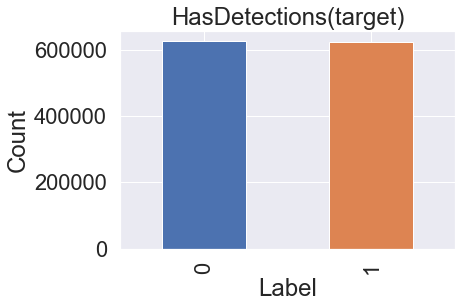

In [10]:
train['HasDetections'].value_counts().plot.bar()
plt.title('HasDetections(target)');
plt.ylabel('Count');
plt.xlabel('Label');

- The label distribution for the target variable is equally distributed. This is good, which means we do not have unbalanced data.

### Now we see which features have most data missing.

In [11]:
%%time
# checking missing data
total = train.isnull().sum().sort_values(ascending = False)
#percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
percent_total_data = (train.isnull().sum()/train.shape[0]*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent_total_data], axis=1, keys=['Total', 'Percent_Total_Data'])

Wall time: 3.15 s


### Top 20 features that have maximum data missing

In [12]:
print('Displaying top 20 features that have missing data')
missing_train_data.head(20)

Displaying top 20 features that have missing data


Total  Percent_Total_Data
PuaMode                                1249675            99.97400
Census_ProcessorClass                  1244874            99.58992
DefaultBrowsersIdentifier              1189396            95.15168
Census_IsFlightingInternal             1037680            83.01440
Census_InternalBatteryType              887378            70.99024
Census_ThresholdOptIn                   793343            63.46744
Census_IsWIMBootEnabled                 792257            63.38056
SmartScreen                             444997            35.59976
OrganizationIdentifier                  386109            30.88872
SMode                                    74852             5.98816
CityIdentifier                           45634             3.65072
Wdft_IsGamer                             42570             3.40560
Wdft_RegionIdentifier                    42570             3.40560
Census_InternalBatteryNumberOfCharges    37509             3.00072
Census_FirmwareManufacturerIdentifier    25506             2.04048
Census_FirmwareVersionIdentifier         22323             1.78584
Census_IsFlightsDisabled                 22203             1.77624
Census_OEMModelIdentifier                14187             1.13496
Census_OEMNameIdentifier                 13213             1.05704
Firewall                                 12886             1.03088

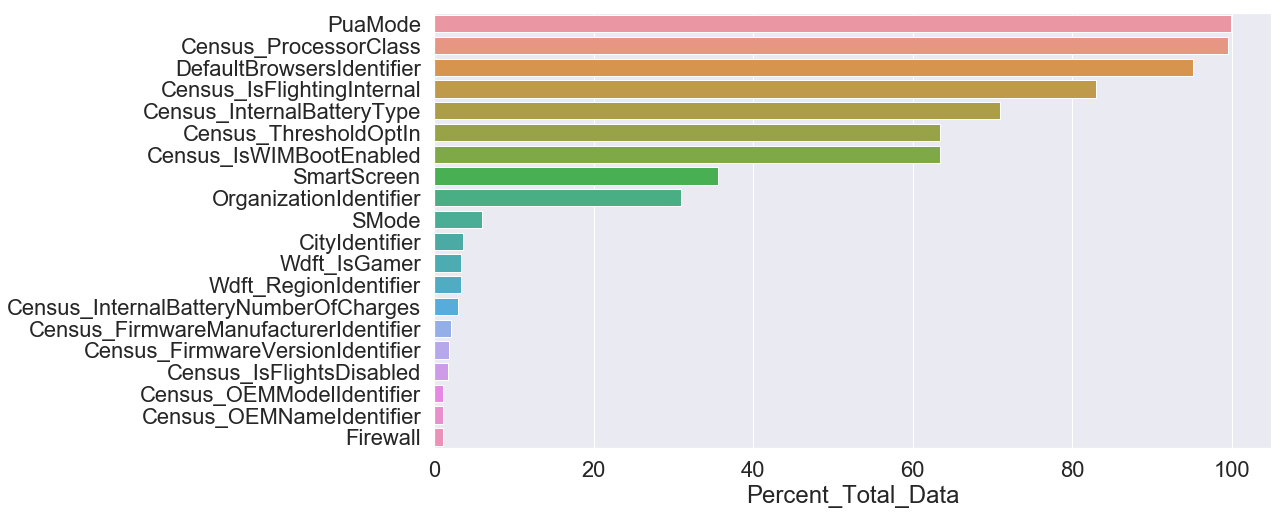

In [13]:
#missing_train_data.axes[0]
plt.rcParams["figure.figsize"] = (15,8)

sns.barplot(x="Percent_Total_Data", y=missing_train_data.head(n=20).axes[0], data=missing_train_data.head(n=20))
plt.show()

*The plot above gives a good idea about which features have most missing values. We can see that the top 5 features have > 70% data missing. Can we drop these variables?*

In [14]:
print("Top 5 Missing Data Variables")
print(list(missing_train_data.axes[0][:5]))

Top 5 Missing Data Variables
['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_InternalBatteryType']


### Now let us do some EDA on the top-5  features with respect to missing features. 
#### These have > 70% missing.

### a. Pua Mode (Does the machine have PUA mode enabled?)
- PUA --> Potentially Unwanted Applications

In [15]:
print(train['PuaMode'].dtypes)

category


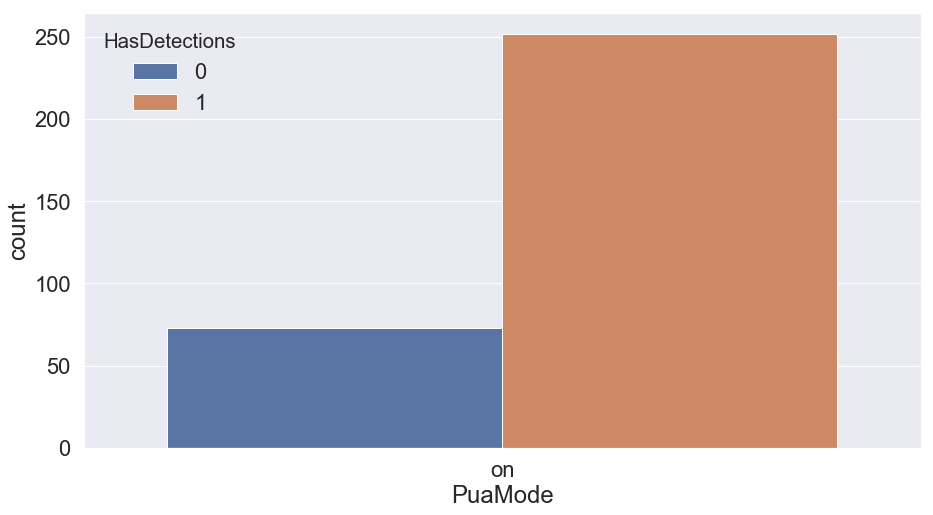

In [16]:
sns.countplot(x='PuaMode', hue='HasDetections', data=train);
plt.rcParams['figure.figsize'] = (4,4)
plt.show();

- We just have PuaMode on in this subset. Also note that we roughly have just **300** non-null values. Thus we can safely remove this feature.

### b. Census_ProcessorClass

This is an estimation of the processor class, if it is high, mid or low end.

In [17]:
print(train['Census_ProcessorClass'].dtypes)

category


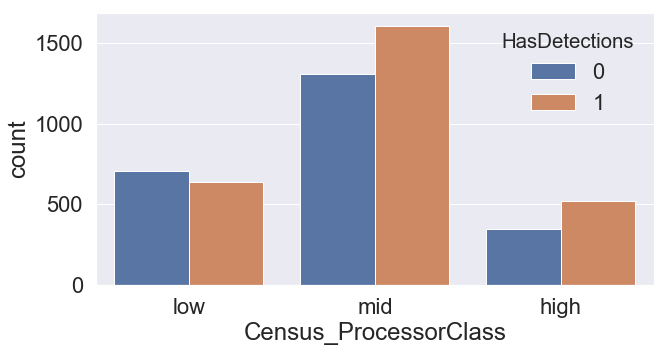

In [18]:
plt.rcParams["figure.figsize"] = (10,5)
sns.countplot(x='Census_ProcessorClass', hue='HasDetections',data=train, order=['low', 'mid', 'high'])
plt.show()

- Again, there seems to be slight difference in detections among mid and high classes and low. But again, we have far too few data for this feature given the scale of the data.

### c. DefaultBrowsersIdentifier

This identifier is for the system default browser.

In [19]:
print(train['DefaultBrowsersIdentifier'].dtypes)

float16


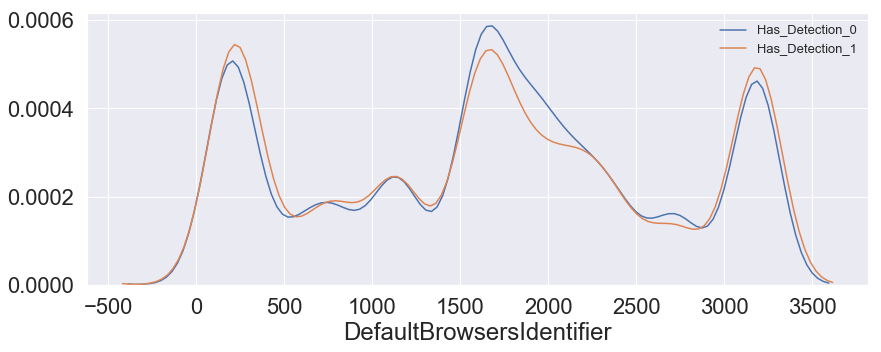

In [20]:
plt.rcParams["figure.figsize"] = (14,5)
sns.kdeplot(train.loc[train['HasDetections'] == 0, 'DefaultBrowsersIdentifier'], label='Has_Detection_0', legend=False)
sns.kdeplot(train.loc[train['HasDetections'] == 1, 'DefaultBrowsersIdentifier'], label='Has_Detection_1', legend=False)
plt.legend(loc='best', prop={'size': 13})
plt.xlabel('DefaultBrowsersIdentifier')
plt.show()

- There doesn't really seem to be much difference between the detection label and default browser identifier.

### d. Census_IsFlightingInternal

This is related to Driver Flighting. https://docs.microsoft.com/en-us/windows-hardware/drivers/dashboard/driver-flighting

In [21]:
print(train["Census_IsFlightingInternal"].dtypes)

float16


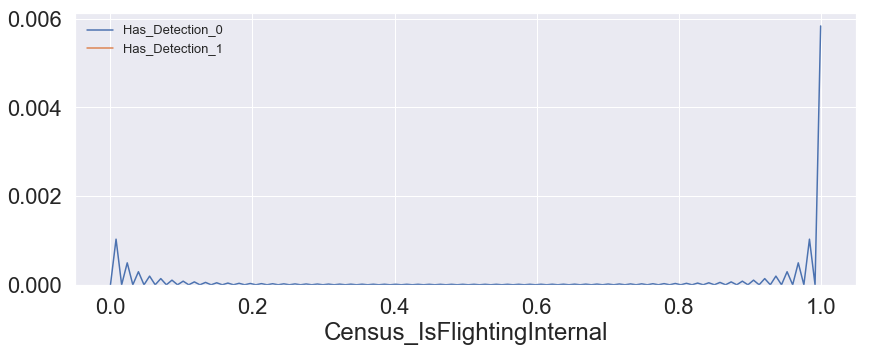

In [22]:
plt.rcParams["figure.figsize"] = (14,5)
sns.kdeplot(train.loc[train['HasDetections'] == 0, 'Census_IsFlightingInternal'], label='Has_Detection_0', legend=False)
sns.kdeplot(train.loc[train['HasDetections'] == 1, 'Census_IsFlightingInternal'], label='Has_Detection_1', legend=False)
plt.legend(loc='best', prop={'size': 13})
plt.xlabel('Census_IsFlightingInternal')
plt.show()

- We have no data for positive detection. Also, mostly zero.

### e. Census_InternalBatteryType

This represents the system internal battery type used.

In [23]:
print(train["Census_InternalBatteryType"].dtypes)

category


In [24]:
batt_types_top10 = list(train['Census_InternalBatteryType'].value_counts()[:10].axes[0])
print(batt_types_top10)

['lion', 'li-i', '#', 'lip', 'liio', 'li p', 'li', 'nimh', 'real', 'pbac']


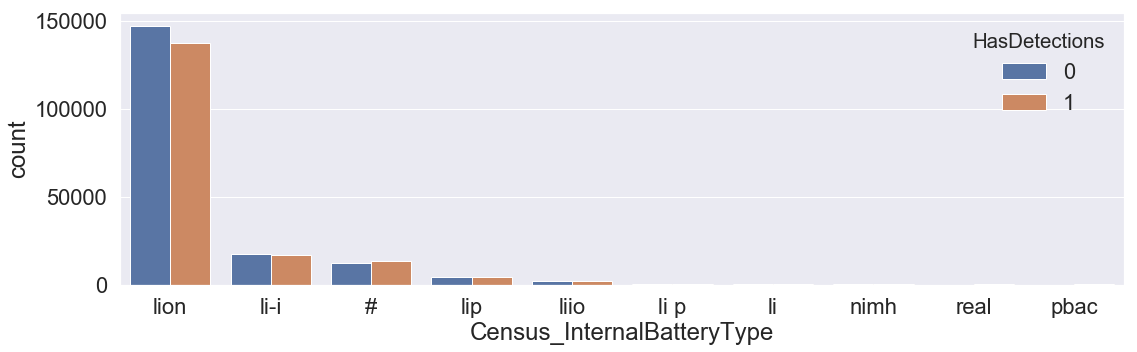

In [25]:
plt.rcParams["figure.figsize"] = (18,5)
train_batt = train.loc[train['Census_InternalBatteryType'].isin(batt_types_top10)]
sns.countplot(x='Census_InternalBatteryType', hue='HasDetections',data=train, order=train['Census_InternalBatteryType'].value_counts().iloc[:10].index)
plt.show()

- There does seem to be some differences, but also there seems to be a lot of batteries with li in them. 
- Other tha lion others have very little count.

### EDA of Categorical Variables
- Now we perform some Data Analysis for a few of the categorical variables.

In [12]:
target_feature = 'HasDetections'

In [13]:
categorical_features = [
        'ProductName',                                          
        'EngineVersion',                                        
        'AppVersion',                                           
        'AvSigVersion',                                         
        'Platform',                                             
        'Processor',                                            
        'OsVer',                                                
        'OsPlatformSubRelease',                                 
        'OsBuildLab',                                           
        'SkuEdition',                                           
        'SmartScreen',                                          
        'Census_MDC2FormFactor',                                
        'Census_DeviceFamily',                                  
        'Census_PrimaryDiskTypeName',                           
        'Census_ChassisTypeName',                               
        'Census_PowerPlatformRoleName',                         
        'Census_OSVersion',                                     
        'Census_OSArchitecture',                                
        'Census_OSBranch',                                      
        'Census_OSEdition',                                     
        'Census_OSSkuName',                                     
        'Census_OSInstallTypeName',                             
        'Census_OSWUAutoUpdateOptionsName',                     
        'Census_GenuineStateName',                              
        'Census_ActivationChannel',                             
        'Census_FlightRing',                                    
]

In [399]:
# Helper function

def plot_category_percent_of_target(data, col, rev=False):
    if 'AppVersion' in col:
        if not rev:
            fig, ax = plt.subplots(1, 1, figsize=(15, 35))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    elif 'Version' in col:
        if not rev:
            fig, ax = plt.subplots(1, 1, figsize=(15, 25))
        else:
            fig, ax = plt.subplots(1, 1, figsize=(15,8))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    # Compute the percentage as sum/count or mean
    if col != 'AvSigVersion':
        df_1 = data[[col, 'HasDetections']].groupby(col, as_index=False).mean()
        # Also show the total count of this.
        df_2 = data[col].value_counts().reset_index(drop=False)
        df_2.columns = [col, 'count']
        df_1 = df_1.merge(df_2, on=col, how='left')
        df_1['HasDetections'] = df_1['HasDetections'].fillna(0)
        if 'Version' in col:
            df_1['Version_AsNum'] = df_1.apply(lambda x: int(x[col].replace('.','').replace('&#x17;','')), axis=1)
            df_1 = df_1.sort_values(by='Version_AsNum', ascending=True)
            #print(df_1.shape)
            #print(df_1.head(100))
            #return
        else:
            df_1 = df_1.sort_values(by='count', ascending=False)[:30]
    else:
        data = data[[col, 'HasDetections']]
        data[col] = data.apply(lambda x: '.'.join(x[col].replace('&#x17;','').split('.')[0:2]), axis=1)
        df_1 = data[[col, 'HasDetections']].groupby(col, as_index=False).mean()
        df_2 = data[col].value_counts().reset_index(drop=False)
        df_2.columns = [col, 'count']
        df_1 = df_1.merge(df_2, on=col, how='left')
        df_1['HasDetections'] = df_1['HasDetections'].fillna(0)
        if 'Version' in col:
            df_1['Version_AsNum'] = df_1.apply(lambda x: int(x[col].replace('.','').replace('&#x17;','')), axis=1)
            df_1 = df_1.sort_values(by='Version_AsNum', ascending=True)
        #print(df_1.head(20))
        #return
        df_1['Version_AsNum'] = df_1.apply(lambda x: int(x[col].replace('.','').replace('&#x17;','')), axis=1)
        #print(df_1.head(10))
        #return
    if not rev:
        sns.barplot(ax=ax, y=col, x='HasDetections', data=df_1, order=df_1[col])
        if 'Version' in col:
            for i, p in enumerate(ax.patches):
                if df_1['count'].values[i] > 1000:
                    ax.annotate('{}'.format(df_1['count'].values[i]),(p.get_width(), p.get_y()+0.5), fontsize=15)
        else:
            for i, p in enumerate(ax.patches):
                ax.annotate('{}'.format(df_1['count'].values[i]),(p.get_width(), p.get_y()+0.5), fontsize=15)
        plt.xlabel('% of HasDetections(target)')
        plt.ylabel(col)
        plt.show()
    # Rev
    else:
        #sns.barplot(ax=ax, x=col, y='HasDetections', data=df_1, order=df_1[col])
        #if col != 'AvSigVersion':
        sns.barplot(ax=ax, x=col, y='HasDetections', data=df_1, order=df_1[col])
        if 'Version' in col:
            for i, p in enumerate(ax.patches):
                if col != "AvSigVersion":
                    if df_1['count'].values[i] > 1000:
                        ax.annotate('{}'.format(df_1['count'].values[i]),(p.get_x(), p.get_height()+0.08), fontsize=12).set_rotation(90)
                else:
                    if df_1['count'].values[i] > 100:
                        ax.annotate('{}'.format(df_1['count'].values[i]),(p.get_x(), p.get_height()+0.08), fontsize=12).set_rotation(90)
        else:
            for i, p in enumerate(ax.patches):
                ax.annotate('{}'.format(df_1['count'].values[i]),(p.get_x(), p.get_height()), fontsize=15)
        if 'AppVersion' in col:
            plt.xticks(np.arange(0,df_1.shape[0],step=2), rotation=75, fontsize=12)
        else:
            plt.xticks(rotation=75, fontsize=12)
        #else:
            #ax_1 = sns.barplot(ax=ax, x='Version_AsNum', y='HasDetections', data=df_1)
            #ax_1.lines[0].set_linestyle('o-')
            #plt.xticks([])
        plt.ylabel('% of HasDetections(target)')
        plt.xlabel(col)
        plt.show()

#     for i, p in enumerate(ax.patches):
        
#         #print(p.get_height())
#         ax.annotate('{}'.format(df_1['count'].values[i]),(p.get_width(), p.get_y()+0.5), fontsize=15)

    

### a. Product Name (Defender State Information)

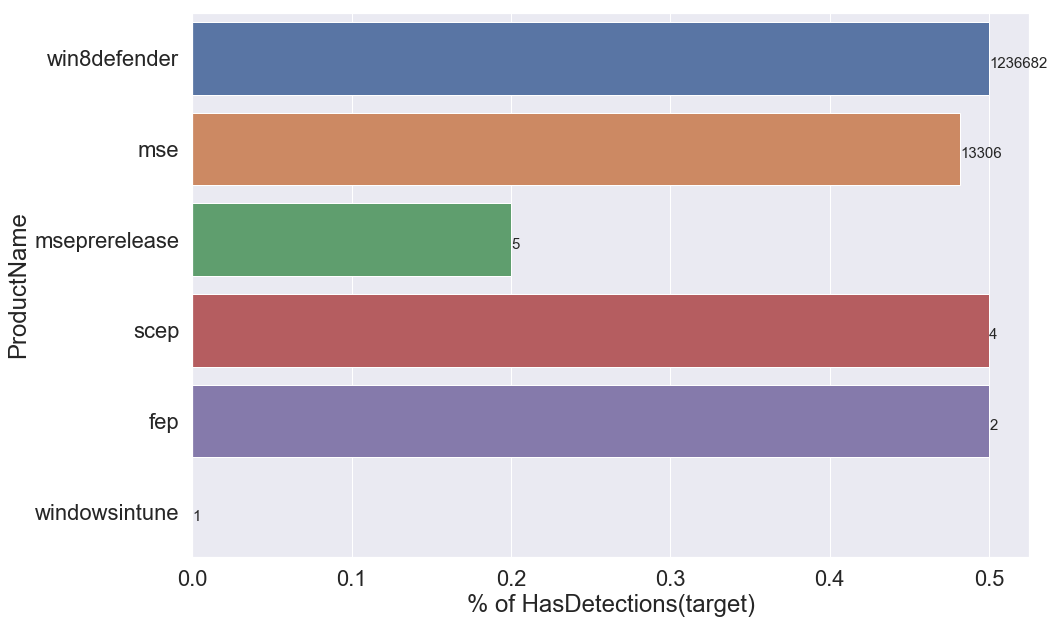

In [29]:
feat = categorical_features[0]
plot_category_percent_of_target(train, feat)

- Most machines have Win8Defender or MSE. 

### b. EngineVersion: Defender State Information

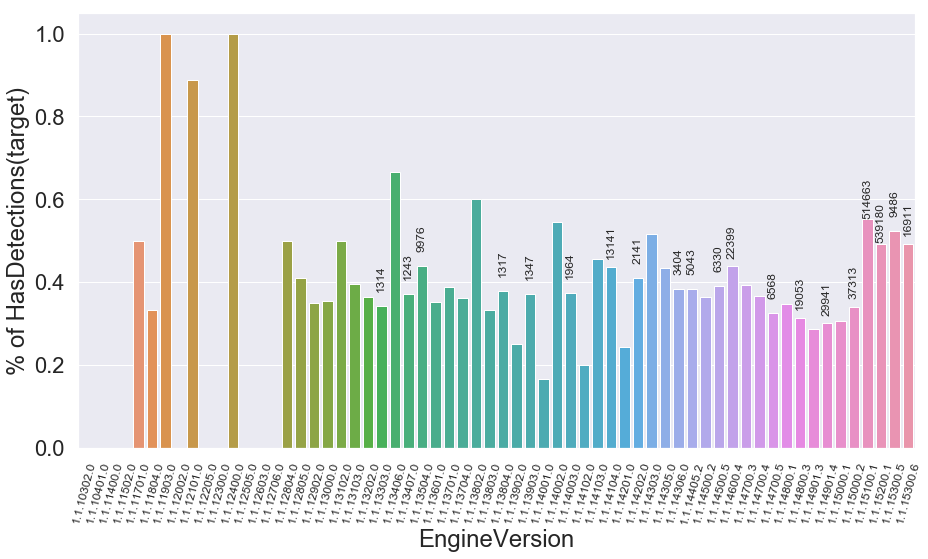

In [30]:
feat = categorical_features[1]
plot_category_percent_of_target(train, feat, rev=True)

- We sort the plot by version number to show how detection rate changes over version changes.

### c. AppVersion: Defender State Information

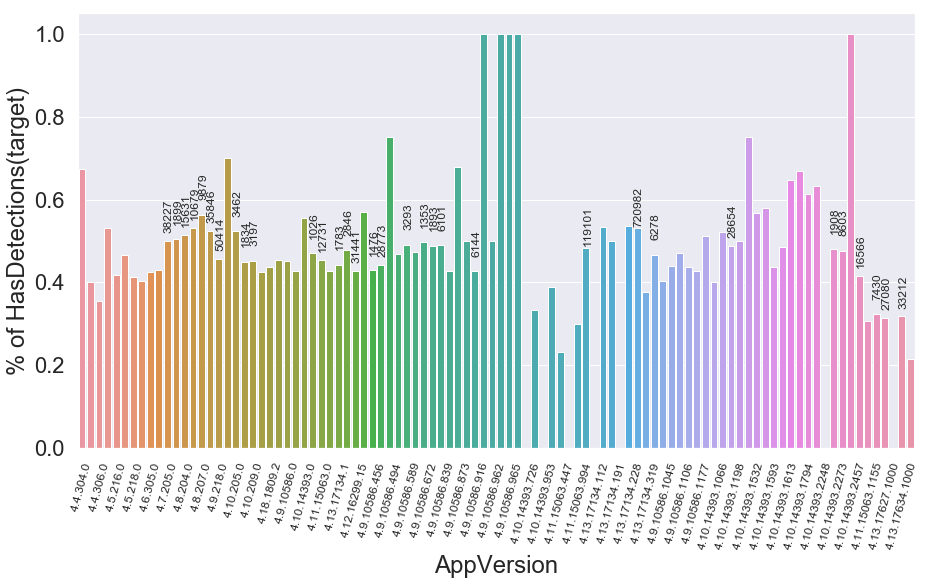

In [31]:
feat = categorical_features[2]
plot_category_percent_of_target(train, feat, rev=True)

### d. AvSigVersion: Defender State Information

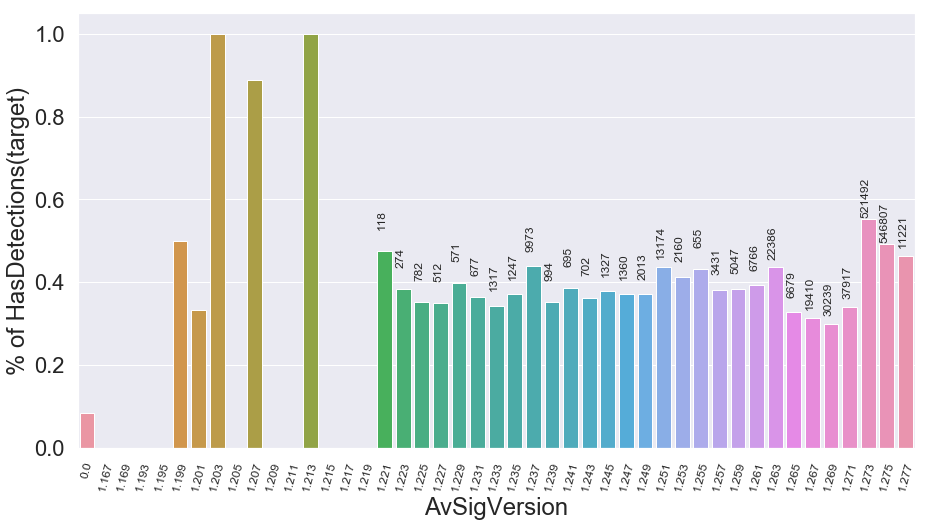

In [32]:
col = categorical_features[3]
plot_category_percent_of_target(train, col, rev=True)

- For the plot we consider the first 4 digits p.qqq of the whole version p.qqq.rrr.s. The first four numbers indicate the major and minor release numbers. 

### e. Platform
- Calculates platform name (of OS related properties and processor property)

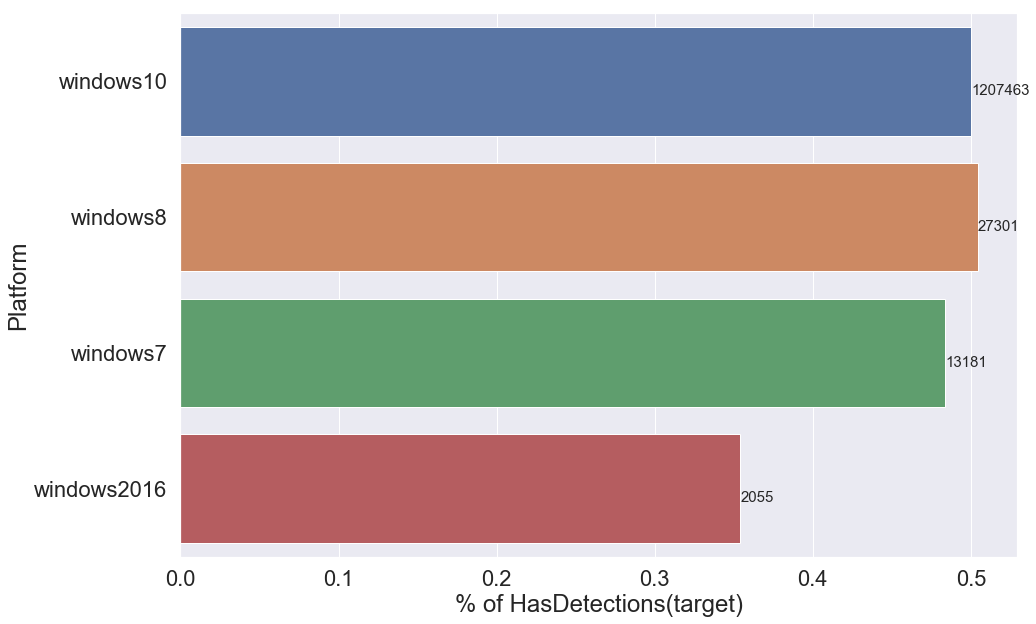

In [33]:
col = categorical_features[4]
plot_category_percent_of_target(train, col, rev=False)

- Windows 10 is the most common platform.

### f. Processor
- This is the process architecture of the installed operating system

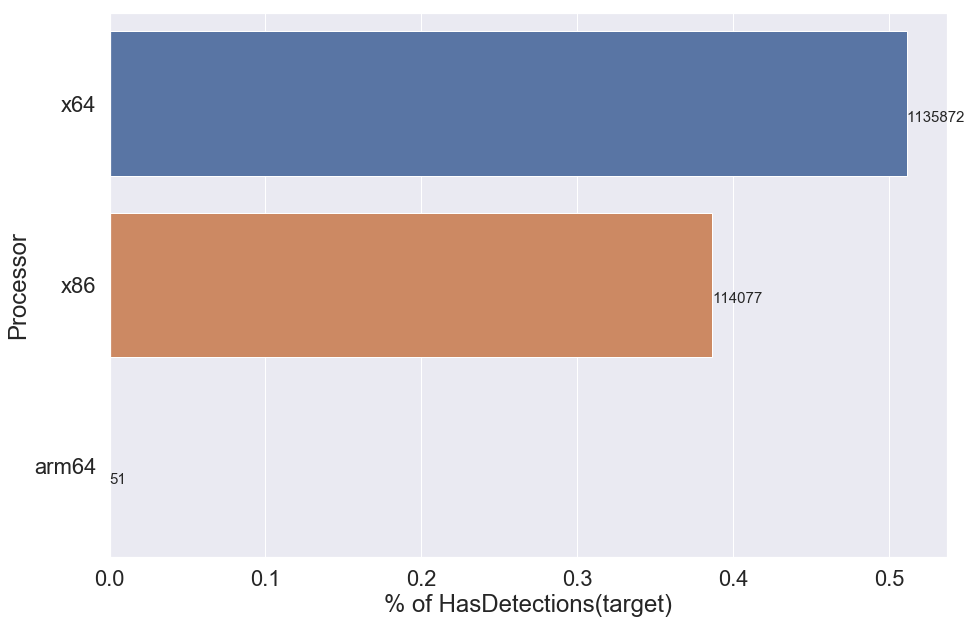

In [34]:
col = categorical_features[5]
plot_category_percent_of_target(train, col, rev=False)

- x64 is the most common. x86 is far fewer, and also seems to have less detections.

### g. OsVer
- Version of the current operating system

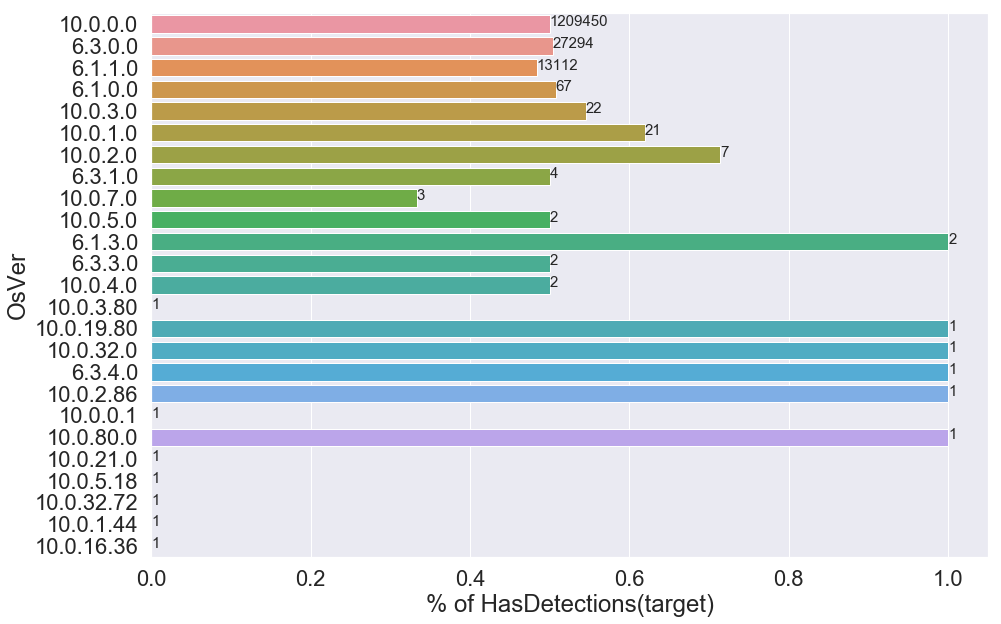

In [35]:
#print(set(train['OsVer']))
col = categorical_features[6]
#print(col)
plot_category_percent_of_target(train, col, rev=False)

### h. SKU Edition
- The goal of this feature is to use the Product Type defined in the MSDN to map to a 'SKU-Edition' name that is useful in population reporting. The valid Product Type are defined in %sdxroot%\data\windowseditions.xml. 
- This API has been used since Vista and Server 2008, so there are many Product Types that do not apply to Windows 10. 

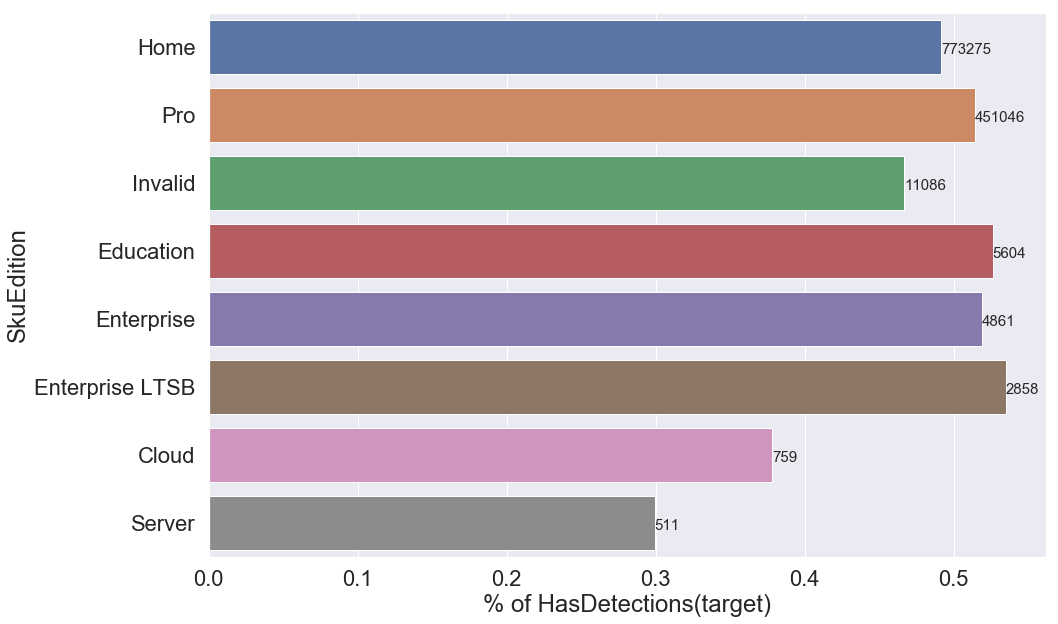

In [36]:
feat = categorical_features[9]
plot_category_percent_of_target(train, feat, False)

- Home and Pro are the most common types.

### i. SmartScreen 
- This is the SmartScreen enabled string value from registry. This is obtained by checking in order, HKLM\SOFTWARE\Policies\Microsoft\Windows\System\SmartScreenEnabled and HKLM\SOFTWARE\Microsoft\Windows\CurrentVersion\Explorer\SmartScreenEnabled. If the value exists but is blank, the value "ExistsNotSet" is sent in telemetry.

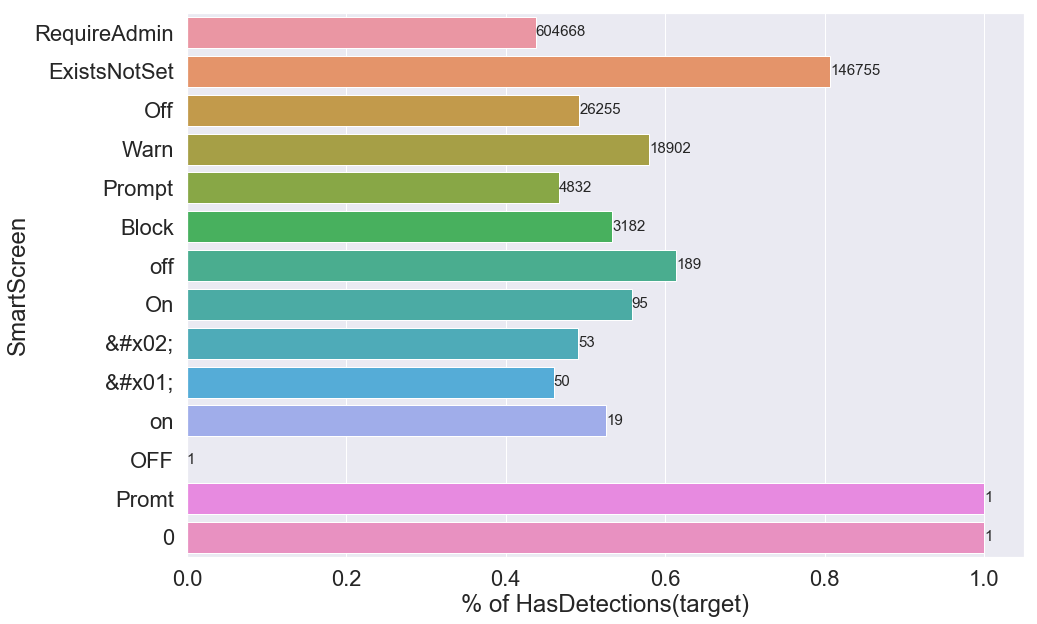

In [37]:
feat = categorical_features[10]
plot_category_percent_of_target(train, feat, False)

- ExistsNotSet has a lot of detections.

### j. Census_MDC2FormFactor
- A grouping based on a combination of Device Census level hardware characteristics. The logic used to define Form Factor is rooted in business and industry standards and aligns with how people think about their device.

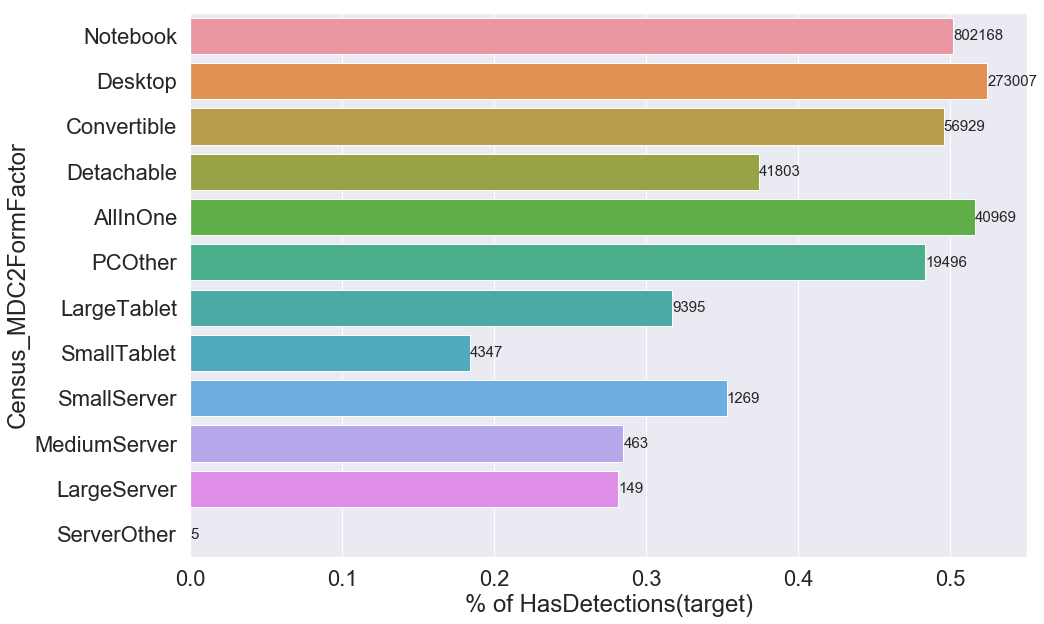

In [38]:
feat = categorical_features[11]
plot_category_percent_of_target(train, feat, False)

- Notebook and Desktop are the most common

### k. Census_OSWUAutoUpdateOptionsName
- Friendly name of the WindowsUpdate auto-update settings on the machine.

Census_OSWUAutoUpdateOptionsName


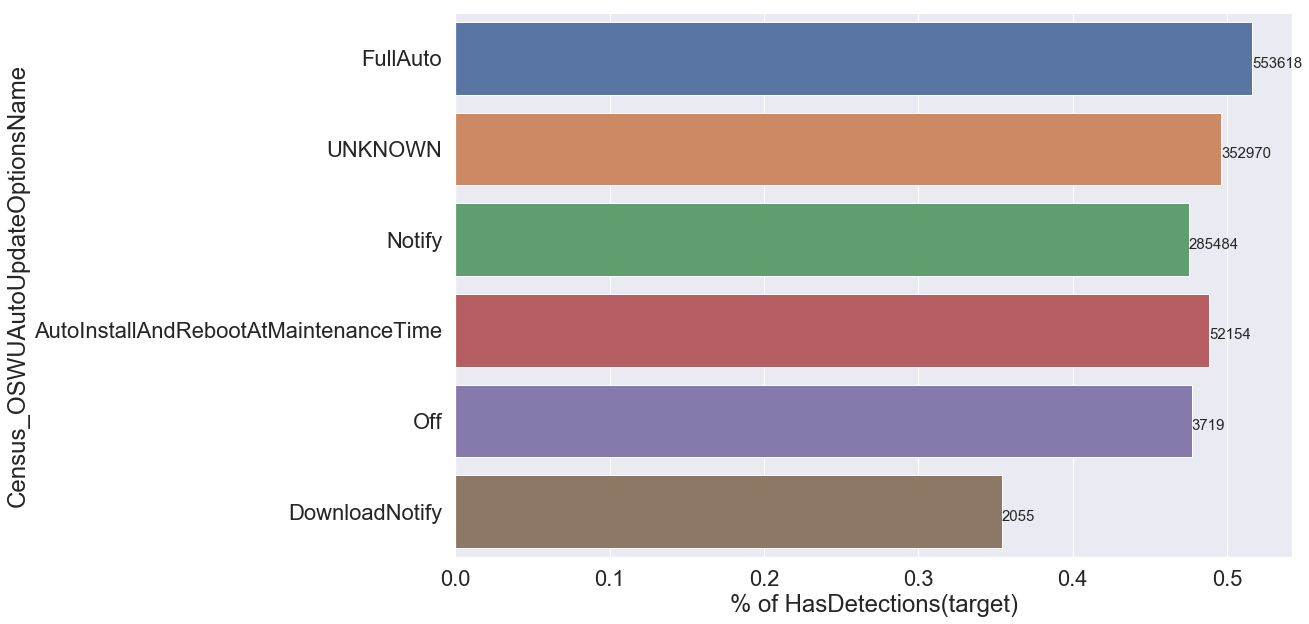

In [39]:
feat = categorical_features[22]
print(feat)
plot_category_percent_of_target(train, feat, False)

- Lot of machines have it set to Auto.

### l. Census_GenuineStateName
- Friendly name of OSGenuineStateID. 0 = Genuine

Census_GenuineStateName


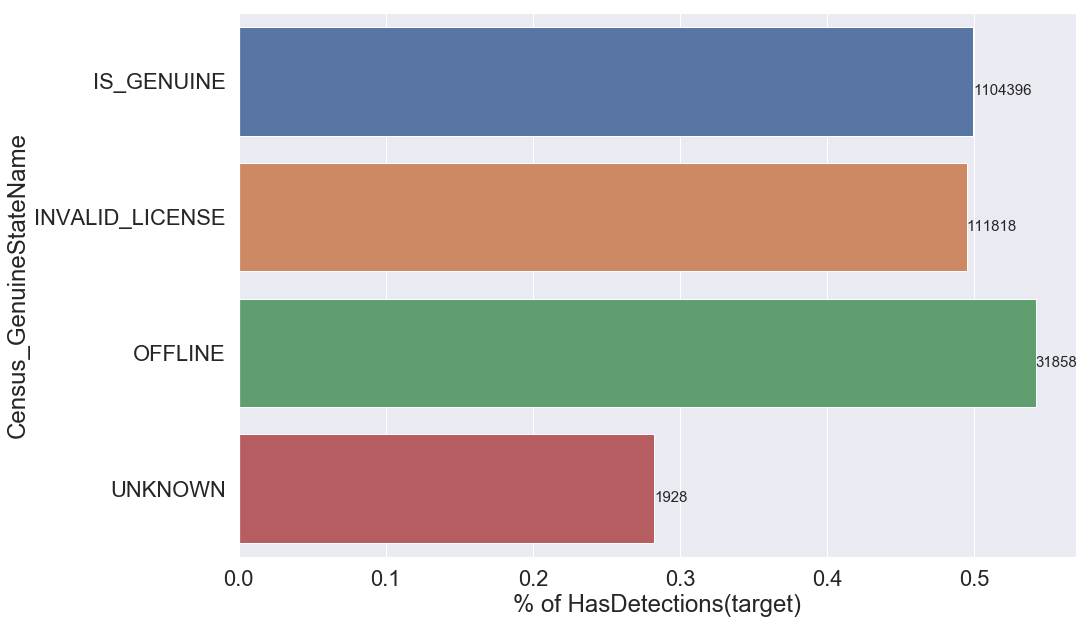

In [40]:
feat = categorical_features[23]
print(feat)
plot_category_percent_of_target(train, feat, False)

- So most machines are genuine. 
- Most classes seem to have the same detection rate more or less, at least among the most common ones.

### We now show the variable type distribution in the provided data.

In [43]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]
## Perhaps, even though the versions are categorical, we should consider them as numeric? There is a timeshift in versions
## especially of AvSigVersion between train and test.

In [44]:
# We also list binary variables, since they can be treated as numericals by tree methods
binary_variables = [c for c in train.columns if train[c].nunique() == 2]

In [45]:
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) and (c not in binary_variables)]

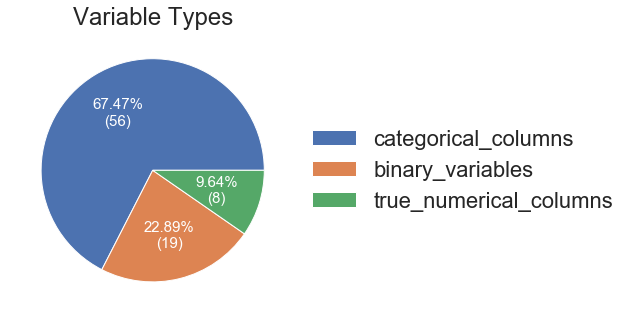

In [46]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))
    return "{:.2f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize=(5, 8), subplot_kw=dict(aspect="equal"))

#plt.pie(x=list(variables.values()), labels=list(variables.keys()))
#plt.show()

wedges, texts, autotexts = ax.pie(x=list(variables.values()), autopct=lambda pct: func(pct, list(variables.values())),
                                  textprops=dict(color="w", ))
ax.legend(wedges, list(variables.keys()),
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title("Variable Types")
plt.setp(autotexts, size=15)

plt.show()

- We see that most of the features are categorical (including the binary classes).

### We check the cardinality of the categorical columns. 
- If any feature has very high cardinality, we will consider doing frequency encoding.

In [47]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=True)

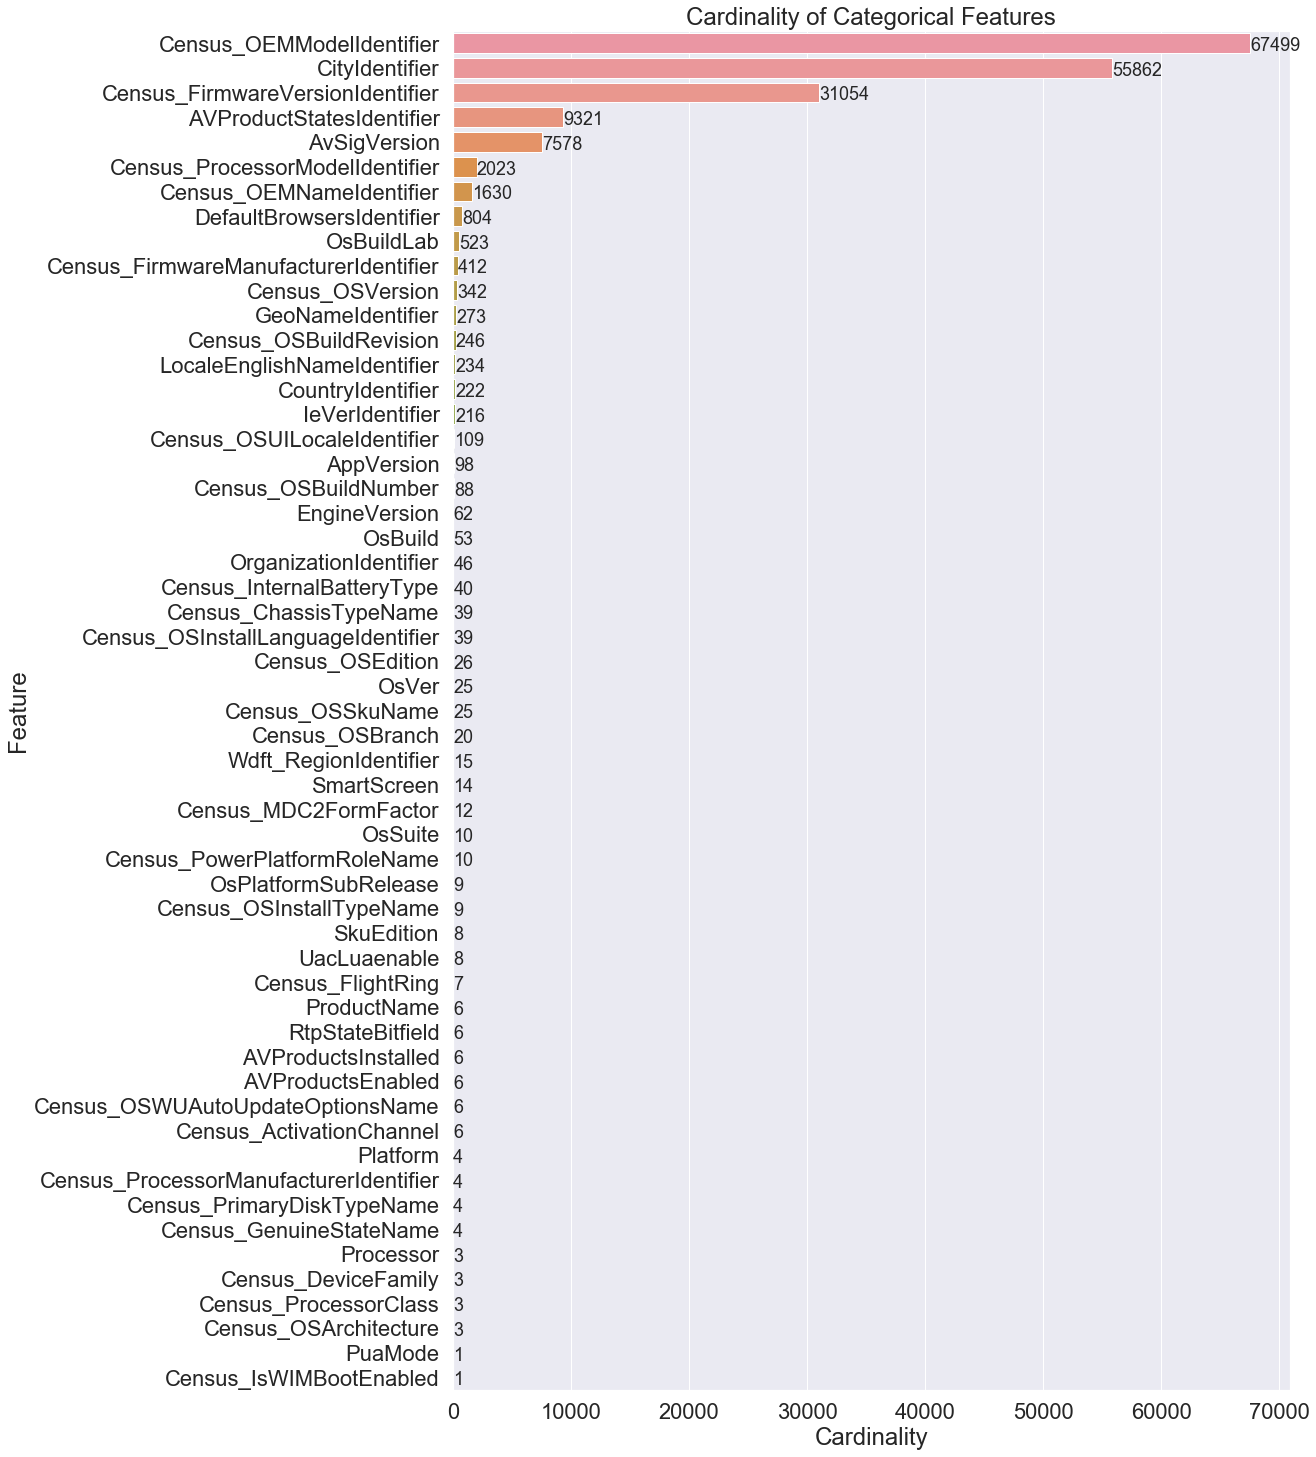

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 25))
sns.barplot(x=[x[1] for x in cardinality], y=[x[0] for x in cardinality])
for i, p in enumerate(ax.patches):
    ax.annotate('{}'.format(cardinality[i][1]),(p.get_width()+10, p.get_y()+0.7), fontsize=18)

plt.xlabel('Cardinality')
plt.ylabel("Feature")
plt.title("Cardinality of Categorical Features")
plt.show()


- There are some categories that have a very high amount of cardinality!

In [49]:
len(binary_variables) + len(categorical_columns) + len(true_numerical_columns)

83

In [50]:
train_copy = train.copy()

## Categorical Feature Encoding

- We perform two types of encoding. 
- One is frequency encoding, which is performed for variables that have very high cardinality. They are encoded by their frequency which converts them to numerical values effectively. A bit about this is explained here: https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study.
- The other is simple label encoding. This ensures strings are converted to numbers to correspond each feature class.

In [51]:
# Frequency encoding
# For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their 
# frequencies. These variables are then treated as numerical.
def frequency_encoding(variable):
    t = pd.concat([train_copy[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [52]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'AVProductStatesIdentifier',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier',
    'OsBuildLab'
]

In [53]:
for variable in tqdm(frequency_encoded_variables):
    try:
        freq_enc_dict = frequency_encoding(variable)
        #train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
        train_copy[variable] = train_copy[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
        categorical_columns.remove(variable)
    except:
        print('OOPS')
        pass

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:06<00:00,  1.41it/s]


In [54]:
for col in tqdm(categorical_columns):
    if str(train_copy[col].dtypes)=='category':
        train_copy[col] = train_copy[col].cat.add_categories(['isna'])
    train_copy.loc[train_copy[col].isna(),col]  ='isna'

indexer = {}
for col in tqdm(categorical_columns+binary_variables):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train_copy[col])
    train_copy[col] = indexer[col].get_indexer(train_copy[col])

del indexer
gc.collect()

100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:57<00:00,  1.15it/s]


13806

#### Run utility function to reduce mem usage by smart data type setting

In [55]:
train_copy = reduce_mem_usage(train_copy)

Mem. usage decreased to 190.20 Mb (75.9% reduction)


#### Impute using median

In [56]:
train_copy = train_copy.fillna(train_copy.median())

### Preview the data

In [57]:
train_copy.head(20)

MachineIdentifier  ProductName  EngineVersion  AppVersion  \
0   0000028988387b115f69f31a3bf04f09            0              0           0   
1   000007535c3f730efa9ea0b7ef1bd645            0              1           1   
2   000007905a28d863f6d0d597892cd692            0              0           0   
3   00000b11598a75ea8ba1beea8459149f            0              0           0   
4   000014a5f00daa18e76b81417eeb99fc            0              0           0   
5   000016191b897145d069102325cab760            0              0           0   
6   0000161e8abf8d8b89c5ab8787fd712b            0              0           0   
7   000019515bc8f95851aff6de873405e8            0              0           0   
8   00001a027a0ab970c408182df8484fce            0              2           0   
9   00001a18d69bb60bda9779408dcf02ac            0              0           0   
10  00001b3b3cf8c8c079a272ce51031753            0              0           0   
11  00001b924fcc6922321cfadbafd8a91a            0              0           0   
12  00001f26e9e5775277d6231fc6ac9e70            0              0           0   
13  000024872c81cf03fa862aa8f99e0984            0              2           0   
14  0000258d2b847c7549150cfec6464473            0              0           0   
15  000027c68b89acb49d4017763b043449            0              2           0   
16  000028150912f45b1dc667164de489ef            1              2           2   
17  00002a7fd74f9ca4a59a679a7cc80388            0              0           3   
18  00002b7454f06444e8d9f6083d8a9ebd            0              3           4   
19  00002c6cccecdef94aaa557d0458ab8a            0              0           0   

    AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0           78.0       0                 0                 0   
1            1.0       0                 0                 0   
2          183.0       0                 0                 0   
3           16.0       0                 0                 0   
4           12.0       0                 0                 0   
5           73.0       0                 0                 0   
6          765.0       0                 0                 0   
7          427.0       0                 0                 0   
8           76.0       0                 0                 0   
9          404.0       0                 0                 0   
10          54.0       0                 0                 0   
11           5.0       0                 0                 0   
12         399.0       0                 0                 0   
13         213.0       0                 0                 0   
14         349.0       0                 0                 0   
15         462.0       0                 0                 0   
16         121.0       0                 0                 0   
17        1479.0       0                 1                 1   
18         320.0       0                 0                 0   
19          31.0       0                 0                 0   

    DefaultBrowsersIdentifier  AVProductStatesIdentifier  AVProductsInstalled  \
0                         8.0                        0.0                    0   
1                         8.0                        0.0                    0   
2                         8.0                        0.0                    0   
3                         8.0                        0.0                    0   
4                         8.0                        0.0                    0   
5                         8.0                        0.0                    0   
6                         8.0                       13.0                    1   
7                         8.0                        0.0                    0   
8                         8.0                        0.0                    0   
9                         8.0                        4.0                    1   
10                        8.0                        0.0                    0   
11                   

### We drop the 5 features that had the most missing values. 
### Also drop the identifier column as it is simple indexer

In [58]:
train_copy = train_copy.drop(columns=['PuaMode', 'Census_ProcessorClass', 'DefaultBrowsersIdentifier', 'Census_IsFlightingInternal', 'Census_InternalBatteryType'])

In [59]:
train_copy = train_copy.drop(columns=['MachineIdentifier'])

In [60]:
train_copy.head()

ProductName  EngineVersion  AppVersion  AvSigVersion  IsBeta  \
0            0              0           0          78.0       0   
1            0              1           1           1.0       0   
2            0              0           0         183.0       0   
3            0              0           0          16.0       0   
4            0              0           0          12.0       0   

   RtpStateBitfield  IsSxsPassiveMode  AVProductStatesIdentifier  \
0                 0                 0                        0.0   
1                 0                 0                        0.0   
2                 0                 0                        0.0   
3                 0                 0                        0.0   
4                 0                 0                        0.0   

   AVProductsInstalled  AVProductsEnabled  HasTpm  CountryIdentifier  \
0                    0                  0       0                  0   
1                    0                  0       0                  1   
2                    0                  0       0                  2   
3                    0                  0       0                  3   
4                    0                  0       0                  4   

   CityIdentifier  OrganizationIdentifier  GeoNameIdentifier  \
0           208.0                       0                  0   
1           158.0                       0                  1   
2           795.0                       0                  2   
3            19.0                       1                  3   
4            14.0                       1                  4   

   LocaleEnglishNameIdentifier  Platform  Processor  OsVer  OsBuild  OsSuite  \
0                            0         0          0      0        0        0   
1                            1         0          0      0        0        0   
2                            2         0          0      0        0        1   
3                            3         0          0      0        0        0   
4                            4         0          0      0        0        1   

   OsPlatformSubRelease  OsBuildLab  SkuEdition  IsProtected  AutoSampleOptIn  \
0                     0         0.0           0            0                0   
1                     0         0.0           0            0                0   
2                     0         0.0           1            0                0   
3                     0         0.0           0            0                0   
4                     0         0.0           1            0                0   

   SMode  IeVerIdentifier  SmartScreen  Firewall  UacLuaenable  \
0      0                0            0         0             0   
1      0                0            0         0             0   
2      0                0            1         0             0   
3      0                0            2         0             0   
4      0                0            1         0             0   

   Census_MDC2FormFactor  Census_DeviceFamily  Census_OEMNameIdentifier  \
0                      0                    0                       0.0   
1                      1                    0                       0.0   
2                      0                    0                      11.0   
3                      0                    0                       2.0   
4                      1                    0                       2.0   

   Census_OEMModelIdentifier  Census_ProcessorCoreCount  \
0                    21680.0                        4.0   
1                    31504.0                        4.0   
2                        2.0                        4.0   
3                      178.0                        4.0   
4                     2216.0                        4.0   

   Census_ProcessorManufacturerIdentifier  Census_ProcessorModelIdentifier  \
0                                       0                            147.0   
1                                       0     

## Now do Train-Test split on the data.

In [61]:
seed_everything()

In [62]:
target = train_copy['HasDetections']
del train_copy['HasDetections']

In [63]:
# Train samples = 1,250,000
# Validation samples = 250,000 (about 20% of the full data)
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(train_copy, target, test_size=0.2)

In [64]:
print("Train Data Shape:", X_train.shape)
print("Test Data Shape:", X_test.shape)

Train Data Shape: (1000000, 76)
Test Data Shape: (250000, 76)


- We finally end up with 76 predictor features.

### EDA Finale: Correlation effects
- Here, we compute correlation between the different predictor variables and then try to visualize it using clustering.

In [63]:
corr = X_train.corr(method='kendall')

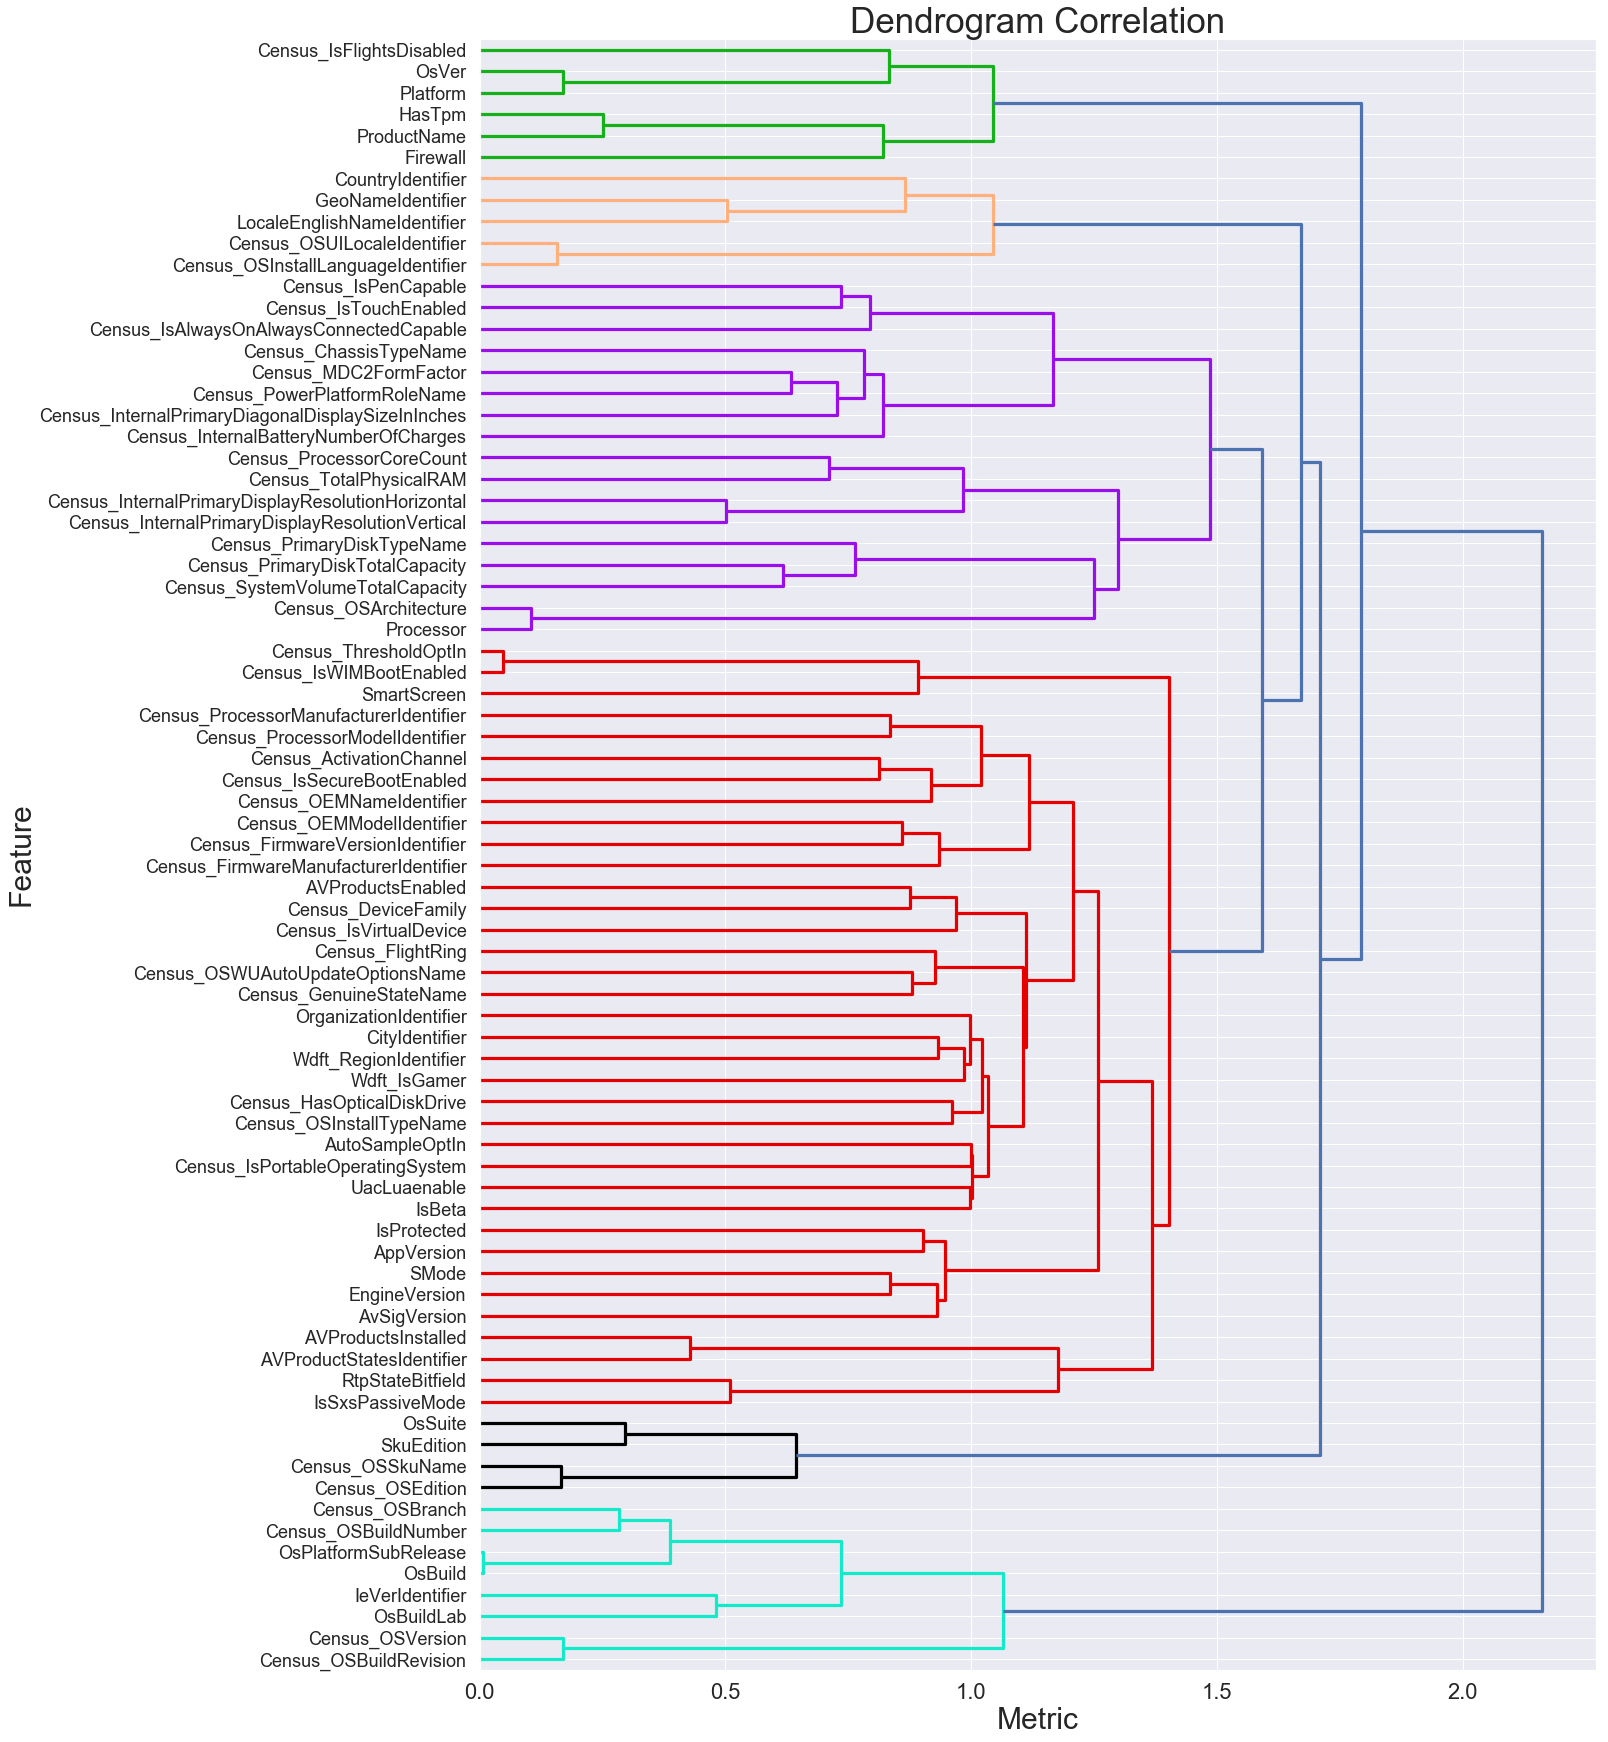

In [64]:
#from scipy.cluster import hierarchy as hc

plt.rcParams['lines.linewidth'] = 3.2
# Convert the corr score to Euclidean using cosine measure.
corr_euclid = hc.distance.squareform(np.sqrt(1-np.abs(corr)))
# Use Ward's method
z = hc.linkage(corr_euclid, method='ward', optimal_ordering=True)
fig = plt.figure(figsize=(20,30))
hc.set_link_color_palette(['xkcd:aqua', 'xkcd:black', 'xkcd:red', 'xkcd:violet', 'xkcd:peach', 'xkcd:green', 'xkcd:violet'])
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='right', leaf_font_size=18)
plt.title('Dendrogram Correlation', fontsize=35)
plt.xlabel('Metric', fontsize=30)
plt.ylabel('Feature', fontsize=30)
plt.show()

- See how the features actually cluster up and we can actually see that each cluster colour sort of associates with some type of feature. E.g. purple color seems to associate to physical features, black and blue seem to associate with OS. Of course not always correct.
- We can see that we do have high correlation among some features. Can we use this to eliminate some features?

## Helper Function to Plot ROC curve

In [65]:
def plot_roc_curve(true_vals, preds, title_text="", label_txts=None):
    jet= plt.get_cmap('viridis')
    colors = iter(jet(np.linspace(0,1,len(preds))))
    plt.figure(figsize=(10,10))
    plt.rcParams['axes.titlepad'] = 50 
    plt.title('Receiver Operating Characteristic '+title_text)
    for i in range(len(preds)):
        fpr, tpr, threshold = roc_curve(true_vals, preds[i])
    #roc_auc = metrics.auc(fpr, tpr)
        roc_auc = roc_auc_score(true_vals, preds[i])
        #print('ROC_AUC Score:', roc_auc)
    # method I: plt
        if label_txts is None:
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc, color=next(colors))
        else:
            plt.plot(fpr, tpr, 'b', label = 'AUC ' + label_txts[i] + '= %0.3f' % roc_auc, color=next(colors))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.tight_layout()
    
    plt.show()

 ---

# Now we try to fit models and predict!

## A. Logistic Regression (Baseline)
- As our first model, we choose one of the simplest models available, the Logistic Regression classifier. It is a linear classifier, so if it is able to perform well, it would mean that our data is linearly separable.

In [66]:
num_splits = 5
cv = StratifiedKFold(n_splits=num_splits, random_state=1234, shuffle=True)
log_reg_clf = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1)

In [67]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    log_reg_clf.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', log_reg_clf.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', log_reg_clf.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   58.6s finished


Fold Train Score: 0.49988687485859357
Fold validation Score: 0.4998875005624972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.3s finished


Fold Train Score: 0.49988687485859357
Fold validation Score: 0.4998875005624972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished


Fold Train Score: 0.4998875
Fold validation Score: 0.499885


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.2s finished


Fold Train Score: 0.49988687514140606
Fold validation Score: 0.49988749943749716


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.1s finished


Fold Train Score: 0.49988687514140606
Fold validation Score: 0.49988749943749716


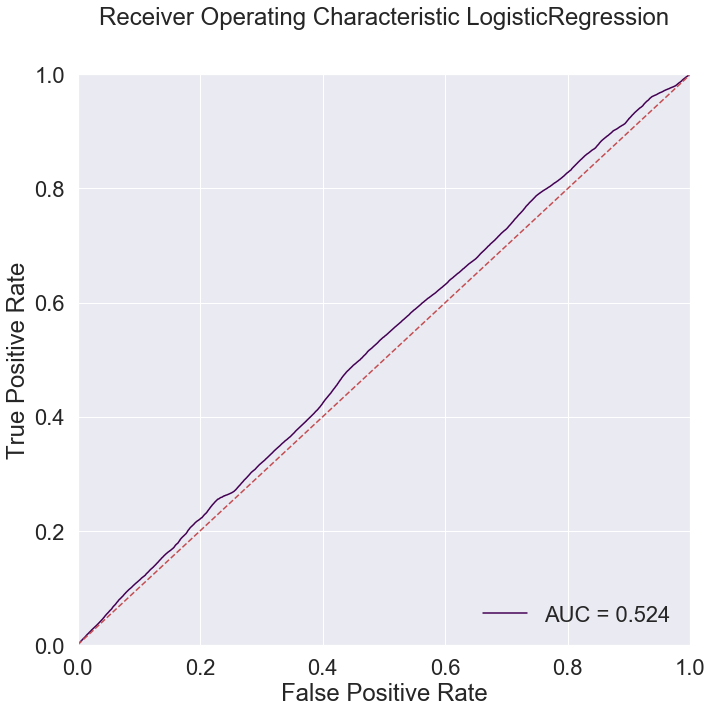

ROC-AUC Score: 0.5240130949871942
Accuracy Score: 0.499848


In [68]:
test_preds_log_reg = log_reg_clf.predict_proba(X_test)[:,1]
train_pred_vals_log_reg = log_reg_clf.predict(X_train)
test_pred_vals_log_reg = log_reg_clf.predict(X_test)
accuracy_log_reg = log_reg_clf.score(X_test, Y_test)
roc_auc_log_reg = roc_auc_score(Y_test, test_preds_log_reg)
plot_roc_curve(Y_test, [test_preds_log_reg], "LogisticRegression")
print('ROC-AUC Score:', roc_auc_log_reg)
print('Accuracy Score:', accuracy_log_reg)

In [70]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train_LogisticRegression:")
print(classification_report(Y_train, train_pred_vals_log_reg, target_names=target_names))
print('Test_LogisticRegression:')
print(classification_report(Y_test, test_pred_vals_log_reg, target_names=target_names))

Train_LogisticRegression:
                   precision    recall  f1-score   support

HasDetections = 0       0.00      0.00      0.00    500113
HasDetections = 1       0.50      1.00      0.67    499887

        micro avg       0.50      0.50      0.50   1000000
        macro avg       0.25      0.50      0.33   1000000
     weighted avg       0.25      0.50      0.33   1000000

Test_LogisticRegression:
                   precision    recall  f1-score   support

HasDetections = 0       0.00      0.00      0.00    125038
HasDetections = 1       0.50      1.00      0.67    124962

        micro avg       0.50      0.50      0.50    250000
        macro avg       0.25      0.50      0.33    250000
     weighted avg       0.25      0.50      0.33    250000



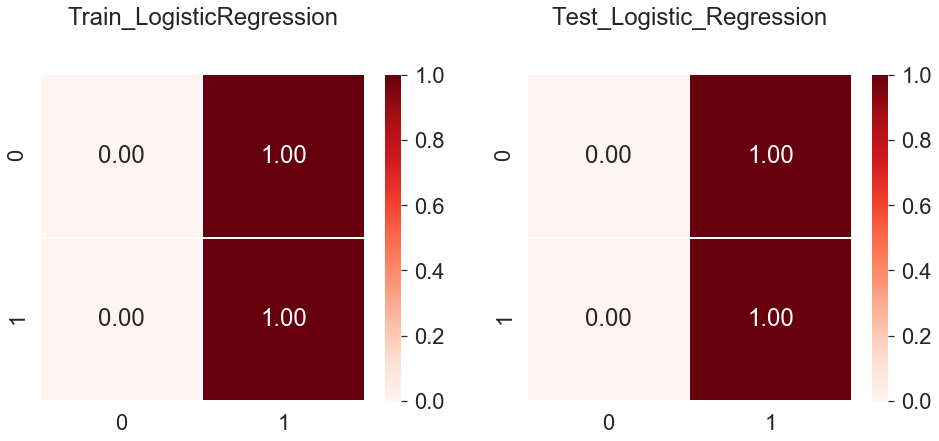

In [81]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_pred_vals_log_reg)
test_cnf_matrix = confusion_matrix(Y_test, test_pred_vals_log_reg)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

#sns.set(font_scale=2)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0], linewidths=0.6).set_title("Train_LogisticRegression")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1], linewidths=0.6).set_title("Test_Logistic_Regression")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

- So for logistic regression we are getting almost the same score we would have gotten for random guessing. AUC is just above 0.5, which is not good at all!
- The model just predicts all machines HasDetection! So, it has not been able to learn any useful relationship
- It also shows that there isn't a linear relationship between the features and the target.

## B. Decision Tree
- Our second choice is the Decision Tree. This classifier is sometimes able to work on tabular data well, and also it is very fast to train.

In [82]:
num_splits = 5
cv = StratifiedKFold(n_splits=num_splits, random_state=1234, shuffle=True)

- We try to test different variants by varying the hyperparameter *min samples at leaf*.

#### Min samples at leaf = 1

In [83]:
dec_tree_clf_1 = DecisionTreeClassifier(min_samples_leaf=1)

In [84]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    dec_tree_clf_1.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', dec_tree_clf_1.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', dec_tree_clf_1.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.999992499990625
Fold validation Score: 0.5680171599142004
Fold Train Score: 0.9999937499921875
Fold validation Score: 0.5671221643891781
Fold Train Score: 0.99998875
Fold validation Score: 0.567575
Fold Train Score: 0.9999962500046875
Fold validation Score: 0.5692678463392317
Fold Train Score: 0.9999887500140625
Fold validation Score: 0.5682278411392057


In [85]:
#print(dec_tree_clf_1.score(X_test, Y_test))
train_pred_vals_tree_1 = dec_tree_clf_1.predict(X_train)
test_pred_vals_tree_1 = dec_tree_clf_1.predict(X_test)
test_preds_tree_1 = dec_tree_clf_1.predict_proba(X_test)[:,1]
#plot_roc_curve(Y_test, test_preds, "DecisionTreeClassifier_1")
roc_auc_tree_1 = roc_auc_score(Y_test, test_preds_tree_1)
accuracy_tree_1 = dec_tree_clf_1.score(X_test, Y_test)
acc_train_tree_1 = dec_tree_clf_1.score(X_train, Y_train)

- Clearly we are overfitting.

#### Min samples at leaf = 20

In [86]:
dec_tree_clf_20 = DecisionTreeClassifier(min_samples_leaf=20)

In [87]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    dec_tree_clf_20.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', dec_tree_clf_20.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', dec_tree_clf_20.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.7400671750839689
Fold validation Score: 0.5938570307148464
Fold Train Score: 0.7409459261824077
Fold validation Score: 0.5957770211148944
Fold Train Score: 0.74108375
Fold validation Score: 0.59532
Fold Train Score: 0.74076282404647
Fold validation Score: 0.594317971589858
Fold Train Score: 0.7403390745761568
Fold validation Score: 0.5941329706648534


In [88]:
train_pred_vals_tree_20 = dec_tree_clf_20.predict(X_train)
test_pred_vals_tree_20 = dec_tree_clf_20.predict(X_test)
test_preds_tree_20 = dec_tree_clf_20.predict_proba(X_test)[:,1]
#plot_roc_curve(Y_test, test_preds, "DecisionTreeClassifier_20")
roc_auc_tree_20 = roc_auc_score(Y_test, test_preds_tree_20)
accuracy_tree_20 = dec_tree_clf_20.score(X_test, Y_test)
acc_train_tree_20 = dec_tree_clf_1.score(X_train, Y_train)

#### Min samples at leaf = 40

In [89]:
dec_tree_clf_40 = DecisionTreeClassifier(min_samples_leaf=40)

In [90]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    dec_tree_clf_40.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', dec_tree_clf_40.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', dec_tree_clf_40.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.7004221255276569
Fold validation Score: 0.6080019599902
Fold Train Score: 0.7003458754323443
Fold validation Score: 0.6076319618401907
Fold Train Score: 0.70111875
Fold validation Score: 0.60888
Fold Train Score: 0.7006703741620323
Fold validation Score: 0.6094980474902375
Fold Train Score: 0.7006028742464072
Fold validation Score: 0.6067030335151675


In [91]:
train_pred_vals_tree_40 = dec_tree_clf_40.predict(X_train)
test_pred_vals_tree_40 = dec_tree_clf_40.predict(X_test)
test_preds_tree_40 = dec_tree_clf_40.predict_proba(X_test)[:,1]
#plot_roc_curve(Y_test, test_preds, "DecisionTreeClassifier_40")
roc_auc_tree_40 = roc_auc_score(Y_test, test_preds_tree_40)
accuracy_tree_40 = dec_tree_clf_40.score(X_test, Y_test)
acc_train_tree_40 = dec_tree_clf_40.score(X_train, Y_train)

- It is very clear that min samples at leaf 40 gives the best result. It improves the generalization of the model.
- So we choose it as our DecisionTree classifier.

### Compare performances of the different trees to see that our choice of 40 was indeed optimal.

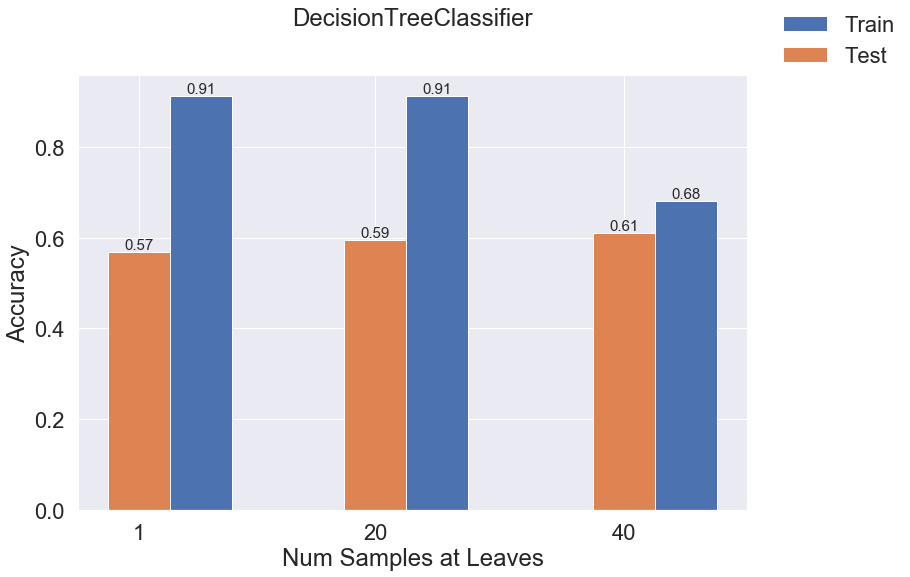

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#sns.barplot(ax=ax, y=col, x='HasDetections', data=df_1, order=df_1[col])
width=5
bars1 = ax.bar(x=[1+width,20+width,40+width], height=[acc_train_tree_1, acc_train_tree_20, acc_train_tree_40], width=width)
bars2 = ax.bar(x=[1,20,40], height=[accuracy_tree_1, accuracy_tree_20, accuracy_tree_40], width=width)
ax.set_xticks([1,20,40])
#ax.annotate('{}'.format(p.get_height()),(p.get_x(), p.get_height()))
ax.legend( (bars1[0], bars2[0]), ('Train', 'Test') , loc=(1.04,1))
plt.xlabel('Num Samples at Leaves')
plt.ylabel('Accuracy')
plt.title('DecisionTreeClassifier')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.2f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
plt.show()

#### Plot the ROC curve for the decision trees

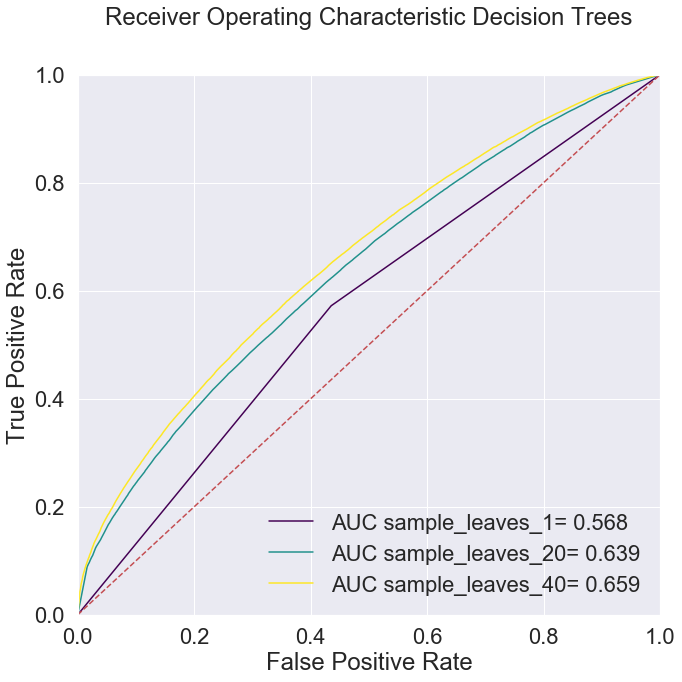

In [93]:
list_preds = [test_preds_tree_1, test_preds_tree_20, test_preds_tree_40]
plot_roc_curve(Y_test, list_preds, title_text="Decision Trees", label_txts=['sample_leaves_1', 'sample_leaves_20', 'sample_leaves_40'])

- Check the performance of the selected model (min samples at leaf 40)

In [94]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train_DecisionTree:")
print(classification_report(Y_train, train_pred_vals_tree_40, target_names=target_names))
print('Test_DecisionTree:')
print(classification_report(Y_test, test_pred_vals_tree_40, target_names=target_names))

Train_DecisionTree:
                   precision    recall  f1-score   support

HasDetections = 0       0.67      0.70      0.69    500113
HasDetections = 1       0.69      0.66      0.68    499887

        micro avg       0.68      0.68      0.68   1000000
        macro avg       0.68      0.68      0.68   1000000
     weighted avg       0.68      0.68      0.68   1000000

Test_DecisionTree:
                   precision    recall  f1-score   support

HasDetections = 0       0.61      0.63      0.62    125038
HasDetections = 1       0.61      0.59      0.60    124962

        micro avg       0.61      0.61      0.61    250000
        macro avg       0.61      0.61      0.61    250000
     weighted avg       0.61      0.61      0.61    250000



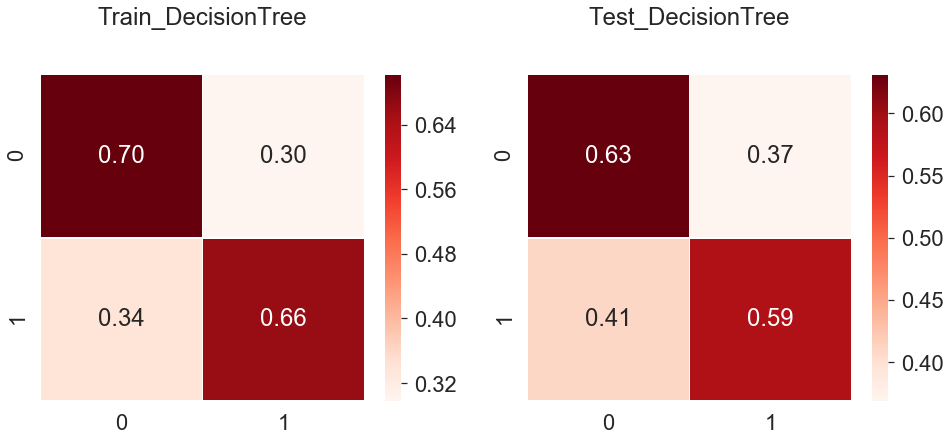

In [95]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_pred_vals_tree_40)
test_cnf_matrix = confusion_matrix(Y_test, test_pred_vals_tree_40)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

#sns.set(font_scale=2)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0], linewidths=0.6).set_title("Train_DecisionTree")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1], linewidths=0.6).set_title("Test_DecisionTree")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

- We have much better performance now!
- The tree is predicting more machines as not having malware. The x-axis is **Predictions** and y-axis is **True Labels**.
- We see that the Negative Predicting Value (NPV) is higher, which means that we have a higher **False Omission Rate**.

## C. Random Forest
- Next we try ensemble methods. One of the most versatile ensemble tree methods is the Random Forest. We try to see if we can improve our performance beyond the Decision Tree.

In [96]:
num_splits = 5
cv = StratifiedKFold(n_splits=num_splits, random_state=1234, shuffle=True)

- We try to vary the hyperparameter num_estimators. We fix the num samples at leaf at 40 (same as decision tree).

#### a. Num estimators: 10

In [97]:
rand_for_clf_10 = RandomForestClassifier(n_estimators=10, min_samples_leaf=40, max_features='auto', n_jobs=-1, oob_score=False, verbose=0)

In [98]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    rand_for_clf_10.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', rand_for_clf_10.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', rand_for_clf_10.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.6881371101713877
Fold validation Score: 0.6399468002659987
Fold Train Score: 0.6890421113026391
Fold validation Score: 0.6390168049159755
Fold Train Score: 0.6885825
Fold validation Score: 0.6384
Fold Train Score: 0.6883603895495131
Fold validation Score: 0.6378231891159456
Fold Train Score: 0.6893478883151396
Fold validation Score: 0.6405782028910144


In [99]:
train_pred_vals_for_10 = rand_for_clf_10.predict(X_train)
test_pred_vals_for_10 = rand_for_clf_10.predict(X_test)
test_preds_for_10 = rand_for_clf_10.predict_proba(X_test)[:,1]
#plot_roc_curve(Y_test, test_preds, "RandomForestClassifier")
roc_auc_forest_10 = roc_auc_score(Y_test, test_preds_for_10)
accuracy_forest_10 = rand_for_clf_10.score(X_test, Y_test)
train_accuracy_forest_10 = rand_for_clf_10.score(X_train, Y_train)

#### b. Num estimators: 25

In [100]:
rand_for_clf_25 = RandomForestClassifier(n_estimators=25, min_samples_leaf=40, max_features='auto', n_jobs=-1, oob_score=False, verbose=0)

In [101]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    rand_for_clf_25.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', rand_for_clf_25.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', rand_for_clf_25.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.6960858701073376
Fold validation Score: 0.6428017859910701
Fold Train Score: 0.6954821193526491
Fold validation Score: 0.6430667846660767
Fold Train Score: 0.696265
Fold validation Score: 0.64218
Fold Train Score: 0.6959691300385874
Fold validation Score: 0.6426132130660653
Fold Train Score: 0.6963891295135881
Fold validation Score: 0.6425032125160626


In [102]:
train_pred_vals_for_25 = rand_for_clf_25.predict(X_train)
test_pred_vals_for_25 = rand_for_clf_25.predict(X_test)
test_preds_for_25 = rand_for_clf_25.predict_proba(X_test)[:,1]
#plot_roc_curve(Y_test, test_preds, "RandomForestClassifier")
roc_auc_forest_25 = roc_auc_score(Y_test, test_preds_for_25)
accuracy_forest_25 = rand_for_clf_25.score(X_test, Y_test)
train_accuracy_forest_25 = rand_for_clf_25.score(X_train, Y_train)

#### c. Num estimators: 50

In [103]:
rand_for_clf_50 = RandomForestClassifier(n_estimators=50, min_samples_leaf=40, max_features='auto', n_jobs=-1, oob_score=False, verbose=0)

In [104]:
for (train, test) in (list(cv.split(X_train, Y_train))):
    rand_for_clf_50.fit(X_train.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', rand_for_clf_50.score(X_train.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', rand_for_clf_50.score(X_train.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.6994896243620304
Fold validation Score: 0.6437567812160939
Fold Train Score: 0.6984046230057788
Fold validation Score: 0.6441367793161035
Fold Train Score: 0.69874
Fold validation Score: 0.64371
Fold Train Score: 0.6990666261667173
Fold validation Score: 0.6444332221661109
Fold Train Score: 0.6993691257885928
Fold validation Score: 0.6446532232661163


In [105]:
train_pred_vals_for_50 = rand_for_clf_50.predict(X_train)
test_pred_vals_for_50 = rand_for_clf_50.predict(X_test)
test_preds_for_50 = rand_for_clf_50.predict_proba(X_test)[:,1]
#plot_roc_curve(Y_test, test_preds, "RandomForestClassifier")
roc_auc_forest_50 = roc_auc_score(Y_test, test_preds_for_50)
accuracy_forest_50 = rand_for_clf_50.score(X_test, Y_test)
train_accuracy_forest_50 = rand_for_clf_50.score(X_train, Y_train)

- Clearly the model with 50 estimators is the better one. This gives us the best generalizability.
- We select this as our best Random Forest Classifier.

#### Plot accuracies of the different Forest models

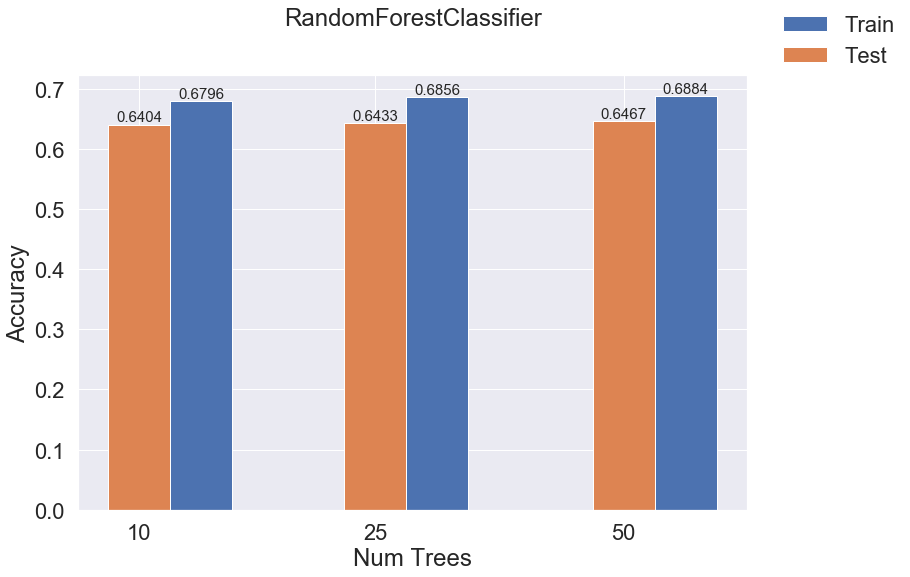

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
#sns.barplot(ax=ax, y=col, x='HasDetections', data=df_1, order=df_1[col])
width=5
bars1 = ax.bar(x=[1+width,20+width,40+width], height=[train_accuracy_forest_10, train_accuracy_forest_25, train_accuracy_forest_50], width=width)
bars2 = ax.bar(x=[1,20,40], height=[accuracy_forest_10, accuracy_forest_25, accuracy_forest_50], width=width)
ax.set_xticks([1,20,40])
ax.set_xticklabels([10,25,50])
#ax.annotate('{}'.format(p.get_height()),(p.get_x(), p.get_height()))
ax.legend((bars1[0], bars2[0]), ('Train', 'Test'), loc=(1.04,1))
plt.xlabel('Num Trees')
plt.ylabel('Accuracy')
plt.title('RandomForestClassifier')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
#plt.legend(loc=(1.04,0))
plt.show()

#### Now plot ROC for all the forests.

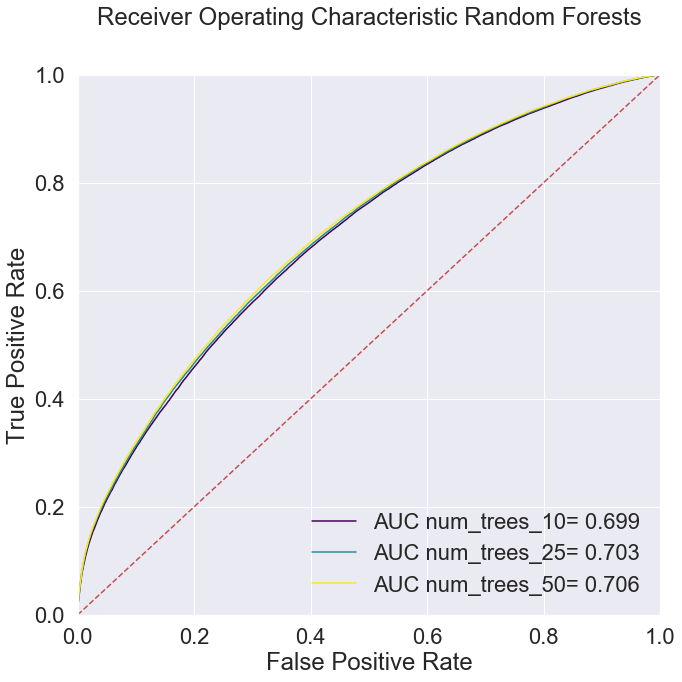

In [107]:
list_preds = [test_preds_for_10, test_preds_for_25, test_preds_for_50]
plot_roc_curve(Y_test, list_preds, title_text="Random Forests", label_txts=['num_trees_10', 'num_trees_25', 'num_trees_50'])

- We see that when we set num trees as 50, we get the higher AUC and accuracy.

### Let us compare ROC of the Logistic Regression, Decision Tree and Random Forest

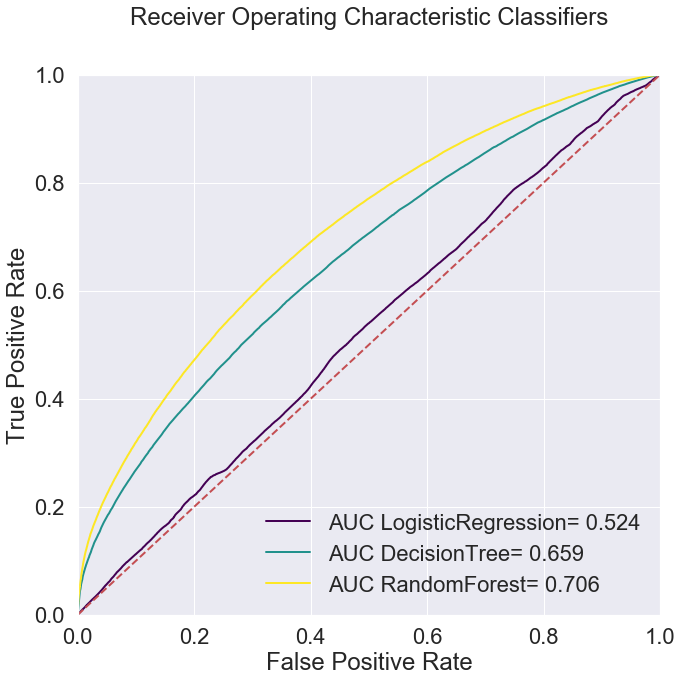

In [108]:
plt.rcParams['lines.linewidth'] = 2.0

list_preds = [test_preds_log_reg, test_preds_tree_40, test_preds_for_50]
plot_roc_curve(Y_test, list_preds, title_text="Classifiers", label_txts=['LogisticRegression', 'DecisionTree', 'RandomForest'])

In [110]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train_RandomForest:")
print(classification_report(Y_train, train_pred_vals_for_50, target_names=target_names))
print('Test_RandomForest:')
print(classification_report(Y_test, test_pred_vals_for_50, target_names=target_names))

Train_RandomForest:
                   precision    recall  f1-score   support

HasDetections = 0       0.69      0.70      0.69    500113
HasDetections = 1       0.69      0.68      0.69    499887

        micro avg       0.69      0.69      0.69   1000000
        macro avg       0.69      0.69      0.69   1000000
     weighted avg       0.69      0.69      0.69   1000000

Test_RandomForest:
                   precision    recall  f1-score   support

HasDetections = 0       0.64      0.65      0.65    125038
HasDetections = 1       0.65      0.64      0.64    124962

        micro avg       0.65      0.65      0.65    250000
        macro avg       0.65      0.65      0.65    250000
     weighted avg       0.65      0.65      0.65    250000



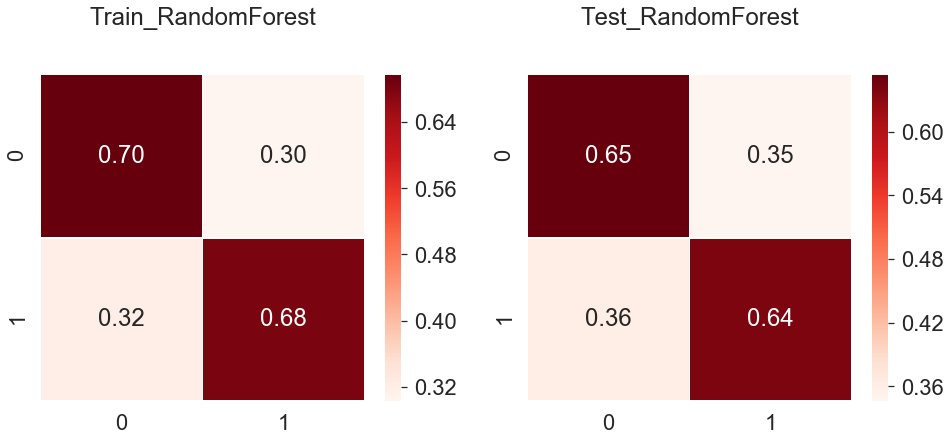

In [111]:
f, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, train_pred_vals_for_50)
test_cnf_matrix = confusion_matrix(Y_test, test_pred_vals_for_50)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

#sns.set(font_scale=2)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0], linewidths=0.6).set_title("Train_RandomForest")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1], linewidths=0.6).set_title("Test_RandomForest")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

- We have already improved a lot. See that this model has more balanced prediction of both classes. The AUC is also more improved. The NPV and PPV are more balanced now than the decision tree.

### The RandomForestClassifier is our best classifier so far. Let us see which features are "important" to the classifier we fit.

In [94]:
num_trees = 50
num_rows = num_trees * len(X_train.columns)
feat_imp = pd.DataFrame(index=np.arange(0, num_rows), columns=('feature', 'importance'), dtype=float)
i = 0
# Go through all the trees in the forest
for estimator in rand_for_clf_50.estimators_:
    for j in range(len(X_train.columns)):
        feat_imp.loc[i] = [X_train.columns[j], estimator.feature_importances_[j]]
        i += 1
#feat_imp.head(10)

best_features = feat_imp.groupby("feature").mean().sort_values(by="importance", ascending=False)
best_features

importance
feature                                                      
SmartScreen                                          0.213674
AVProductStatesIdentifier                            0.081009
AVProductsInstalled                                  0.051839
AvSigVersion                                         0.043330
EngineVersion                                        0.040679
Census_SystemVolumeTotalCapacity                     0.029973
AppVersion                                           0.024218
CityIdentifier                                       0.023951
Census_FirmwareVersionIdentifier                     0.023719
Census_OEMModelIdentifier                            0.023604
Census_InternalPrimaryDiagonalDisplaySizeInInches    0.022948
Census_ProcessorModelIdentifier                      0.022645
CountryIdentifier                                    0.022588
Census_TotalPhysicalRAM                              0.020926
Census_PrimaryDiskTotalCapacity                      0.020194
Census_OSInstallTypeName                             0.018385
Census_OSVersion                                     0.016921
Census_OSBuildRevision                               0.016554
GeoNameIdentifier                                    0.015177
LocaleEnglishNameIdentifier                          0.014271
Wdft_IsGamer                                         0.013635
Census_OEMNameIdentifier                             0.013466
Wdft_RegionIdentifier                                0.013334
Census_OSInstallLanguageIdentifier                   0.013093
Census_OSUILocaleIdentifier                          0.012587
OsBuildLab                                           0.011051
Census_FirmwareManufacturerIdentifier                0.010513
IeVerIdentifier                                      0.008490
Census_ActivationChannel                             0.008126
Census_ProcessorCoreCount                            0.007915
...                                                       ...
SMode                                                0.003924
Census_OSBuildNumber                                 0.003706
RtpStateBitfield                                     0.003662
Census_OSArchitecture                                0.003593
Census_IsAlwaysOnAlwaysConnectedCapable              0.003553
Census_IsWIMBootEnabled                              0.003434
Census_ThresholdOptIn                                0.003363
Census_IsSecureBootEnabled                           0.003320
Census_PrimaryDiskTypeName                           0.003150
IsProtected                                          0.003073
Census_IsTouchEnabled                                0.002818
SkuEdition                                           0.002580
Census_GenuineStateName                              0.002413
OsSuite                                              0.002333
IsSxsPassiveMode                                     0.001278
Census_HasOpticalDiskDrive                           0.001259
Census_ProcessorManufacturerIdentifier               0.000980
Platform                                             0.000808
Census_FlightRing                                    0.000764
Firewall                                             0.000701
OsVer                                                0.000495
HasTpm                                               0.000438
Census_IsPenCapable                                  0.000344
ProductName                                          0.000298
Census_DeviceFamily                                  0.000198
Census_IsFlightsDisabled                             0.000126
UacLuaenable                                         0.000033
Census_IsPortableOperatingSystem                     0.000000
AutoSampleOptIn                                      0.000000
IsBeta                                               0.000000

[76 rows x 1 columns]

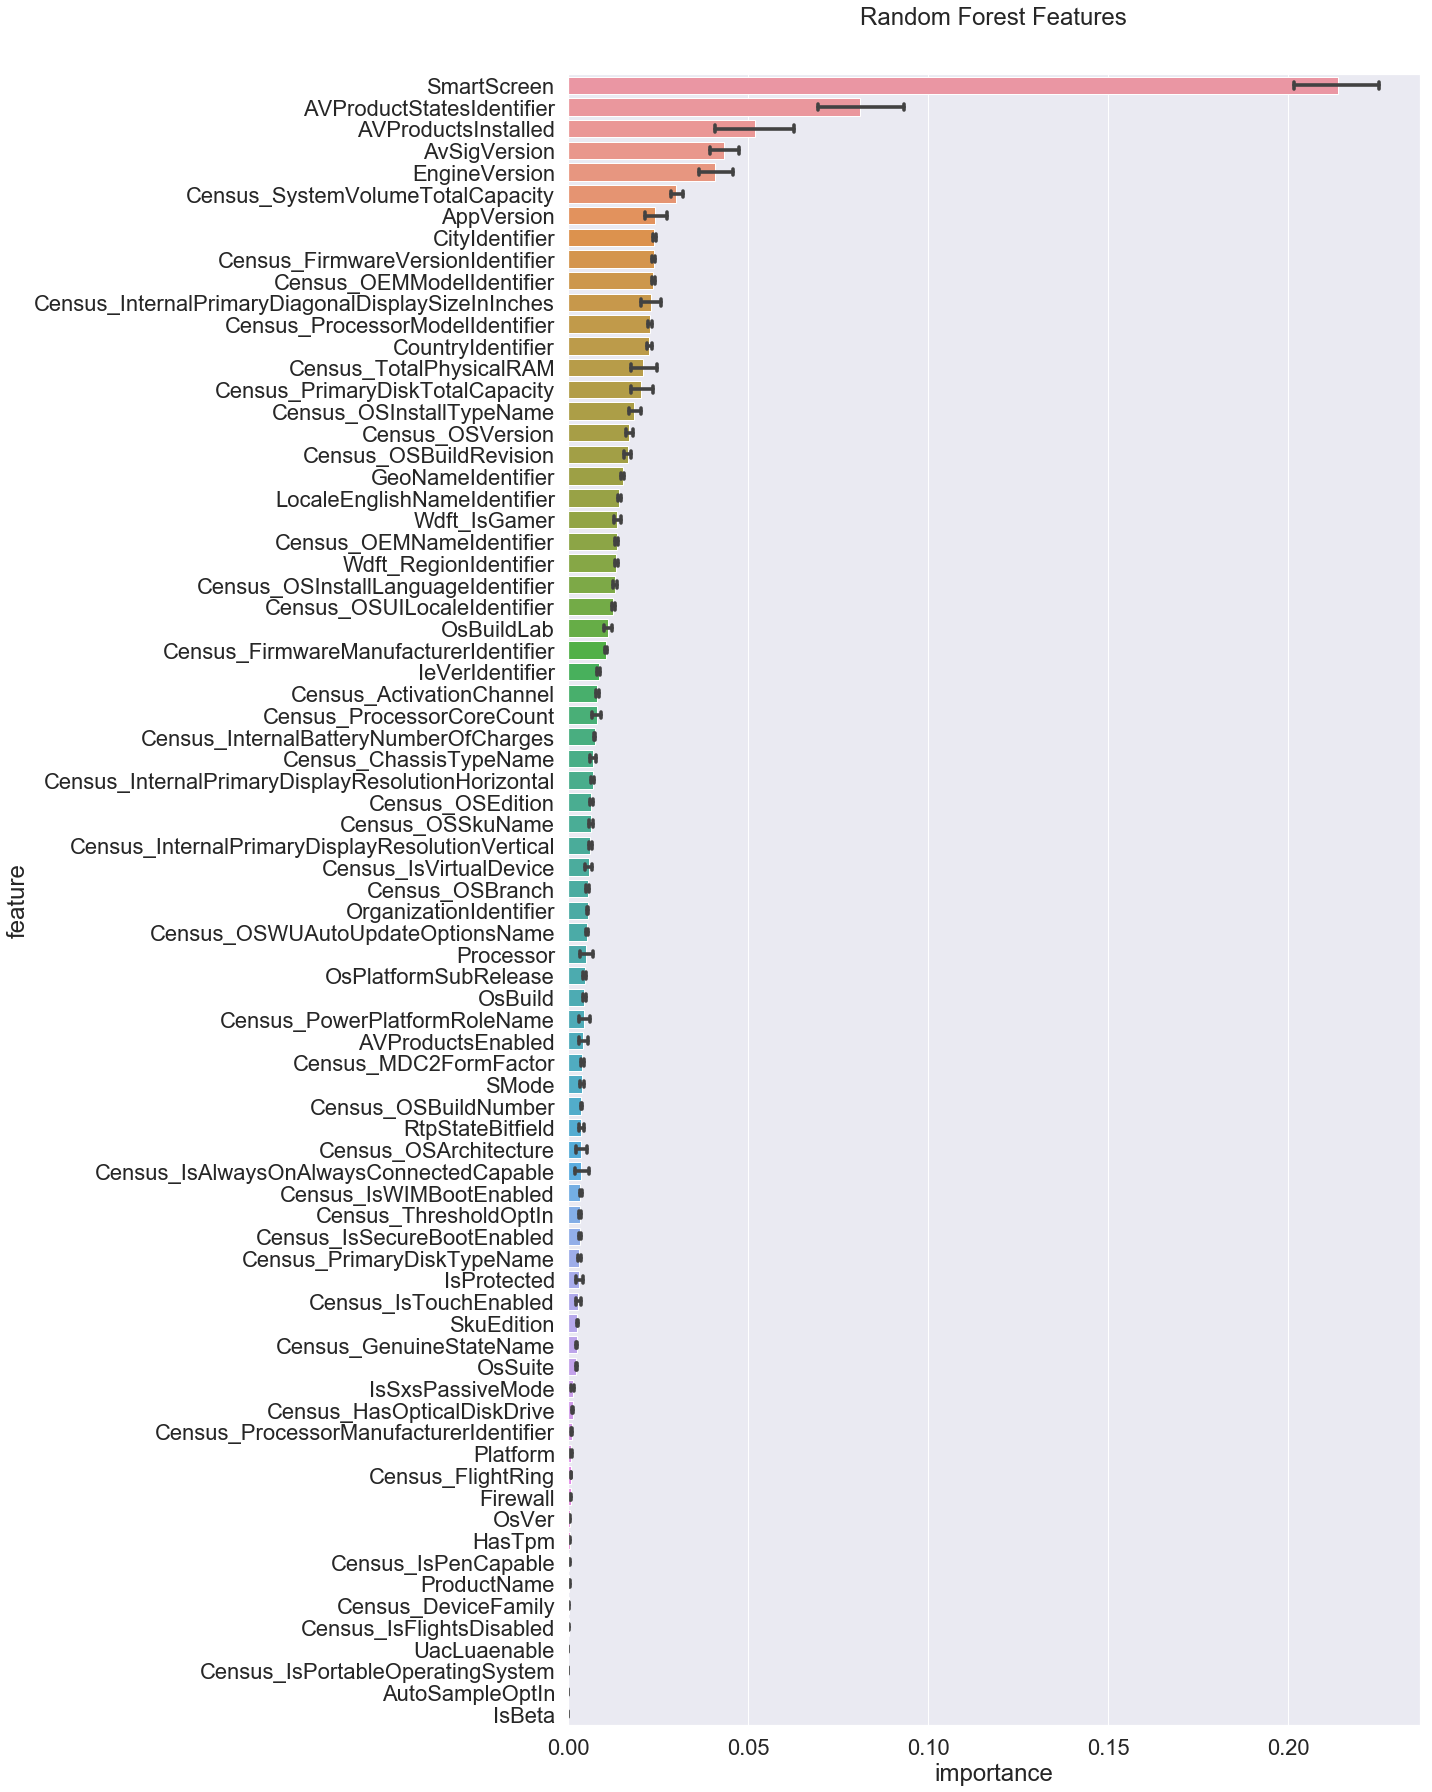

In [95]:
plt.figure(figsize=(20,25))
sns.barplot(x="importance",
            y="feature",
            data=feat_imp,
            order=list(best_features.index),
            capsize=.3)
plt.title('Random Forest Features')
plt.tight_layout()

- This plot gives a clear indication of which features are more important to the RandomForest. The importance is computed with respect to the gain due to splits of that feature.
- We see features like SmartScreen, AVProductStatesIdentifier, AVProductsInstalled at the top. These are all related to Antivirus or related settings, and hence expected to be relevant features.
- **Census_GenuineStateName** and **Firewall** are not deemed as important! So the system settings related to these **do not** affect the prediction to a high extent.

## D: LGBM Model
- Now we try a model that is relatively new and is currently extremely popular in Kaggle. This is the Light Gradient Boosting Model, based on this paper (https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf). 
- Also mentioned here: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [115]:
# train and validation split
X_tr_lgbm, X_val_lgbm, Y_tr_lgbm, Y_val_lgbm = train_test_split(X_train, Y_train, test_size=0.1)
print("train set:", X_tr_lgbm.shape)
print("validation set:", X_val_lgbm.shape)
print("test set:", X_test.shape)

lgb_train = lgb.Dataset(X_tr_lgbm, label=Y_tr_lgbm)
lgb_val = lgb.Dataset(X_val_lgbm, label=Y_val_lgbm)

train set: (900000, 76)
validation set: (100000, 76)
test set: (250000, 76)


- LightGBM has a lot of hyperparamters to tune and tuning it properly is quite vital for proper performance.
- We first try to vary the num_leaves parameter.
- We also vary the min_data_in_leaf parameter.
- We follow this for hyperparameter tuning. https://sites.google.com/view/lauraepp/parameters

### D.1: LGBM model1(Hyperparameter:params1)

In [116]:
params1 = {
    'num_leaves': 100,   #150, 200, 255
     'min_data_in_leaf': 100, # can increase to 500 and 1000 
     'objective':'binary',
     'max_depth': 8,
     'learning_rate': 0.05,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "bagging_freq": 5,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 11,
     "metric": 'auc',
     "lambda_l1": 1e-06,
     "random_state": 133,
     "verbosity": 100 }
lgbm_model_1 = lgb.train(params1, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.71369	valid_1's auc: 0.708336
[200]	training's auc: 0.725544	valid_1's auc: 0.715714
[300]	training's auc: 0.73325	valid_1's auc: 0.719486
[400]	training's auc: 0.739874	valid_1's auc: 0.722151
[500]	training's auc: 0.745006	valid_1's auc: 0.723381
[600]	training's auc: 0.749709	valid_1's auc: 0.72426
[700]	training's auc: 0.753577	valid_1's auc: 0.724861
[800]	training's auc: 0.757635	valid_1's auc: 0.725422
[900]	training's auc: 0.761654	valid_1's auc: 0.725839
[1000]	training's auc: 0.765319	valid_1's auc: 0.726343
[1100]	training's auc: 0.768937	valid_1's auc: 0.726507
[1200]	training's auc: 0.772586	valid_1's auc: 0.726636
[1300]	training's auc: 0.775915	valid_1's auc: 0.726853
[1400]	training's auc: 0.779061	valid_1's auc: 0.726979
[1500]	training's auc: 0.78221	valid_1's auc: 0.727048
[1600]	training's auc: 0.785136	valid_1's auc: 0.727075
[1700]	training's auc: 0.788027	valid_1's auc: 0.72708

In [167]:
train_predictions_leafs_100 = lgbm_model_1.predict(X_tr_lgbm, num_iteration=lgbm_model_1.best_iteration)
test_predictions_leafs_100 = lgbm_model_1.predict(X_test, num_iteration=lgbm_model_1.best_iteration)
val_predictions_leafs_100 = lgbm_model_1.predict(X_val_lgbm, num_iteration=lgbm_model_1.best_iteration)

train_preds_leafs_100 = np.rint(train_predictions_leafs_100)
test_preds_leafs_100 = np.rint(test_predictions_leafs_100)
val_preds_leafs_100 = np.rint(val_predictions_leafs_100)

In [168]:
train_roc_leafs_100 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_100)
test_roc_leafs_100 = roc_auc_score(Y_test, test_predictions_leafs_100)
train_accu_leafs_100 = accuracy_score(Y_tr_lgbm, train_preds_leafs_100)
test_accu_leafs_100 = accuracy_score(Y_test, test_preds_leafs_100)
val_roc_leafs_100 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_100)
val_accu_leafs_100 = accuracy_score(Y_val_lgbm, val_preds_leafs_100)
print("Train AUC Score: %0.4f" %train_roc_leafs_100)
print("Validation AUC Score: %0.4f" %val_roc_leafs_100)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_100)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_100)

Train AUC Score: 0.7864
Validation AUC Score: 0.7271
Train Accuracy Score: 0.7082
Validation Accuracy Score: 0.6618


### D.2: LGBM model2(Hyperparameter:params2)

In [125]:

params2 = {
    'num_leaves': 150,   #150, 200, 255
     'min_data_in_leaf': 100, # can increase to 500 and 1000 
     'objective':'binary',
     'max_depth': 8,
     'learning_rate': 0.05,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "bagging_freq": 1,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 11,
     "metric": 'auc',
     "lambda_l1": 0.5,
     "random_state": 133,
     "verbosity": 100 }


lgbm_model_2 = lgb.train(params2, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.716613	valid_1's auc: 0.708951
[200]	training's auc: 0.729364	valid_1's auc: 0.716458
[300]	training's auc: 0.738155	valid_1's auc: 0.720283
[400]	training's auc: 0.745175	valid_1's auc: 0.722708
[500]	training's auc: 0.75091	valid_1's auc: 0.723999
[600]	training's auc: 0.756271	valid_1's auc: 0.724948
[700]	training's auc: 0.760943	valid_1's auc: 0.725611
[800]	training's auc: 0.765562	valid_1's auc: 0.726014
[900]	training's auc: 0.769942	valid_1's auc: 0.726505
[1000]	training's auc: 0.773904	valid_1's auc: 0.726655
[1100]	training's auc: 0.77761	valid_1's auc: 0.726898
[1200]	training's auc: 0.781606	valid_1's auc: 0.727024
[1300]	training's auc: 0.785297	valid_1's auc: 0.727103
[1400]	training's auc: 0.788899	valid_1's auc: 0.72713
[1500]	training's auc: 0.792297	valid_1's auc: 0.727009
[1600]	training's auc: 0.795462	valid_1's auc: 0.727124
[1700]	training's auc: 0.798651	valid_1's auc: 0.7271

In [126]:
train_predictions_leafs_150 = lgbm_model_2.predict(X_tr_lgbm, num_iteration=lgbm_model_2.best_iteration)
test_predictions_leafs_150 = lgbm_model_2.predict(X_test, num_iteration=lgbm_model_2.best_iteration)
val_predictions_leafs_150 = lgbm_model_2.predict(X_val_lgbm, num_iteration=lgbm_model_2.best_iteration)

train_preds_leafs_150 = np.rint(train_predictions_leafs_150)
test_preds_leafs_150 = np.rint(test_predictions_leafs_150)
val_preds_leafs_150 = np.rint(val_predictions_leafs_150)

In [130]:
train_roc_leafs_150 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_150)
test_roc_leafs_150 = roc_auc_score(Y_test, test_predictions_leafs_150)
val_roc_leafs_150 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_150)
train_accu_leafs_150 = accuracy_score(Y_tr_lgbm, train_preds_leafs_150)
test_accu_leafs_150 = accuracy_score(Y_test, test_preds_leafs_150)
val_accu_leafs_150 = accuracy_score(Y_val_lgbm, val_preds_leafs_150)
print("Train AUC Score: %0.4f" %train_roc_leafs_150)
print("Validation AUC Score: %0.4f" %val_roc_leafs_150)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_150)
print("Validation AUC Score: %0.4f" %val_accu_leafs_150)

Train AUC Score: 0.7983
Validation AUC Score: 0.7272
Train Accuracy Score: 0.7186
Validation AUC Score: 0.6620


### D.3: LGBM model3(Hyperparameter:params3)

In [134]:
params3 = {
    'num_leaves': 200,   #150, 200, 255
     'min_data_in_leaf': 100, # can increase to 500 and 1000 
     'objective':'binary',
     'max_depth': 8,
     'learning_rate': 0.05,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "bagging_freq": 5,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 11,
     "metric": 'auc',
     "lambda_l1": 1e-06,
     "random_state": 133,
     "verbosity": 100 }



lgbm_model_3 = lgb.train(params3, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.718357	valid_1's auc: 0.709323
[200]	training's auc: 0.73131	valid_1's auc: 0.716697
[300]	training's auc: 0.739478	valid_1's auc: 0.720432
[400]	training's auc: 0.746851	valid_1's auc: 0.722981
[500]	training's auc: 0.752168	valid_1's auc: 0.724269
[600]	training's auc: 0.757027	valid_1's auc: 0.725034
[700]	training's auc: 0.761373	valid_1's auc: 0.725623
[800]	training's auc: 0.765756	valid_1's auc: 0.726013
[900]	training's auc: 0.770229	valid_1's auc: 0.72645
[1000]	training's auc: 0.773922	valid_1's auc: 0.726612
[1100]	training's auc: 0.777584	valid_1's auc: 0.726914
[1200]	training's auc: 0.78147	valid_1's auc: 0.726943
[1300]	training's auc: 0.784811	valid_1's auc: 0.727219
[1400]	training's auc: 0.788228	valid_1's auc: 0.727404
[1500]	training's auc: 0.791549	valid_1's auc: 0.727486
[1600]	training's auc: 0.794617	valid_1's auc: 0.727321
[1700]	training's auc: 0.797528	valid_1's auc: 0.7272

In [135]:
train_predictions_leafs_200 = lgbm_model_3.predict(X_tr_lgbm, num_iteration=lgbm_model_3.best_iteration)
test_predictions_leafs_200 = lgbm_model_3.predict(X_test, num_iteration=lgbm_model_3.best_iteration)
val_predictions_leafs_200 = lgbm_model_3.predict(X_val_lgbm, num_iteration=lgbm_model_3.best_iteration)
train_preds_leafs_200 = np.rint(train_predictions_leafs_200)
test_preds_leafs_200 = np.rint(test_predictions_leafs_200)
val_preds_leafs_200 = np.rint(val_predictions_leafs_200)

In [138]:
train_roc_leafs_200 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_200)
test_roc_leafs_200 = roc_auc_score(Y_test, test_predictions_leafs_200)
val_roc_leafs_200 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_200)
train_accu_leafs_200 = accuracy_score(Y_tr_lgbm, train_preds_leafs_200)
test_accu_leafs_200 = accuracy_score(Y_test, test_preds_leafs_200)
val_accu_leafs_200 = accuracy_score(Y_val_lgbm, val_preds_leafs_200)
print("Train AUC Score: %0.4f" %train_roc_leafs_200)
print("Validation AUC Score: %0.4f" %val_roc_leafs_200)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_200)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_200)

Train AUC Score: 0.7918
Validation AUC Score: 0.7276
Train Accuracy Score: 0.7128
Validation Accuracy Score: 0.6623


### D.4: LGBM model4(Hyperparameter:params4)

In [140]:
params4 = {
    'num_leaves': 255,   #150, 200, 255
     'min_data_in_leaf': 100, # can increase to 500 and 1000 
     'objective':'binary',
     'max_depth': 8,
     'learning_rate': 0.05,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "bagging_freq": 5,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 11,
     "metric": 'auc',
     "lambda_l1": 1e-06,
     "random_state": 133,
     "verbosity": 100 }
lgbm_model_4 = lgb.train(params4, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.71891	valid_1's auc: 0.709583
[200]	training's auc: 0.731315	valid_1's auc: 0.7165
[300]	training's auc: 0.739775	valid_1's auc: 0.720388
[400]	training's auc: 0.746849	valid_1's auc: 0.722707
[500]	training's auc: 0.752168	valid_1's auc: 0.723687
[600]	training's auc: 0.757043	valid_1's auc: 0.72449
[700]	training's auc: 0.761326	valid_1's auc: 0.72501
[800]	training's auc: 0.765328	valid_1's auc: 0.725463
[900]	training's auc: 0.77007	valid_1's auc: 0.7261
[1000]	training's auc: 0.77362	valid_1's auc: 0.726251
[1100]	training's auc: 0.777164	valid_1's auc: 0.726253
[1200]	training's auc: 0.781075	valid_1's auc: 0.726391
[1300]	training's auc: 0.784595	valid_1's auc: 0.726461
[1400]	training's auc: 0.788091	valid_1's auc: 0.726666
[1500]	training's auc: 0.791481	valid_1's auc: 0.726701
[1600]	training's auc: 0.794677	valid_1's auc: 0.726728
[1700]	training's auc: 0.797663	valid_1's auc: 0.726778
[18

In [141]:
train_predictions_leafs_255 = lgbm_model_4.predict(X_tr_lgbm, num_iteration=lgbm_model_4.best_iteration)
test_predictions_leafs_255 = lgbm_model_4.predict(X_test, num_iteration=lgbm_model_4.best_iteration)
val_predictions_leafs_255 = lgbm_model_4.predict(X_val_lgbm, num_iteration=lgbm_model_4.best_iteration)

train_preds_leafs_255 = np.rint(train_predictions_leafs_255)
test_preds_leafs_255 = np.rint(test_predictions_leafs_255)
val_preds_leafs_255 = np.rint(val_predictions_leafs_255)

In [144]:
train_roc_leafs_255 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_255)
test_roc_leafs_255 = roc_auc_score(Y_test, test_predictions_leafs_255)
val_roc_leafs_255 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_255)
train_accu_leafs_255 = accuracy_score(Y_tr_lgbm, train_preds_leafs_255)
test_accu_leafs_255 = accuracy_score(Y_test, test_preds_leafs_255)
val_accu_leafs_255 = accuracy_score(Y_val_lgbm, val_preds_leafs_255)
print("Train AUC Score: %0.4f" %train_roc_leafs_255)
print("Validation AUC Score: %0.4f" %val_roc_leafs_255)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_255)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_255)

Train AUC Score: 0.7963
Validation AUC Score: 0.7269
Train Accuracy Score: 0.7166
Validation Accuracy Score: 0.6627


### D.5: LGBM model5(Hyperparameter:params5)


In [146]:
params5 = {'num_leaves': 30,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}


# 30 leaves
lgbm_model_5 = lgb.train(params5, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.713021	valid_1's auc: 0.710267
[200]	training's auc: 0.72198	valid_1's auc: 0.7164
[300]	training's auc: 0.727746	valid_1's auc: 0.719178
[400]	training's auc: 0.732509	valid_1's auc: 0.720773
[500]	training's auc: 0.73658	valid_1's auc: 0.721766
[600]	training's auc: 0.740467	valid_1's auc: 0.722563
[700]	training's auc: 0.743853	valid_1's auc: 0.723176
[800]	training's auc: 0.747218	valid_1's auc: 0.723616
[900]	training's auc: 0.75039	valid_1's auc: 0.724029
[1000]	training's auc: 0.75354	valid_1's auc: 0.724219
[1100]	training's auc: 0.756594	valid_1's auc: 0.724532
[1200]	training's auc: 0.759443	valid_1's auc: 0.724659
Early stopping, best iteration is:
[1187]	training's auc: 0.759071	valid_1's auc: 0.724679


In [147]:
train_predictions_leafs_30 = lgbm_model_5.predict(X_tr_lgbm, num_iteration=lgbm_model_5.best_iteration)
test_predictions_leafs_30 = lgbm_model_5.predict(X_test, num_iteration=lgbm_model_5.best_iteration)
val_predictions_leafs_30 = lgbm_model_5.predict(X_val_lgbm, num_iteration=lgbm_model_5.best_iteration)

train_preds_leafs_30 = np.rint(train_predictions_leafs_30)
test_preds_leafs_30 = np.rint(test_predictions_leafs_30)
val_preds_leafs_30 = np.rint(val_predictions_leafs_30)

In [150]:
train_roc_leafs_30 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_30)
test_roc_leafs_30 = roc_auc_score(Y_test, test_predictions_leafs_30)
val_roc_leafs_30 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_30)
train_accu_leafs_30 = accuracy_score(Y_tr_lgbm, train_preds_leafs_30)
test_accu_leafs_30 = accuracy_score(Y_test, test_preds_leafs_30)
val_accu_leafs_30 = accuracy_score(Y_val_lgbm, val_preds_leafs_30)
print("Train AUC Score: %0.4f" %train_roc_leafs_30)
print("Validation AUC Score: %0.4f" %val_roc_leafs_30)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_30)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_30)

Train AUC Score: 0.7591
Validation AUC Score: 0.7247
Train Accuracy Score: 0.6862
Validation Accuracy Score: 0.6602


### D.6: LGBM model6(Hyperparameter:params6)

In [152]:
# 10 leaves
params6 = {'num_leaves': 10,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.05,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}
lgbm_model_6 = lgb.train(params6, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=100, verbose_eval=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.689615	valid_1's auc: 0.689163
[200]	training's auc: 0.698364	valid_1's auc: 0.697585
[300]	training's auc: 0.703014	valid_1's auc: 0.701787
[400]	training's auc: 0.706356	valid_1's auc: 0.704813
[500]	training's auc: 0.70911	valid_1's auc: 0.707127
[600]	training's auc: 0.711306	valid_1's auc: 0.708917
[700]	training's auc: 0.713287	valid_1's auc: 0.71052
[800]	training's auc: 0.714869	valid_1's auc: 0.711725
[900]	training's auc: 0.716271	valid_1's auc: 0.712708
[1000]	training's auc: 0.717561	valid_1's auc: 0.713556
[1100]	training's auc: 0.71881	valid_1's auc: 0.714458
[1200]	training's auc: 0.719907	valid_1's auc: 0.71523
[1300]	training's auc: 0.720918	valid_1's auc: 0.715851
[1400]	training's auc: 0.721955	valid_1's auc: 0.716506
[1500]	training's auc: 0.722893	valid_1's auc: 0.717039
[1600]	training's auc: 0.723832	valid_1's auc: 0.717547
[1700]	training's auc: 0.724589	valid_1's auc: 0.71793

In [153]:
train_predictions_leafs_10 = lgbm_model_6.predict(X_tr_lgbm, num_iteration=lgbm_model_6.best_iteration)
test_predictions_leafs_10 = lgbm_model_6.predict(X_test, num_iteration=lgbm_model_6.best_iteration)
val_predictions_leafs_10 = lgbm_model_6.predict(X_val_lgbm, num_iteration=lgbm_model_6.best_iteration)

train_preds_leafs_10 = np.rint(train_predictions_leafs_10)
test_preds_leafs_10 = np.rint(test_predictions_leafs_10)
val_preds_leafs_10 = np.rint(val_predictions_leafs_10)

In [156]:
train_roc_leafs_10 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_10)
test_roc_leafs_10 = roc_auc_score(Y_test, test_predictions_leafs_10)
val_roc_leafs_10 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_10)
train_accu_leafs_10 = accuracy_score(Y_tr_lgbm, train_preds_leafs_10)
test_accu_leafs_10 = accuracy_score(Y_test, test_preds_leafs_10)
val_accu_leafs_10 = accuracy_score(Y_val_lgbm, val_preds_leafs_10)
print("Train AUC Score: %0.4f" %train_roc_leafs_10)
print("Validation AUC Score: %0.4f" %val_roc_leafs_10)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_10)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_10)

Train AUC Score: 0.7577
Validation AUC Score: 0.7256
Train Accuracy Score: 0.6852
Validation Accuracy Score: 0.6617


### D.7: LGBM model7(Hyperparameter:params7)

In [158]:
params7 = {'num_leaves': 10,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_7 = lgb.train(params7, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.698589	valid_1's auc: 0.697485
[200]	training's auc: 0.7064	valid_1's auc: 0.704786
[300]	training's auc: 0.711282	valid_1's auc: 0.709177
[400]	training's auc: 0.714469	valid_1's auc: 0.711465
[500]	training's auc: 0.717291	valid_1's auc: 0.71343
[600]	training's auc: 0.719892	valid_1's auc: 0.715157
[700]	training's auc: 0.721929	valid_1's auc: 0.716554
[800]	training's auc: 0.723743	valid_1's auc: 0.717628
[900]	training's auc: 0.725431	valid_1's auc: 0.718621
[1000]	training's auc: 0.72701	valid_1's auc: 0.719358
[1100]	training's auc: 0.728306	valid_1's auc: 0.719818
[1200]	training's auc: 0.729694	valid_1's auc: 0.720361
[1300]	training's auc: 0.730948	valid_1's auc: 0.720774
[1400]	training's auc: 0.732176	valid_1's auc: 0.721112
[1500]	training's auc: 0.733379	valid_1's auc: 0.721472
[1600]	training's auc: 0.734508	valid_1's auc: 0.721792
[1700]	training's auc: 0.735548	valid_1's auc: 0.72208

In [182]:
train_predictions_min_leaf_30 = lgbm_model_7.predict(X_tr_lgbm, num_iteration=lgbm_model_7.best_iteration)
test_predictions_min_leaf_30 = lgbm_model_7.predict(X_test, num_iteration=lgbm_model_7.best_iteration)
val_predictions_min_leaf_30 = lgbm_model_7.predict(X_val_lgbm, num_iteration=lgbm_model_7.best_iteration)

train_preds_min_leaf_30 = np.rint(train_predictions_min_leaf_30)
test_preds_min_leaf_30 = np.rint(test_predictions_min_leaf_30)
val_preds_min_leaf_30 = np.rint(val_predictions_min_leaf_30)

In [185]:
train_roc_min_leaf_30 = roc_auc_score(Y_tr_lgbm, train_predictions_min_leaf_30)
test_roc_min_leaf_30 = roc_auc_score(Y_test, test_predictions_min_leaf_30)
val_roc_min_leaf_30 = roc_auc_score(Y_val_lgbm, val_predictions_min_leaf_30)

train_accu_min_leaf_30 = accuracy_score(Y_tr_lgbm, train_preds_min_leaf_30)
test_accu_min_leaf_30 = accuracy_score(Y_test, test_preds_min_leaf_30)
val_accu_min_leaf_30 = accuracy_score(Y_val_lgbm, val_preds_min_leaf_30)
print("Train AUC Score: %0.4f" %train_roc_min_leaf_30)
print("Validation AUC Score: %0.4f" %val_roc_min_leaf_30)
print("Train Accuracy Score: %0.4f" %train_accu_min_leaf_30)
print("Validation Accuracy Score: %0.4f" %val_accu_min_leaf_30)

Train AUC Score: 0.7511
Validation AUC Score: 0.7246
Train Accuracy Score: 0.6800
Validation Accuracy Score: 0.6606


### D.8: LGBM model8(Hyperparameter:params8)

In [187]:
params8 = {'num_leaves': 10,
         'min_data_in_leaf': 10, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_8 = lgb.train(params8, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.698589	valid_1's auc: 0.697485
[200]	training's auc: 0.7064	valid_1's auc: 0.704786
[300]	training's auc: 0.711262	valid_1's auc: 0.709135
[400]	training's auc: 0.714487	valid_1's auc: 0.711513
[500]	training's auc: 0.717377	valid_1's auc: 0.713546
[600]	training's auc: 0.719778	valid_1's auc: 0.715101
[700]	training's auc: 0.721786	valid_1's auc: 0.716257
[800]	training's auc: 0.723652	valid_1's auc: 0.717316
[900]	training's auc: 0.72526	valid_1's auc: 0.718151
[1000]	training's auc: 0.726785	valid_1's auc: 0.718888
[1100]	training's auc: 0.728144	valid_1's auc: 0.719327
[1200]	training's auc: 0.729438	valid_1's auc: 0.719833
[1300]	training's auc: 0.730756	valid_1's auc: 0.720326
[1400]	training's auc: 0.732017	valid_1's auc: 0.72082
[1500]	training's auc: 0.733151	valid_1's auc: 0.721034
[1600]	training's auc: 0.734323	valid_1's auc: 0.721322
[1700]	training's auc: 0.735394	valid_1's auc: 0.72157

In [188]:
train_predictions_min_leaf_10 = lgbm_model_8.predict(X_tr_lgbm, num_iteration=lgbm_model_8.best_iteration)
test_predictions_min_leaf_10 = lgbm_model_8.predict(X_test, num_iteration=lgbm_model_8.best_iteration)
val_predictions_min_leaf_10 = lgbm_model_8.predict(X_val_lgbm, num_iteration=lgbm_model_8.best_iteration)

train_preds_min_leaf_10 = np.rint(train_predictions_min_leaf_10)
test_preds_min_leaf_10 = np.rint(test_predictions_min_leaf_10)
val_preds_min_leaf_10 = np.rint(val_predictions_min_leaf_10)

In [191]:
train_roc_min_leaf_10 = roc_auc_score(Y_tr_lgbm, train_predictions_min_leaf_10)
test_roc_min_leaf_10 = roc_auc_score(Y_test, test_predictions_min_leaf_10)
val_roc_min_leaf_10 = roc_auc_score(Y_val_lgbm, val_predictions_min_leaf_10)
train_accu_min_leaf_10 = accuracy_score(Y_tr_lgbm, train_preds_min_leaf_10)
test_accu_min_leaf_10 = accuracy_score(Y_test, test_preds_min_leaf_10)
val_accu_min_leaf_10 = accuracy_score(Y_val_lgbm, val_preds_min_leaf_10)
print("Train AUC Score: %0.4f" %train_roc_min_leaf_10)
print("Validation AUC Score: %0.4f" %val_roc_min_leaf_10)
print("Train Accuracy Score: %0.4f" %train_accu_min_leaf_10)
print("Validation Accuracy Score: %0.4f" %val_accu_min_leaf_10)

Train AUC Score: 0.7564
Validation AUC Score: 0.7247
Train Accuracy Score: 0.6841
Validation Accuracy Score: 0.6613


### D.9: LGBM model9(Hyperparameter:params9)

In [193]:
params9 = {'num_leaves': 10,
         'min_data_in_leaf': 5, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_9 = lgb.train(params9, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.698589	valid_1's auc: 0.697485
[200]	training's auc: 0.7064	valid_1's auc: 0.704786
[300]	training's auc: 0.711214	valid_1's auc: 0.709041
[400]	training's auc: 0.714538	valid_1's auc: 0.711558
[500]	training's auc: 0.717322	valid_1's auc: 0.713483
[600]	training's auc: 0.719801	valid_1's auc: 0.715006
[700]	training's auc: 0.721794	valid_1's auc: 0.716229
[800]	training's auc: 0.723601	valid_1's auc: 0.717237
[900]	training's auc: 0.725241	valid_1's auc: 0.718101
[1000]	training's auc: 0.726797	valid_1's auc: 0.718764
[1100]	training's auc: 0.728196	valid_1's auc: 0.719284
[1200]	training's auc: 0.72955	valid_1's auc: 0.71972
[1300]	training's auc: 0.730775	valid_1's auc: 0.720119
[1400]	training's auc: 0.732009	valid_1's auc: 0.720521
[1500]	training's auc: 0.733177	valid_1's auc: 0.720812
[1600]	training's auc: 0.734341	valid_1's auc: 0.721129
[1700]	training's auc: 0.735395	valid_1's auc: 0.72135

In [194]:
train_predictions_min_leaf_5 = lgbm_model_9.predict(X_tr_lgbm, num_iteration=lgbm_model_9.best_iteration)
test_predictions_min_leaf_5 = lgbm_model_9.predict(X_test, num_iteration=lgbm_model_9.best_iteration)
val_predictions_min_leaf_5 = lgbm_model_9.predict(X_val_lgbm, num_iteration=lgbm_model_9.best_iteration)

train_preds_min_leaf_5 = np.rint(train_predictions_min_leaf_5)
test_preds_min_leaf_5 = np.rint(test_predictions_min_leaf_5)
val_preds_min_leaf_5 = np.rint(val_predictions_min_leaf_5)

In [197]:
train_roc_min_leaf_5 = roc_auc_score(Y_tr_lgbm, train_predictions_min_leaf_5)
test_roc_min_leaf_5 = roc_auc_score(Y_test, test_predictions_min_leaf_5)
val_roc_min_leaf_5 = roc_auc_score(Y_val_lgbm, val_predictions_min_leaf_5)
train_accu_min_leaf_5 = accuracy_score(Y_tr_lgbm, train_preds_min_leaf_5)
test_accu_min_leaf_5 = accuracy_score(Y_test, test_preds_min_leaf_5)
val_accu_min_leaf_5 = accuracy_score(Y_val_lgbm, val_preds_min_leaf_5)
print("Train AUC Score: %0.4f" %train_roc_min_leaf_5)
print("Validation AUC Score: %0.4f" %val_roc_min_leaf_5)
print("Train Accuracy Score: %0.4f" %train_accu_min_leaf_5)
print("Validation Accuracy Score: %0.4f" %val_accu_min_leaf_5)

Train AUC Score: 0.7653
Validation AUC Score: 0.7250
Train Accuracy Score: 0.6908
Validation Accuracy Score: 0.6616


### D.10: LGBM model10(Hyperparameter:params10)

In [199]:
params10 = {'num_leaves': 10,
         'min_data_in_leaf': 500, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_10 = lgb.train(params10, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.698055	valid_1's auc: 0.69727
[200]	training's auc: 0.706503	valid_1's auc: 0.705015
[300]	training's auc: 0.711148	valid_1's auc: 0.709007
[400]	training's auc: 0.714751	valid_1's auc: 0.711838
[500]	training's auc: 0.717559	valid_1's auc: 0.713969
[600]	training's auc: 0.719695	valid_1's auc: 0.71539
[700]	training's auc: 0.721656	valid_1's auc: 0.716621
[800]	training's auc: 0.72324	valid_1's auc: 0.717492
[900]	training's auc: 0.724858	valid_1's auc: 0.718513
[1000]	training's auc: 0.72629	valid_1's auc: 0.719263
[1100]	training's auc: 0.727576	valid_1's auc: 0.719897
[1200]	training's auc: 0.728846	valid_1's auc: 0.720385
[1300]	training's auc: 0.729965	valid_1's auc: 0.720743
[1400]	training's auc: 0.731077	valid_1's auc: 0.721099
[1500]	training's auc: 0.73214	valid_1's auc: 0.72133
[1600]	training's auc: 0.733168	valid_1's auc: 0.721596
[1700]	training's auc: 0.734089	valid_1's auc: 0.721847


In [200]:
train_predictions_min_leaf_500 = lgbm_model_10.predict(X_tr_lgbm, num_iteration=lgbm_model_10.best_iteration)
test_predictions_min_leaf_500 = lgbm_model_10.predict(X_test, num_iteration=lgbm_model_10.best_iteration)
val_predictions_min_leaf_500 = lgbm_model_10.predict(X_val_lgbm, num_iteration=lgbm_model_10.best_iteration)

train_preds_min_leaf_500 = np.rint(train_predictions_min_leaf_500)
test_preds_min_leaf_500 = np.rint(test_predictions_min_leaf_500)
val_preds_min_leaf_500 = np.rint(val_predictions_min_leaf_500)

In [203]:
train_roc_min_leaf_500 = roc_auc_score(Y_tr_lgbm, train_predictions_min_leaf_500)
test_roc_min_leaf_500 = roc_auc_score(Y_test, test_predictions_min_leaf_500)
val_roc_min_leaf_500 = roc_auc_score(Y_val_lgbm, val_predictions_min_leaf_500)
train_accu_min_leaf_500 = accuracy_score(Y_tr_lgbm, train_preds_min_leaf_500)
test_accu_min_leaf_500 = accuracy_score(Y_test, test_preds_min_leaf_500)
val_accu_min_leaf_500 = accuracy_score(Y_val_lgbm, val_preds_min_leaf_500)
print("Train AUC Score: %0.4f" %train_roc_min_leaf_500)
print("Validation AUC Score: %0.4f" %val_roc_min_leaf_500)
print("Train Accuracy Score: %0.4f" %train_accu_min_leaf_500)
print("Validation Accuracy Score: %0.4f" %val_accu_min_leaf_500)

Train AUC Score: 0.7473
Validation AUC Score: 0.7240
Train Accuracy Score: 0.6774
Validation Accuracy Score: 0.6604


### Some more LGBM models we tried.

- Restrict num_leaves heavily

In [205]:

params11 = {'num_leaves': 2,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_11 = lgb.train(params11, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.672405	valid_1's auc: 0.672269
[200]	training's auc: 0.678955	valid_1's auc: 0.679169
[300]	training's auc: 0.681857	valid_1's auc: 0.681983
[400]	training's auc: 0.683897	valid_1's auc: 0.683959
[500]	training's auc: 0.685167	valid_1's auc: 0.685209
[600]	training's auc: 0.686099	valid_1's auc: 0.686117
[700]	training's auc: 0.686954	valid_1's auc: 0.68695
[800]	training's auc: 0.687632	valid_1's auc: 0.687598
[900]	training's auc: 0.688184	valid_1's auc: 0.688128
[1000]	training's auc: 0.68874	valid_1's auc: 0.68865
[1100]	training's auc: 0.689206	valid_1's auc: 0.689116
[1200]	training's auc: 0.689578	valid_1's auc: 0.689508
[1300]	training's auc: 0.689947	valid_1's auc: 0.689859
[1400]	training's auc: 0.690331	valid_1's auc: 0.690236
[1500]	training's auc: 0.690658	valid_1's auc: 0.690573
[1600]	training's auc: 0.691017	valid_1's auc: 0.690932
[1700]	training's auc: 0.691302	valid_1's auc: 0.6912

In [206]:
train_predictions_leafs_2 = lgbm_model_11.predict(X_tr_lgbm, num_iteration=lgbm_model_11.best_iteration)
test_predictions_leafs_2 = lgbm_model_11.predict(X_test, num_iteration=lgbm_model_11.best_iteration)
val_predictions_leafs_2 = lgbm_model_11.predict(X_val_lgbm, num_iteration=lgbm_model_11.best_iteration)

train_preds_leafs_2 = np.rint(train_predictions_leafs_2)
test_preds_leafs_2 = np.rint(test_predictions_leafs_2)
val_preds_leafs_2 = np.rint(val_predictions_leafs_2)

In [209]:
train_roc_leafs_2 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_2)
test_roc_leafs_2 = roc_auc_score(Y_test, test_predictions_leafs_2)
val_roc_leafs_2 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_2)
train_accu_leafs_2 = accuracy_score(Y_tr_lgbm, train_preds_leafs_2)
test_accu_leafs_2 = accuracy_score(Y_test, test_preds_leafs_2)
val_accu_leafs_2 = accuracy_score(Y_val_lgbm, val_preds_leafs_2)
print("Train AUC Score: %0.4f" %train_roc_leafs_2)
print("Validation AUC Score: %0.4f" %val_roc_leafs_2)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_2)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_2)

Train AUC Score: 0.6997
Validation AUC Score: 0.6991
Train Accuracy Score: 0.6415
Validation Accuracy Score: 0.6413


In [211]:
params12 = {'num_leaves': 10,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_12 = lgb.train(params12, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.698589	valid_1's auc: 0.697485
[200]	training's auc: 0.7064	valid_1's auc: 0.704786
[300]	training's auc: 0.711282	valid_1's auc: 0.709177
[400]	training's auc: 0.714469	valid_1's auc: 0.711465
[500]	training's auc: 0.717291	valid_1's auc: 0.71343
[600]	training's auc: 0.719892	valid_1's auc: 0.715157
[700]	training's auc: 0.721929	valid_1's auc: 0.716554
[800]	training's auc: 0.723743	valid_1's auc: 0.717628
[900]	training's auc: 0.725431	valid_1's auc: 0.718621
[1000]	training's auc: 0.72701	valid_1's auc: 0.719358
[1100]	training's auc: 0.728306	valid_1's auc: 0.719818
[1200]	training's auc: 0.729694	valid_1's auc: 0.720361
[1300]	training's auc: 0.730948	valid_1's auc: 0.720774
[1400]	training's auc: 0.732176	valid_1's auc: 0.721112
[1500]	training's auc: 0.733379	valid_1's auc: 0.721472
[1600]	training's auc: 0.734508	valid_1's auc: 0.721792
[1700]	training's auc: 0.735548	valid_1's auc: 0.72208

In [212]:
train_predictions_leafs_10 = lgbm_model_12.predict(X_tr_lgbm, num_iteration=lgbm_model_12.best_iteration)
test_predictions_leafs_10 = lgbm_model_12.predict(X_test, num_iteration=lgbm_model_12.best_iteration)
val_predictions_leafs_10 = lgbm_model_12.predict(X_val_lgbm, num_iteration=lgbm_model_12.best_iteration)

train_preds_leafs_10 = np.rint(train_predictions_leafs_10)
test_preds_leafs_10 = np.rint(test_predictions_leafs_10)
val_preds_leafs_10 = np.rint(val_predictions_leafs_10)

In [215]:
train_roc_leafs_10 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_10)
test_roc_leafs_10 = roc_auc_score(Y_test, test_predictions_leafs_10)
val_roc_leafs_10 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_10)

train_accu_leafs_10 = accuracy_score(Y_tr_lgbm, train_preds_leafs_10)
test_accu_leafs_10 = accuracy_score(Y_test, test_preds_leafs_10)
val_accu_leafs_10 = accuracy_score(Y_val_lgbm, val_preds_leafs_10)
print("Train AUC Score: %0.4f" %train_roc_leafs_10)
print("Validation AUC Score: %0.4f" %val_roc_leafs_10)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_10)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_10)

Train AUC Score: 0.7511
Validation AUC Score: 0.7246
Train Accuracy Score: 0.6800
Validation Accuracy Score: 0.6606


In [217]:

params13 = {'num_leaves': 30,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': 8,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

lgbm_model_13 = lgb.train(params13, lgb_train, 10000, valid_sets=[lgb_train, lgb_val], early_stopping_rounds=200, verbose_eval=100)



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.712274	valid_1's auc: 0.709351
[200]	training's auc: 0.721213	valid_1's auc: 0.715529
[300]	training's auc: 0.727379	valid_1's auc: 0.718761
[400]	training's auc: 0.731862	valid_1's auc: 0.720214
[500]	training's auc: 0.735839	valid_1's auc: 0.721373
[600]	training's auc: 0.739582	valid_1's auc: 0.721895
[700]	training's auc: 0.743031	valid_1's auc: 0.722534
[800]	training's auc: 0.746377	valid_1's auc: 0.72307
[900]	training's auc: 0.749423	valid_1's auc: 0.723439
[1000]	training's auc: 0.752394	valid_1's auc: 0.723801
[1100]	training's auc: 0.75528	valid_1's auc: 0.724059
[1200]	training's auc: 0.758136	valid_1's auc: 0.724216
[1300]	training's auc: 0.760926	valid_1's auc: 0.724241
[1400]	training's auc: 0.763581	valid_1's auc: 0.724305
[1500]	training's auc: 0.766052	valid_1's auc: 0.724354
[1600]	training's auc: 0.768549	valid_1's auc: 0.724438
[1700]	training's auc: 0.770997	valid_1's auc: 0.724

In [218]:
train_predictions_leafs_30 = lgbm_model_13.predict(X_tr_lgbm, num_iteration=lgbm_model_13.best_iteration)
test_predictions_leafs_30 = lgbm_model_13.predict(X_test, num_iteration=lgbm_model_13.best_iteration)
val_predictions_leafs_30 = lgbm_model_13.predict(X_val_lgbm, num_iteration=lgbm_model_13.best_iteration)

train_preds_leafs_30 = np.rint(train_predictions_leafs_30)
test_preds_leafs_30 = np.rint(test_predictions_leafs_30)
val_preds_leafs_30 = np.rint(val_predictions_leafs_30)

In [221]:
train_roc_leafs_30 = roc_auc_score(Y_tr_lgbm, train_predictions_leafs_30)
test_roc_leafs_30 = roc_auc_score(Y_test, test_predictions_leafs_30)
val_roc_leafs_30 = roc_auc_score(Y_val_lgbm, val_predictions_leafs_30)
train_accu_leafs_30 = accuracy_score(Y_tr_lgbm, train_preds_leafs_30)
test_accu_leafs_30 = accuracy_score(Y_test, test_preds_leafs_30)
val_accu_leafs_30 = accuracy_score(Y_val_lgbm, val_preds_leafs_30)
print("Train AUC Score: %0.4f" %train_roc_leafs_30)
print("Validation AUC Score: %0.4f" %val_roc_leafs_30)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_30)
print("Validation Accuracy Score: %0.4f" %val_accu_leafs_30)

Train AUC Score: 0.7684
Validation AUC Score: 0.7245
Train Accuracy Score: 0.6934
Validation Accuracy Score: 0.6611


- We select Model 1 under LGBM as the LGBM model of choice. Its validation performance is very good, and it also provides the better overfitting resilience.

### Performance of Model 1 on Test

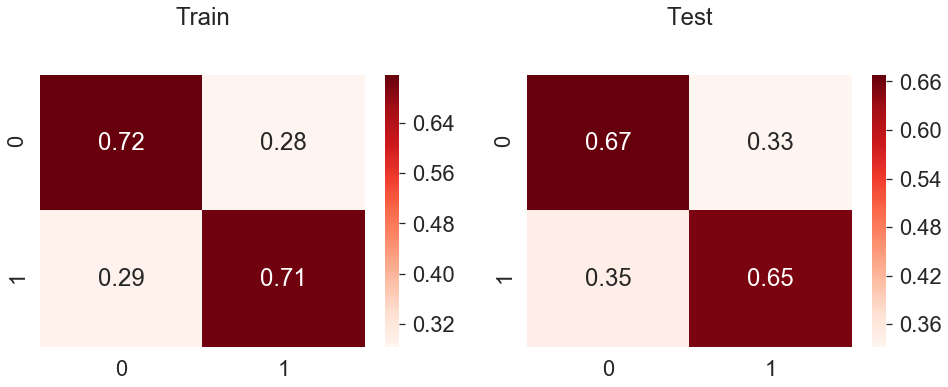

In [563]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_tr_lgbm, train_preds_leafs_100)
test_cnf_matrix = confusion_matrix(Y_test, test_preds_leafs_100)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

- As with other models, we see that the NPV is slightly higher than PPV. But overall accuracy and AUC are much higher than the models we have tried so far.

### Compare Performance of the different Models

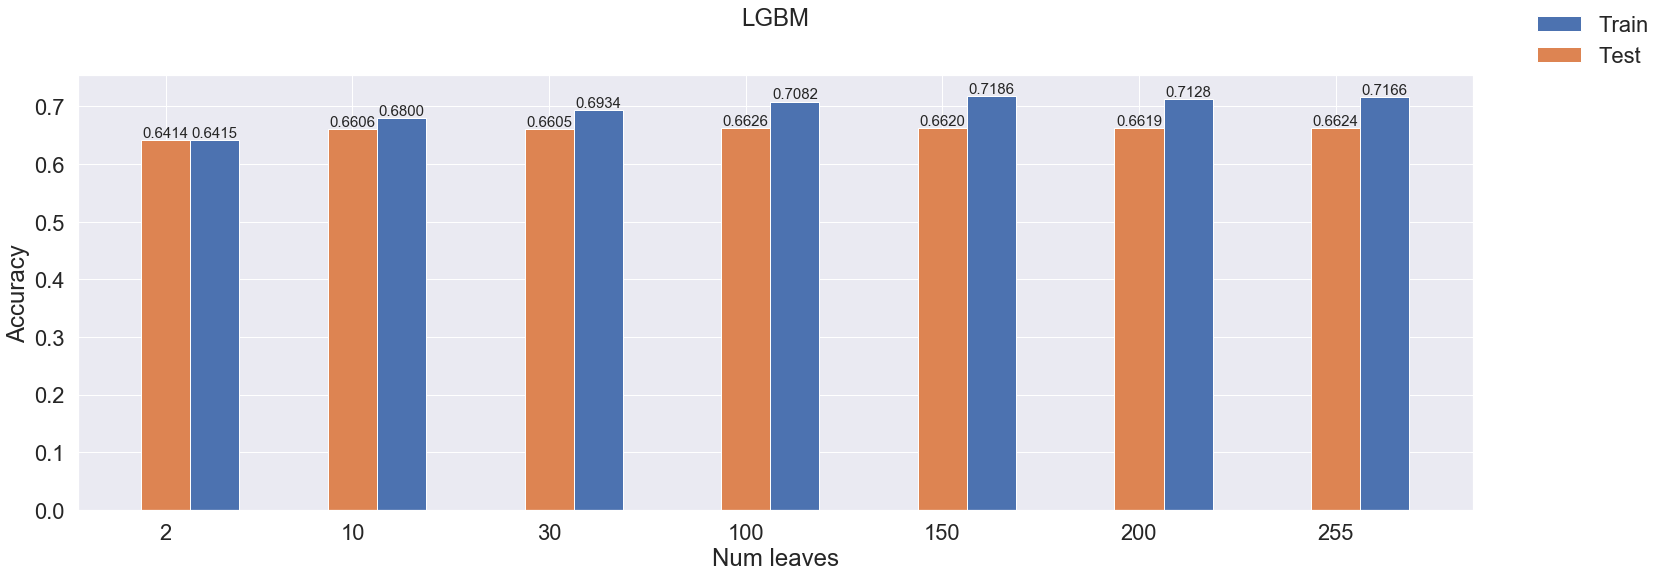

In [225]:
# scores vs n_leaves or score vs min leafs or both
fig, ax = plt.subplots(1, 1, figsize=(25, 8))
width=5
bars1 = ax.bar(x=[1+width,20+width,40+width, 60+width, 80+width,100+width, 120+width],
               height=[train_accu_leafs_2,
                    train_accu_leafs_10,
                    train_accu_leafs_30,
                    train_accu_leafs_100,
                    train_accu_leafs_150,
                    train_accu_leafs_200,
                    train_accu_leafs_255], width=width)
bars2 = ax.bar(x=[1,20,40,60, 80, 100, 120],
               height=[test_accu_leafs_2,
                    test_accu_leafs_10,
                    test_accu_leafs_30,
                    test_accu_leafs_100,
                    test_accu_leafs_150,
                    test_accu_leafs_200,
                    test_accu_leafs_255], width=width)
ax.set_xticks([1,20,40, 60, 80, 100, 120])
ax.set_xticklabels([2, 10, 30, 100,150, 200, 255])
ax.legend((bars1[0], bars2[0]), ('Train', 'Test'), loc=(1.04,1))
plt.xlabel('Num leaves')
plt.ylabel('Accuracy')
plt.title('LGBM')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
#plt.legend(loc=(1.04,0))
plt.show()

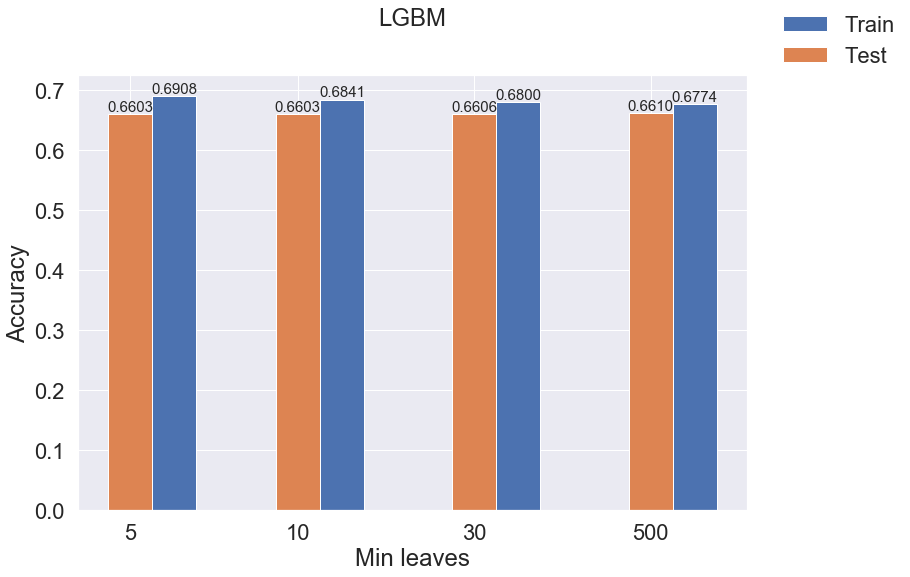

In [229]:
# score vs min leafs or both
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
width=5
bars1 = ax.bar(x=[1+width,20+width,40+width, 60+width],
               height=[train_accu_min_leaf_5,
                    train_accu_min_leaf_10,
                    train_accu_min_leaf_30,
                    train_accu_min_leaf_500],width=width)
bars2 = ax.bar(x=[1,20,40,60],
               height=[test_accu_min_leaf_5,
                    test_accu_min_leaf_10,
                    test_accu_min_leaf_30,
                    test_accu_min_leaf_500],width=width)
ax.set_xticks([1,20,40, 60])
ax.set_xticklabels([5, 10, 30, 500])
ax.legend((bars1[0], bars2[0]), ('Train', 'Test'), loc=(1.04,1))
plt.xlabel('Min leaves')
plt.ylabel('Accuracy')
plt.title('LGBM')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
#plt.legend(loc=(1.04,0))
plt.show()

The plot indicates the influence of minimum number of samples at leaf (x-axis) over train and test accuracy (y-axis). For a small number of samples per leaf, training and testing accuracy differ largely, this indicates the model overfitting. Because when small number of samples are used at each leaf to make a decision to split the tree, then model tends to learn specific features of the training data and fails to generalize. This is evident from the plot that when minimum samples per leaf is 5, training accuracy ($\sim$0.69) is almost 3\% higher than the test accuracy ($\sim$0.66). At the same time when the minimum number of samples is high it leads to underfitting . Optimal value depends on the number of training samples and number of leaves. Setting it to a large value can avoid growing too deep a tree, but causes under-fitting. In practice, setting it to hundreds or thousands is enough for a large dataset, in our case value of 500 is optimal as the testing accruacy (0.661) is highest and test accuracy is not much deviated from the train accuracy.

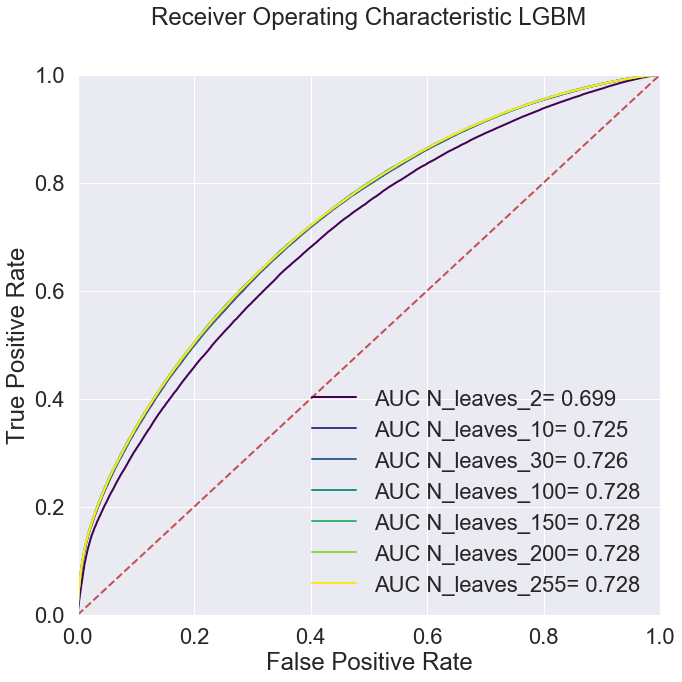

In [228]:
# ROC's of all LGBM odels
list_preds = [test_predictions_leafs_2, test_predictions_leafs_10, test_predictions_leafs_30, test_predictions_leafs_100, test_predictions_leafs_150, test_predictions_leafs_200, test_predictions_leafs_255]
plot_roc_curve(Y_test, list_preds, title_text="LGBM", label_txts=['N_leaves_2', 'N_leaves_10', 'N_leaves_30', 'N_leaves_100', 'N_leaves_150', 'N_leaves_200', 'N_leaves_255'])

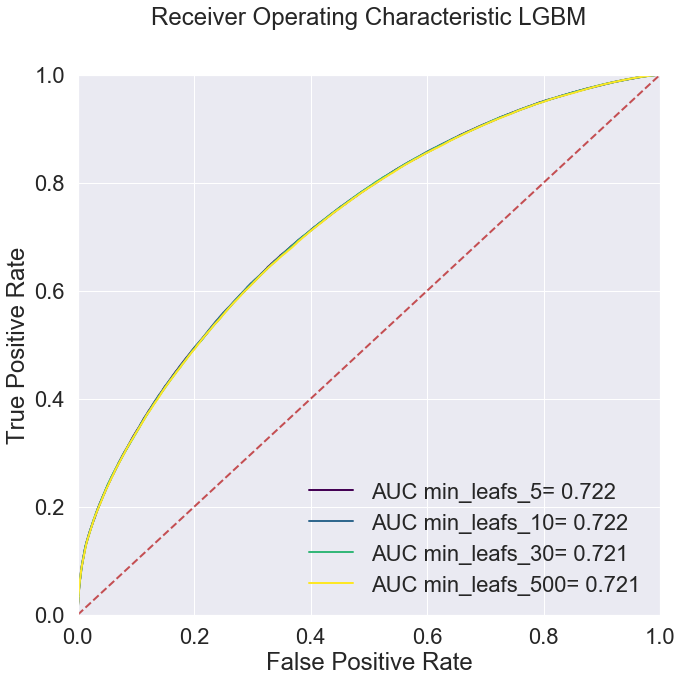

In [629]:
# ROC's of all LGBM odels
list_preds = [test_predictions_min_leaf_5, test_predictions_min_leaf_10, test_predictions_min_leaf_30, test_predictions_min_leaf_500]
plot_roc_curve(Y_test, list_preds, title_text="LGBM", label_txts=['min_leafs_5', 'min_leafs_10', 'min_leafs_30', 'min_leafs_500'])

### Similar to RandomForest, we try to find the most important features

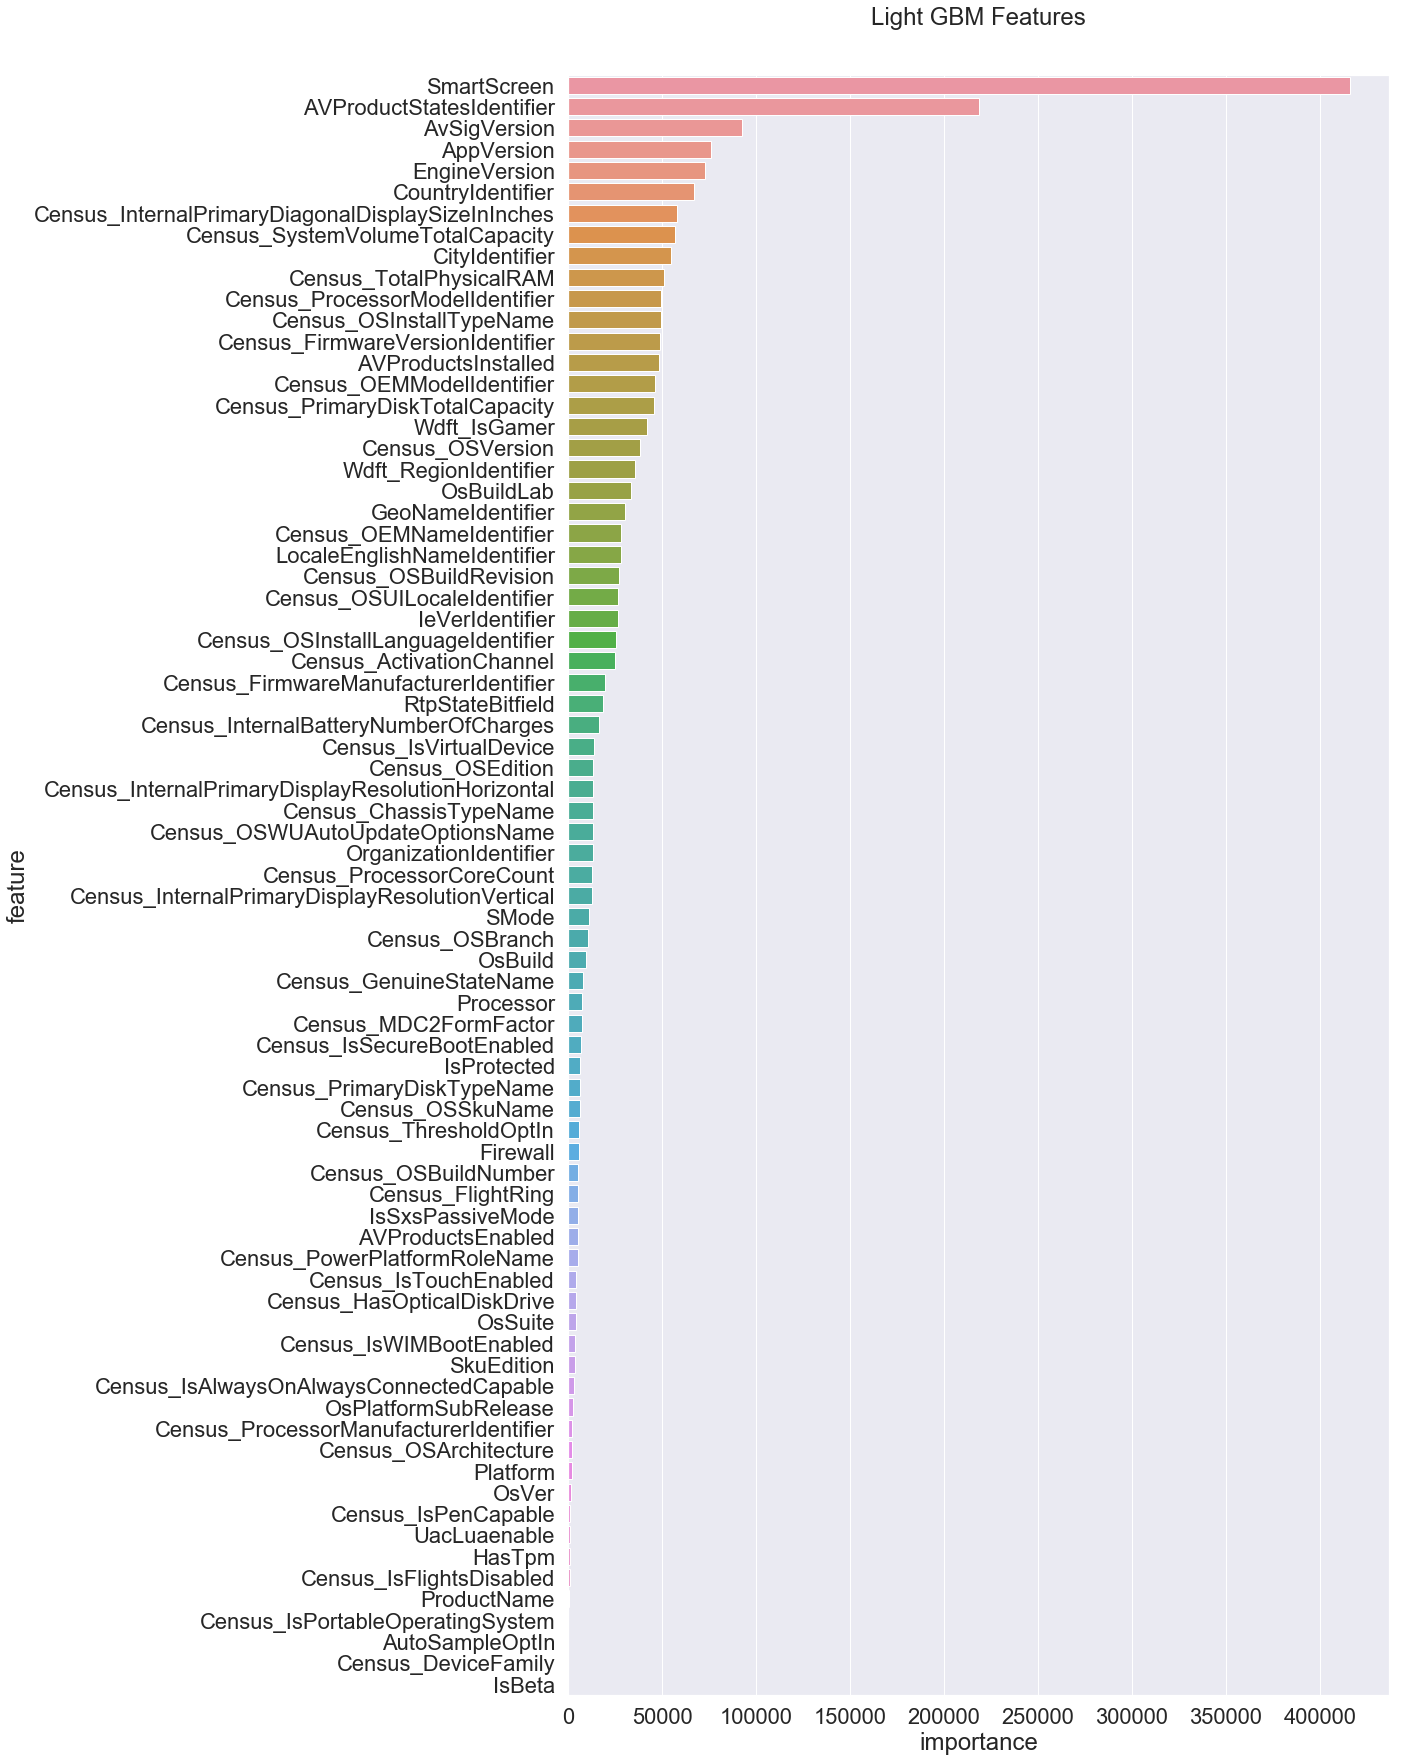

In [230]:
#best_features

a = lgbm_model_1.feature_importance(importance_type="gain")
b = lgbm_model_1.feature_name()
#print(b)
#print(a)
feat_imp_lgbm = pd.DataFrame(index=np.arange(0, len(b)), data={'feature':b, 'importance':a}, dtype=float)
best_feats = feat_imp_lgbm.sort_values(by='importance', ascending=False)
#best_feats.head()
plt.figure(figsize=(20,25))
sns.barplot(x="importance",
            y="feature",
            data=best_feats,
            capsize=.3)
plt.title('Light GBM Features')
plt.tight_layout()
#lgb.plot_importance(lgbm_model_1, figsize=(15, 30), importance_type="gain")
plt.show()

- We can see that there is a lot if features that are equally important to both (also equally unimportant).
- SmartScreen, AvProductStatesIdentifier and AvSigVersion seem to be most important here. This is similar to what we saw fo rthe Random Forest Classifier. 

- We also plot the ROC of the models we have tried so far. By far, the LGBM is the better performer.

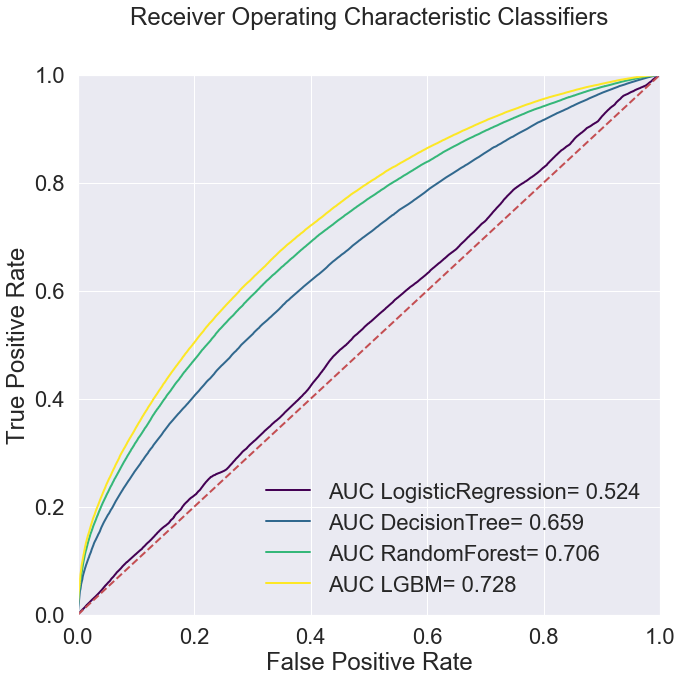

In [231]:
# ROC's of all models(consider best ones)
# This needs all cell to be run, which takes more time. Lets do it in the final run!!!

plt.rcParams['lines.linewidth'] = 2.0

list_preds = [test_preds_log_reg, test_preds_tree_40, test_preds_for_50, test_predictions_leafs_100 ]
plot_roc_curve(Y_test, list_preds, title_text="Classifiers", label_txts=['LogisticRegression', 'DecisionTree', 'RandomForest', 'LGBM'])

## E. Neural Networks
- We now try to see if we can build a model to compete with the LGBM.

#### These columns are going to be used through embedding layers.
- We will apply the categorical columns to Embedding layers to learn some interim embedding for the layer. This is a common technique used often.
- It is discussed here. https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9

In [232]:
embed_cols = []
len_embed_cols = []
for c in categorical_columns[1:]:
    if c in train_copy.columns:
        if train_copy[c].nunique()>2:
            embed_cols.append(c)
            len_embed_cols.append(train_copy[c].nunique())
            print(c + ': %d values' % train_copy[c].nunique()) #look at value counts to know the embedding dimensions
print('\n Number of embed features :', len(embed_cols))

ProductName: 6 values
EngineVersion: 62 values
AppVersion: 98 values
RtpStateBitfield: 7 values
AVProductsInstalled: 7 values
AVProductsEnabled: 7 values
CountryIdentifier: 222 values
OrganizationIdentifier: 47 values
GeoNameIdentifier: 274 values
LocaleEnglishNameIdentifier: 234 values
Platform: 4 values
Processor: 3 values
OsVer: 25 values
OsBuild: 53 values
OsSuite: 10 values
OsPlatformSubRelease: 9 values
SkuEdition: 8 values
IeVerIdentifier: 217 values
SmartScreen: 15 values
UacLuaenable: 9 values
Census_MDC2FormFactor: 12 values
Census_DeviceFamily: 3 values
Census_ProcessorManufacturerIdentifier: 5 values
Census_PrimaryDiskTypeName: 5 values
Census_ChassisTypeName: 40 values
Census_PowerPlatformRoleName: 11 values
Census_OSVersion: 342 values
Census_OSArchitecture: 3 values
Census_OSBranch: 20 values
Census_OSBuildNumber: 88 values
Census_OSBuildRevision: 246 values
Census_OSEdition: 26 values
Census_OSSkuName: 25 values
Census_OSInstallTypeName: 9 values
Census_OSInstallLanguag

#### Now we use a Min-max scaler

In [233]:
X_train_cpy = X_train.copy()
X_test_cpy = X_test.copy()

In [234]:
from sklearn.preprocessing import MinMaxScaler
# Select the numeric features
other_cols = [x for x in X_train_cpy.columns if x not in embed_cols]

# Impute missing values in order to scale
#X_train[other_cols] = X_train[other_cols].fillna(X_train[other_cols].median())


# Fit the scaler only on df_all data
scaler = MinMaxScaler().fit(X_train_cpy[other_cols])
X_train_cpy.loc[:, other_cols] = scaler.transform(X_train_cpy[other_cols])

In [235]:
X_test_cpy.loc[:, other_cols] = scaler.transform(X_test_cpy[other_cols])

In [236]:
cols = embed_cols + other_cols
X_train_cpy = X_train_cpy[cols]
X_test_cpy = X_test_cpy[cols]
#X_train.head()

In [237]:
X_train_cpy.head(10)

ProductName  EngineVersion  AppVersion  RtpStateBitfield  \
216503             0              6           3                 0   
507796             0              0           0                 0   
717949             0              2           0                 0   
137007             0              0           3                 0   
1057459            0              2           0                 0   
116870             0              2           0                 0   
479409             0              7           8                 0   
312879             0              0           8                 0   
297059             0              2           0                 0   
840021             0              2          22                 0   

         AVProductsInstalled  AVProductsEnabled  CountryIdentifier  \
216503                     0                  0                111   
507796                     0                  0                 29   
717949                     1                  0                 17   
137007                     1                  0                 10   
1057459                    0                  0                 17   
116870                     0                  0                 15   
479409                     1                  0                 41   
312879                     0                  0                 15   
297059                     0                  0                 17   
840021                     1                  0                 22   

         OrganizationIdentifier  GeoNameIdentifier  \
216503                        2                 39   
507796                        2                 27   
717949                        2                 17   
137007                        1                 10   
1057459                       0                 17   
116870                        2                 15   
479409                        0                 84   
312879                        2                 15   
297059                        1                 17   
840021                        2                 22   

         LocaleEnglishNameIdentifier  Platform  Processor  OsVer  OsBuild  \
216503                            32         0          0      0        0   
507796                            23         0          0      0        2   
717949                            15         0          0      0        0   
137007                            10         0          0      0        0   
1057459                           15         0          0      0        2   
116870                            14         0          0      0        0   
479409                            75         0          0      0        2   
312879                            14         0          0      0        2   
297059                            15         0          0      0        0   
840021                            11         0          0      0        6   

         OsSuite  OsPlatformSubRelease  SkuEdition  IeVerIdentifier  \
216503         0                     0           0                0   
507796         1                     2           1                4   
717949         1                     0           1                0   
137007         1                     0           1                0   
1057459        1                     2           1               16   
116870         0                     0           5                0   
479409         1                     2           1               16   
312879         0                     2           0                4   
297059         0                     0           0                0   
840021         1                     6           1                8   

         SmartScreen  UacLuaenable  Census_MDC2FormFactor  \
216503             1             0                      1   
507796             2             0                      4   
717949             0             0                      1   
137007   

#### But first, lets create train-val split from Train data.

In [240]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X_train_cpy, Y_train, test_size=0.1)

- For all models below, we use 8 epochs with batch size of 512 to train. We use the Adam optimizer with default learning rate of 0.001, and the ReLU activation function in all layers except the last which obviously uses Sigmoid (binary classification).

### Model 1. Less layers. No dropout or batch norm. Use batch size 512. ReLU + Adam

In [239]:
def NN_model_1():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_1")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_2")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_3")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model    

In [241]:
model_1 = NN_model_1()
model_1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

In [242]:
model_hist_1 = model_1.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 31s - loss: 0.6277 - acc: 0.6372 - val_loss: 0.6208 - val_acc: 0.6469
Epoch 2/8
 - 28s - loss: 0.6169 - acc: 0.6497 - val_loss: 0.6173 - val_acc: 0.6495
Epoch 3/8
 - 28s - loss: 0.6126 - acc: 0.6544 - val_loss: 0.6154 - val_acc: 0.6512
Epoch 4/8
 - 29s - loss: 0.6094 - acc: 0.6573 - val_loss: 0.6152 - val_acc: 0.6524
Epoch 5/8
 - 29s - loss: 0.6066 - acc: 0.6602 - val_loss: 0.6153 - val_acc: 0.6519
Epoch 6/8
 - 30s - loss: 0.6039 - acc: 0.6627 - val_loss: 0.6164 - val_acc: 0.6530
Epoch 7/8
 - 31s - loss: 0.6011 - acc: 0.6650 - val_loss: 0.6163 - val_acc: 0.6530
Epoch 8/8
 - 31s - loss: 0.5984 - acc: 0.6670 - val_loss: 0.6169 - val_acc: 0.6515


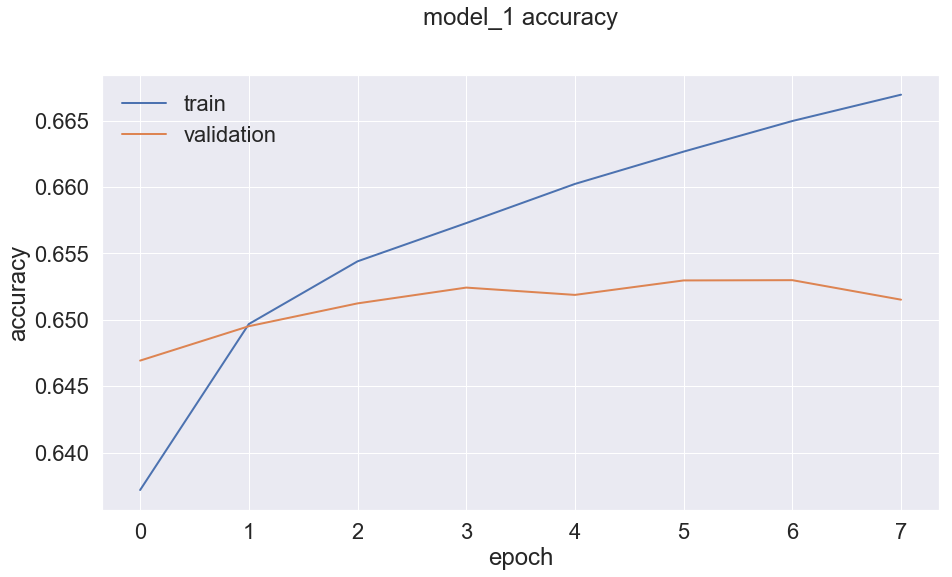

In [243]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_1.history['acc'])
plt.plot(model_hist_1.history['val_acc'])
plt.title('model_1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

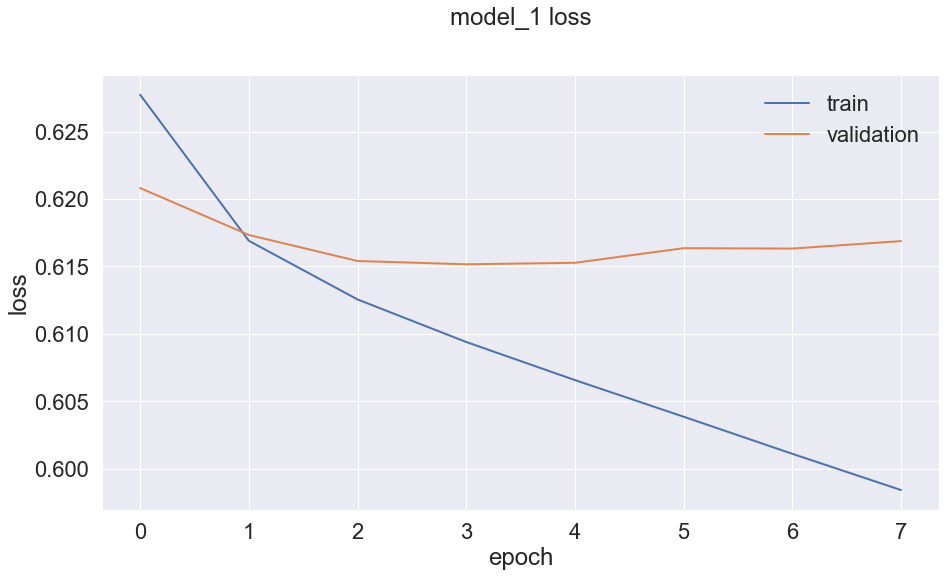

In [244]:
plt.plot(model_hist_1.history['loss'])
plt.plot(model_hist_1.history['val_loss'])
plt.title('model_1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [245]:
Y_preds_val_model_1 = model_1.predict(X_val)

In [246]:
#print("Model Evaluation:", model_1.evaluate(X_test, Y_test))
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_1))

AUC Score: 0.7137966347560277


In [247]:
Y_preds_model_1 = model_1.predict(X_test_cpy)

In [250]:
eval_loss_1, eval_acc_1 = model_1.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_1, train_eval_acc_1 = model_1.evaluate(X_train_cpy, Y_train, verbose=0)

- This model clearly has very high overfitting problem.

### Model 2. Embedding layer Dropout

In [252]:
from keras.layers import Embedding, Reshape, Dropout, Input, Concatenate, concatenate, Dense, Activation, Lambda, BatchNormalization
from keras.models import Sequential, Model

def NN_model_2():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_1")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_2")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_3")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [253]:
model_2 = NN_model_2()
model_2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [254]:
model_hist_2 = model_2.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 41s - loss: 0.6319 - acc: 0.6326 - val_loss: 0.6234 - val_acc: 0.6438
Epoch 2/8
 - 36s - loss: 0.6215 - acc: 0.6449 - val_loss: 0.6186 - val_acc: 0.6490
Epoch 3/8
 - 36s - loss: 0.6176 - acc: 0.6488 - val_loss: 0.6175 - val_acc: 0.6504
Epoch 4/8
 - 37s - loss: 0.6150 - acc: 0.6514 - val_loss: 0.6167 - val_acc: 0.6505
Epoch 5/8
 - 35s - loss: 0.6129 - acc: 0.6542 - val_loss: 0.6168 - val_acc: 0.6496
Epoch 6/8
 - 35s - loss: 0.6110 - acc: 0.6555 - val_loss: 0.6159 - val_acc: 0.6522
Epoch 7/8
 - 35s - loss: 0.6091 - acc: 0.6575 - val_loss: 0.6162 - val_acc: 0.6524
Epoch 8/8
 - 35s - loss: 0.6076 - acc: 0.6584 - val_loss: 0.6160 - val_acc: 0.6519


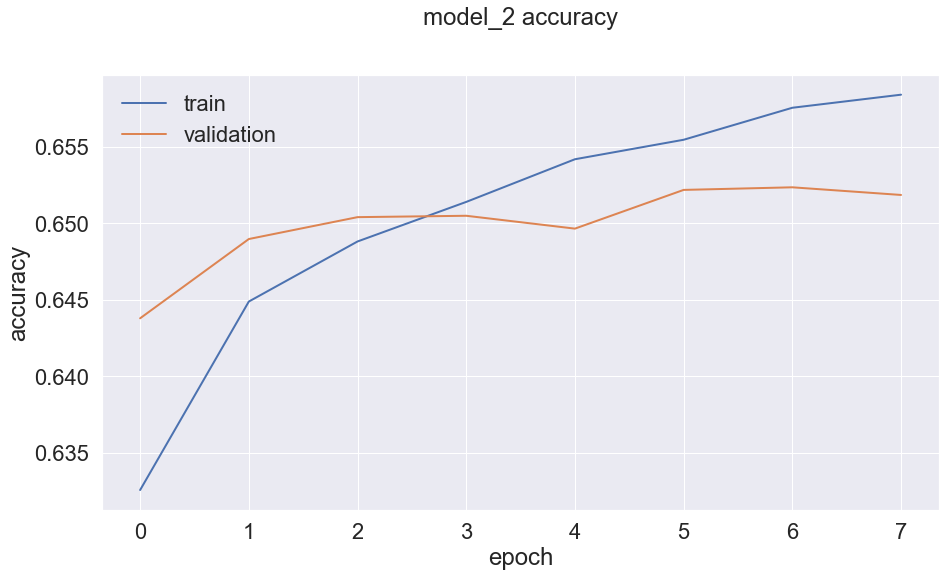

In [255]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_2.history['acc'])
plt.plot(model_hist_2.history['val_acc'])
plt.title('model_2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

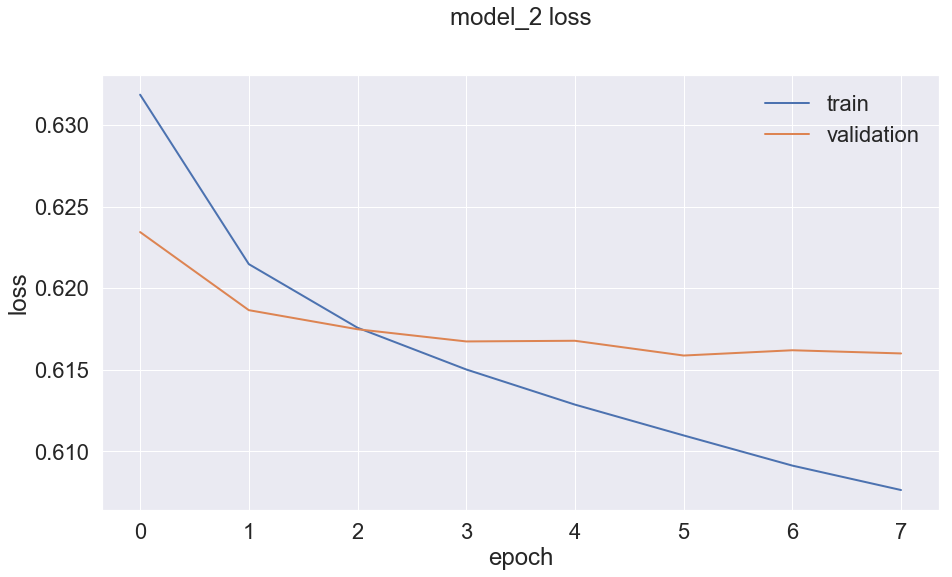

In [256]:
plt.plot(model_hist_2.history['loss'])
plt.plot(model_hist_2.history['val_loss'])
plt.title('model_2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [257]:
Y_preds_model_2 = model_2.predict(X_test_cpy)
#print("AUC Score:",roc_auc_score(Y_test, Y_preds_model_2))
Y_preds_val_model_2 = model_2.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_2))

AUC Score: 0.7137096372830068


In [258]:
eval_loss_2, eval_acc_2 = model_2.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_2, train_eval_acc_2 = model_2.evaluate(X_train_cpy, Y_train, verbose=0)

- Compared to model 1, the AUC score is almost same, but the overfitting has reduced.

### Model 3. Dropout in the Layers

In [259]:
def NN_model_3():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    full_model = Dense(128, name="dense_128")(full_model)    
    full_model = Activation('relu', name="relu_1")(full_model)   
    full_model = Dropout(0.15, name="dropout_act_1")(full_model)       
    full_model = Dense(64, name="dense_64")(full_model)    
    full_model = Activation('relu', name="relu_2")(full_model) 
    full_model = Dropout(0.15, name="dropout_act_2")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_3")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model
    

In [260]:
model_3 = NN_model_3()
model_3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [261]:
model_hist_3 = model_3.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 52s - loss: 0.6344 - acc: 0.6300 - val_loss: 0.6237 - val_acc: 0.6450
Epoch 2/8
 - 46s - loss: 0.6242 - acc: 0.6430 - val_loss: 0.6189 - val_acc: 0.6481
Epoch 3/8
 - 46s - loss: 0.6210 - acc: 0.6459 - val_loss: 0.6174 - val_acc: 0.6497
Epoch 4/8
 - 45s - loss: 0.6189 - acc: 0.6478 - val_loss: 0.6179 - val_acc: 0.6498
Epoch 5/8
 - 46s - loss: 0.6171 - acc: 0.6497 - val_loss: 0.6166 - val_acc: 0.6510
Epoch 6/8
 - 46s - loss: 0.6156 - acc: 0.6517 - val_loss: 0.6160 - val_acc: 0.6512
Epoch 7/8
 - 45s - loss: 0.6143 - acc: 0.6525 - val_loss: 0.6158 - val_acc: 0.6522
Epoch 8/8
 - 46s - loss: 0.6136 - acc: 0.6536 - val_loss: 0.6158 - val_acc: 0.6526


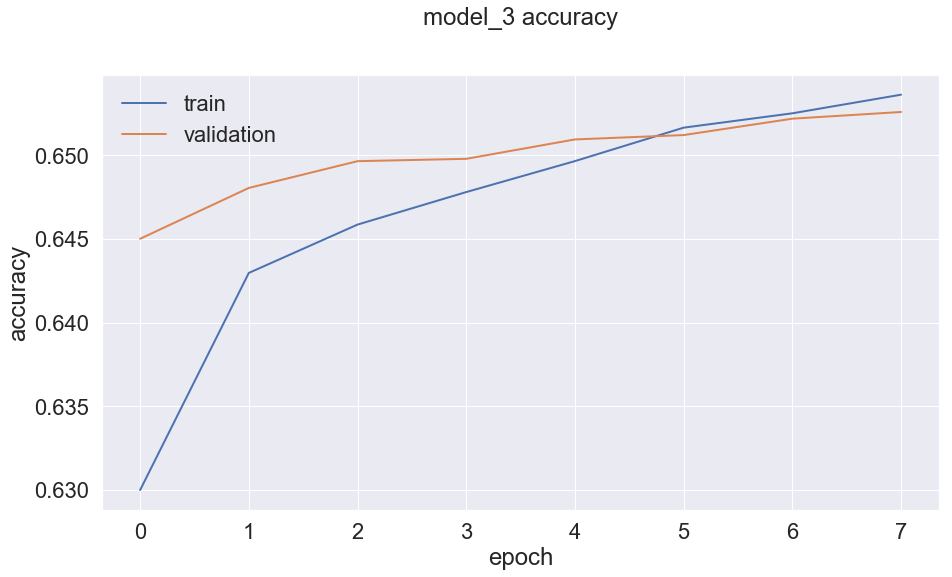

In [262]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_3.history['acc'])
plt.plot(model_hist_3.history['val_acc'])
plt.title('model_3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

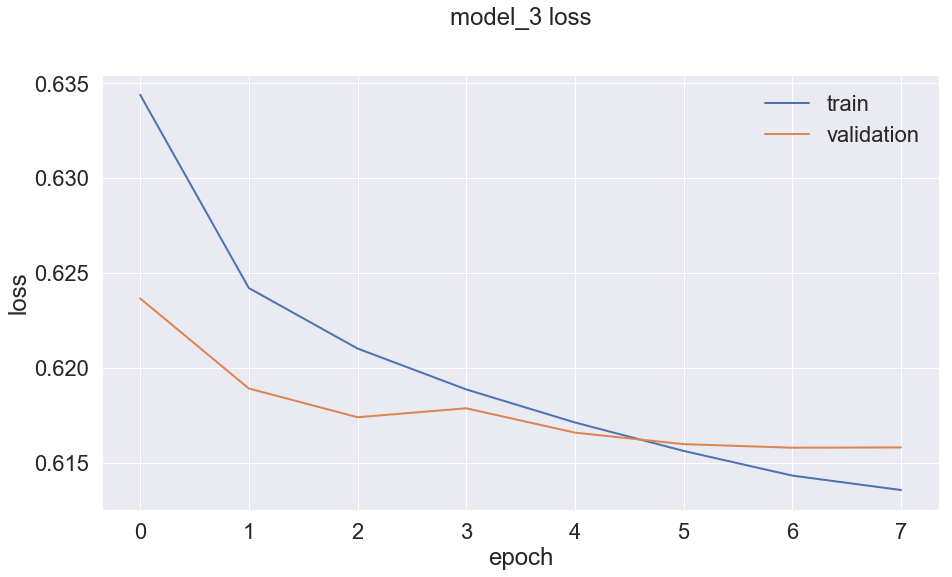

In [263]:
plt.plot(model_hist_3.history['loss'])
plt.plot(model_hist_3.history['val_loss'])
plt.title('model_3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [264]:
Y_preds_model_3 = model_3.predict(X_test_cpy)
Y_preds_val_model_3 = model_3.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_3))

AUC Score: 0.7135781206515063


In [265]:
eval_loss_3, eval_acc_3 = model_3.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_3, train_eval_acc_3 = model_2.evaluate(X_train_cpy, Y_train, verbose=0)

- We now have significantly reduced overfitting!

### Model 5. BatchNorm

- Batch Normalisation is another technique that helps in generalization as Dropout.

In [266]:
def NN_model_5():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_1")(full_model)
    full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_1")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_2")(full_model)
    full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_2")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_3")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #opt = Adam(lr=0.008, decay=0.01)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [267]:
model_5 = NN_model_5()
model_5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [268]:
model_hist_5 = model_5.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 54s - loss: 0.6347 - acc: 0.6295 - val_loss: 0.6250 - val_acc: 0.6396
Epoch 2/8
 - 48s - loss: 0.6220 - acc: 0.6440 - val_loss: 0.6190 - val_acc: 0.6490
Epoch 3/8
 - 48s - loss: 0.6187 - acc: 0.6478 - val_loss: 0.6184 - val_acc: 0.6471
Epoch 4/8
 - 48s - loss: 0.6162 - acc: 0.6500 - val_loss: 0.6181 - val_acc: 0.6491
Epoch 5/8
 - 49s - loss: 0.6141 - acc: 0.6526 - val_loss: 0.6163 - val_acc: 0.6508
Epoch 6/8
 - 47s - loss: 0.6124 - acc: 0.6543 - val_loss: 0.6164 - val_acc: 0.6498
Epoch 7/8
 - 48s - loss: 0.6108 - acc: 0.6557 - val_loss: 0.6161 - val_acc: 0.6505
Epoch 8/8
 - 46s - loss: 0.6093 - acc: 0.6575 - val_loss: 0.6161 - val_acc: 0.6507


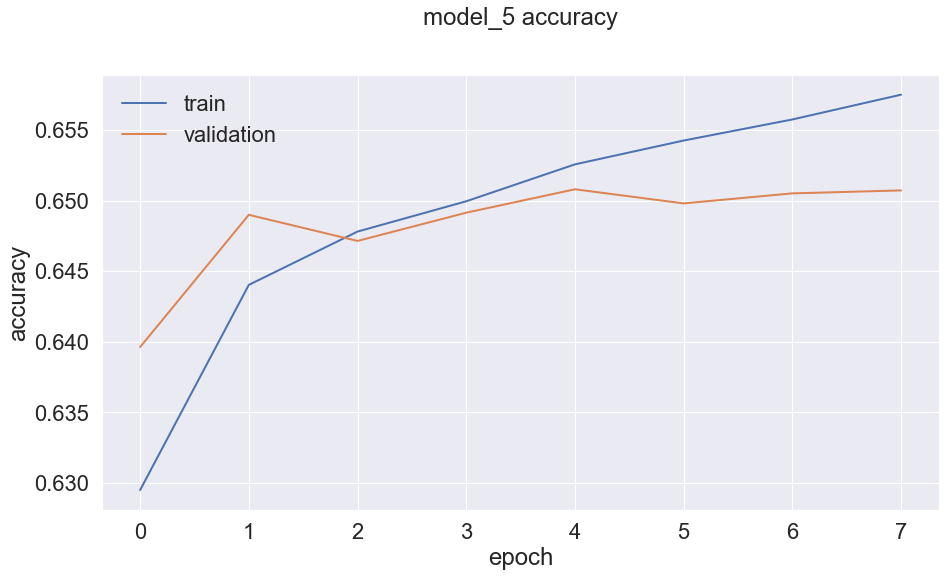

In [269]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_5.history['acc'])
plt.plot(model_hist_5.history['val_acc'])
plt.title('model_5 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

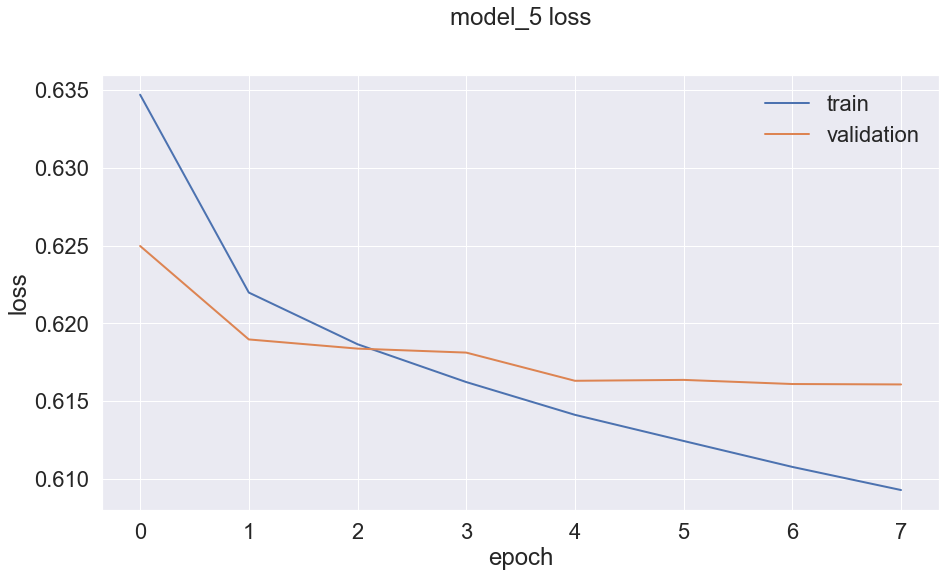

In [270]:
plt.plot(model_hist_5.history['loss'])
plt.plot(model_hist_5.history['val_loss'])
plt.title('model_5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [271]:
Y_preds_model_5 = model_5.predict(X_test_cpy)
Y_preds_val_model_5 = model_5.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_5))

AUC Score: 0.7137478261051968


In [333]:
eval_loss_5, eval_acc_5 = model_5.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_5, train_eval_acc_5 = model_5.evaluate(X_train_cpy, Y_train, verbose=0)

- Batch Norm is also able to combat overfitting. Gives slightly better validation scores. 
- Additionaly for Batch Norm we do not need to test for an extra hyper parameter like dropout. 

### Model 6. More Layers? Lets add another layer (256). BatchNorm, Adam

In [273]:
def NN_model_6():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    #full_model = Dense(1024, name="dense_1024")(full_model)
    #full_model = Activation('relu', name='relu_1024')(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_1024')(full_model)
    #full_model = Dense(512, name="dense_512")(full_model)
    #full_model = Activation('relu', name='relu_512')(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_512')(full_model)
    full_model = Dense(256, name="dense_256")(full_model)
    full_model = Activation('relu', name='relu_256')(full_model)
    full_model = BatchNormalization(name="batch_norm_256a")(full_model)
    #ful_model = Dropout(0.2, name='dropout_act_256')(full_model)
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_128")(full_model)
    full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_128")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_64")(full_model)
    full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_64")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_32")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #optimizer = keras.optimizers.Nadam(lr=0.002, schedule_decay=0.004)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [274]:
model_6 = NN_model_6()
model_6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [275]:
model_hist_6 = model_6.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 77s - loss: 0.6374 - acc: 0.6266 - val_loss: 0.6234 - val_acc: 0.6448
Epoch 2/8
 - 70s - loss: 0.6227 - acc: 0.6431 - val_loss: 0.6210 - val_acc: 0.6470
Epoch 3/8
 - 70s - loss: 0.6189 - acc: 0.6475 - val_loss: 0.6181 - val_acc: 0.6496
Epoch 4/8
 - 71s - loss: 0.6164 - acc: 0.6499 - val_loss: 0.6164 - val_acc: 0.6508
Epoch 5/8
 - 70s - loss: 0.6138 - acc: 0.6526 - val_loss: 0.6157 - val_acc: 0.6512
Epoch 6/8
 - 70s - loss: 0.6115 - acc: 0.6549 - val_loss: 0.6164 - val_acc: 0.6513
Epoch 7/8
 - 71s - loss: 0.6094 - acc: 0.6569 - val_loss: 0.6149 - val_acc: 0.6531
Epoch 8/8
 - 70s - loss: 0.6072 - acc: 0.6592 - val_loss: 0.6155 - val_acc: 0.6526


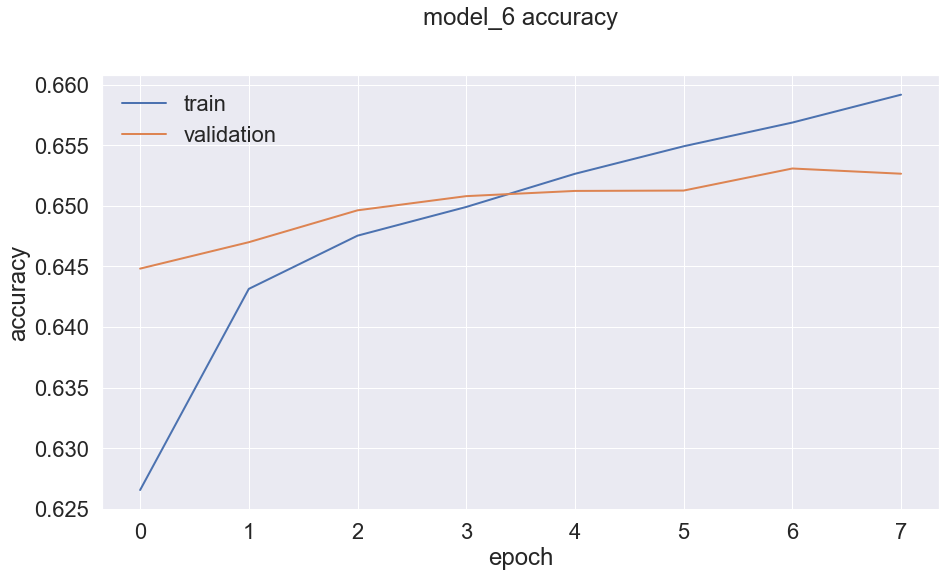

In [276]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_6.history['acc'])
plt.plot(model_hist_6.history['val_acc'])
plt.title('model_6 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

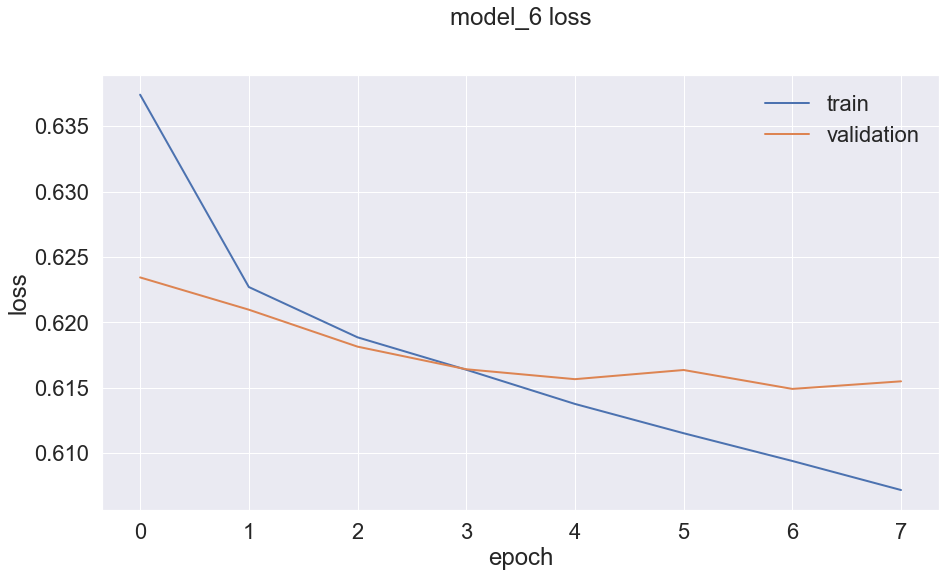

In [277]:
plt.plot(model_hist_6.history['loss'])
plt.plot(model_hist_6.history['val_loss'])
plt.title('model_6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [278]:
Y_preds_model_6 = model_6.predict(X_test_cpy)
Y_preds_val_model_6 = model_6.predict(X_val)
roc_auc_model_6 = roc_auc_score(Y_test, Y_preds_model_6)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_6))

AUC Score: 0.7142667516774569


In [279]:
eval_loss_6, eval_acc_6 = model_6.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_6, train_eval_acc_6 = model_6.evaluate(X_train_cpy, Y_train, verbose=0)

- Validation performance improves. AUC score improves

### Model 7. One more Layer. (512)

In [280]:
def NN_model_7():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    #full_model = Dense(1024, name="dense_1024")(full_model)
    #full_model = Activation('relu', name='relu_1024')(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_1024')(full_model)
    full_model = Dense(512, name="dense_512")(full_model)
    full_model = Activation('relu', name='relu_512')(full_model)
    full_model = BatchNormalization(name="batch_norm_512a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_512')(full_model)
    full_model = Dense(256, name="dense_256")(full_model)
    full_model = Activation('relu', name='relu_256')(full_model)
    full_model = BatchNormalization(name="batch_norm_256a")(full_model)
    #ful_model = Dropout(0.2, name='dropout_act_256')(full_model)
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_128")(full_model)
    full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_128")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_64")(full_model)
    full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_64")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_32")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #optimizer = keras.optimizers.Nadam(lr=0.002, schedule_decay=0.004)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [281]:
model_7 = NN_model_7()
model_7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [282]:
model_hist_7 = model_7.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 126s - loss: 0.6363 - acc: 0.6275 - val_loss: 0.6234 - val_acc: 0.6435
Epoch 2/8
 - 115s - loss: 0.6224 - acc: 0.6439 - val_loss: 0.6215 - val_acc: 0.6474
Epoch 3/8
 - 116s - loss: 0.6186 - acc: 0.6479 - val_loss: 0.6180 - val_acc: 0.6490
Epoch 4/8
 - 117s - loss: 0.6156 - acc: 0.6513 - val_loss: 0.6172 - val_acc: 0.6501
Epoch 5/8
 - 117s - loss: 0.6129 - acc: 0.6539 - val_loss: 0.6161 - val_acc: 0.6505
Epoch 6/8
 - 117s - loss: 0.6103 - acc: 0.6566 - val_loss: 0.6150 - val_acc: 0.6530
Epoch 7/8
 - 120s - loss: 0.6075 - acc: 0.6590 - val_loss: 0.6162 - val_acc: 0.6518
Epoch 8/8
 - 120s - loss: 0.6048 - acc: 0.6615 - val_loss: 0.6146 - val_acc: 0.6526


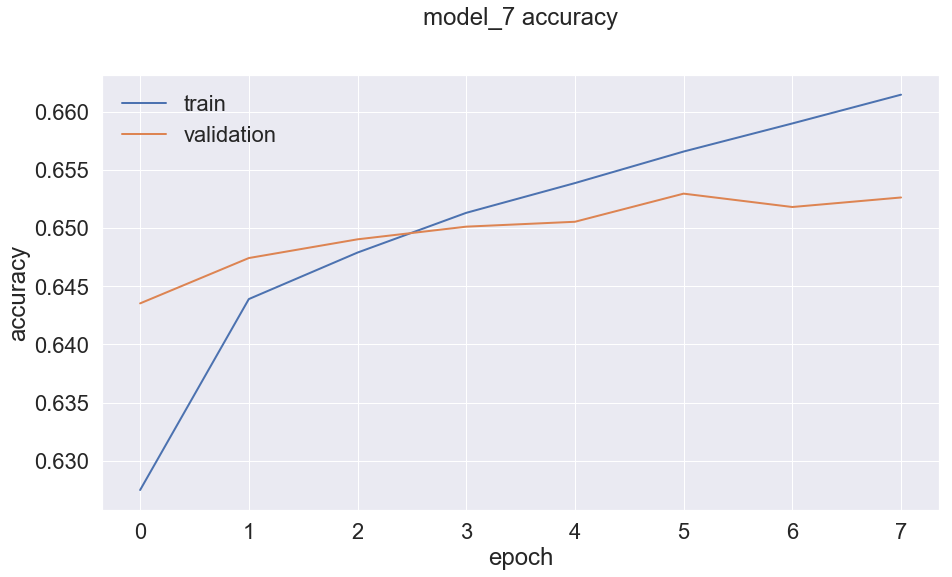

In [283]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_7.history['acc'])
plt.plot(model_hist_7.history['val_acc'])
plt.title('model_7 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

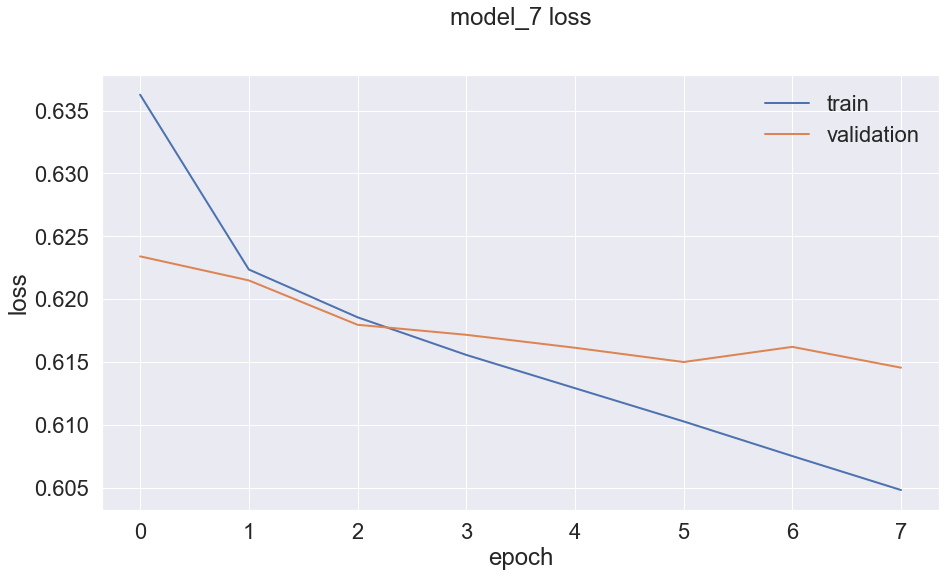

In [284]:
plt.plot(model_hist_7.history['loss'])
plt.plot(model_hist_7.history['val_loss'])
plt.title('model_7 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [285]:
Y_preds_model_7 = model_7.predict(X_test_cpy)
Y_preds_val_model_7 = model_7.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_7))

AUC Score: 0.7151095180218792


In [286]:
eval_loss_7, eval_acc_7 = model_7.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_7, train_eval_acc_7 = model_7.evaluate(X_train_cpy, Y_train, verbose=0)

- Good performance, but overfitting is increasing.

### Model 8. One more layer? (1024)

In [287]:
def NN_model_8():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    full_model = Dense(1024, name="dense_1024")(full_model)
    #full_model = Activation('relu', name='relu_1024')(full_model)
    full_model = BatchNormalization(name="batch_norm_1024a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_1024')(full_model)
    full_model = Dense(512, name="dense_512")(full_model)
    full_model = Activation('relu', name='relu_512')(full_model)
    full_model = BatchNormalization(name="batch_norm_512a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_512')(full_model)
    full_model = Dense(256, name="dense_256")(full_model)
    full_model = Activation('relu', name='relu_256')(full_model)
    full_model = BatchNormalization(name="batch_norm_256a")(full_model)
    #ful_model = Dropout(0.2, name='dropout_act_256')(full_model)
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_128")(full_model)
    full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_128")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_64")(full_model)
    full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_64")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_32")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #optimizer = keras.optimizers.Nadam(lr=0.002, schedule_decay=0.004)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [288]:
model_8 = NN_model_8()
model_8.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [289]:
model_hist_8 = model_8.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 259s - loss: 0.6353 - acc: 0.6287 - val_loss: 0.6247 - val_acc: 0.6412
Epoch 2/8
 - 247s - loss: 0.6235 - acc: 0.6426 - val_loss: 0.6213 - val_acc: 0.6461
Epoch 3/8
 - 245s - loss: 0.6208 - acc: 0.6455 - val_loss: 0.6194 - val_acc: 0.6461
Epoch 4/8
 - 244s - loss: 0.6190 - acc: 0.6479 - val_loss: 0.6190 - val_acc: 0.6488
Epoch 5/8
 - 235s - loss: 0.6175 - acc: 0.6493 - val_loss: 0.6169 - val_acc: 0.6489
Epoch 6/8
 - 236s - loss: 0.6160 - acc: 0.6513 - val_loss: 0.6166 - val_acc: 0.6527
Epoch 7/8
 - 236s - loss: 0.6145 - acc: 0.6528 - val_loss: 0.6162 - val_acc: 0.6501
Epoch 8/8
 - 237s - loss: 0.6132 - acc: 0.6537 - val_loss: 0.6152 - val_acc: 0.6515


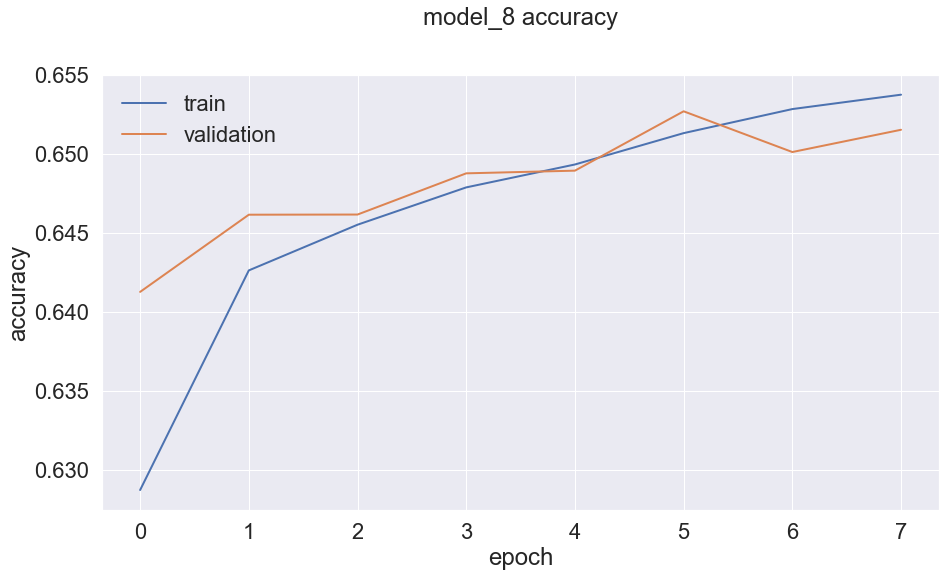

In [290]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_8.history['acc'])
plt.plot(model_hist_8.history['val_acc'])
plt.title('model_8 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

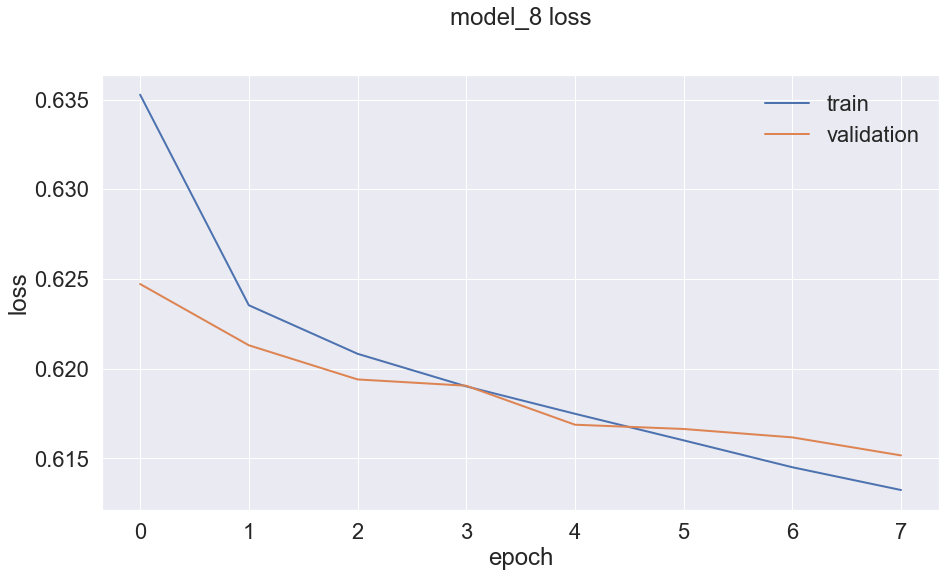

In [291]:
plt.plot(model_hist_8.history['loss'])
plt.plot(model_hist_8.history['val_loss'])
plt.title('model_8 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [292]:
Y_preds_model_8 = model_8.predict(X_test_cpy)
Y_preds_val_model_8 = model_8.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_8))

AUC Score: 0.7141364492720983


In [293]:
eval_loss_8, eval_acc_8 = model_8.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_8, train_eval_acc_8 = model_8.evaluate(X_train_cpy, Y_train, verbose=0)

- Not much overfitting but performance is degrading. 
- Also we have a lot of parameters now leading to significantly higher training time. 

#### Now we try to see if Dropout with additional layers help.

## Model 9. 256 + Dropout

In [294]:
def NN_model_9():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    #full_model = Dense(1024, name="dense_1024")(full_model)
    #full_model = Activation('relu', name='relu_1024')(full_model)
    #full_model = BatchNormalization(name="batch_norm_1024a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_1024')(full_model)
    #full_model = Dense(512, name="dense_512")(full_model)
    #full_model = Activation('relu', name='relu_512')(full_model)
    #full_model = BatchNormalization(name="batch_norm_512a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_512')(full_model)
    full_model = Dense(256, name="dense_256")(full_model)
    full_model = Activation('relu', name='relu_256')(full_model)
    #full_model = BatchNormalization(name="batch_norm_256a")(full_model)
    ful_model = Dropout(0.2, name='dropout_act_256')(full_model)
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_128")(full_model)
    #full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    full_model = Dropout(0.2, name="dropout_act_128")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_64")(full_model)
    #full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    full_model = Dropout(0.2, name="dropout_act_64")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_32")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #optimizer = keras.optimizers.Nadam(lr=0.002, schedule_decay=0.004)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [295]:
model_9 = NN_model_9()
model_9.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [296]:
model_hist_9 = model_9.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 74s - loss: 0.6335 - acc: 0.6311 - val_loss: 0.6220 - val_acc: 0.6437
Epoch 2/8
 - 60s - loss: 0.6226 - acc: 0.6442 - val_loss: 0.6196 - val_acc: 0.6472
Epoch 3/8
 - 63s - loss: 0.6183 - acc: 0.6488 - val_loss: 0.6178 - val_acc: 0.6502
Epoch 4/8
 - 65s - loss: 0.6155 - acc: 0.6515 - val_loss: 0.6160 - val_acc: 0.6516
Epoch 5/8
 - 64s - loss: 0.6130 - acc: 0.6539 - val_loss: 0.6172 - val_acc: 0.6516
Epoch 6/8
 - 64s - loss: 0.6109 - acc: 0.6558 - val_loss: 0.6163 - val_acc: 0.6510
Epoch 7/8
 - 65s - loss: 0.6088 - acc: 0.6575 - val_loss: 0.6172 - val_acc: 0.6504
Epoch 8/8
 - 65s - loss: 0.6067 - acc: 0.6596 - val_loss: 0.6169 - val_acc: 0.6510


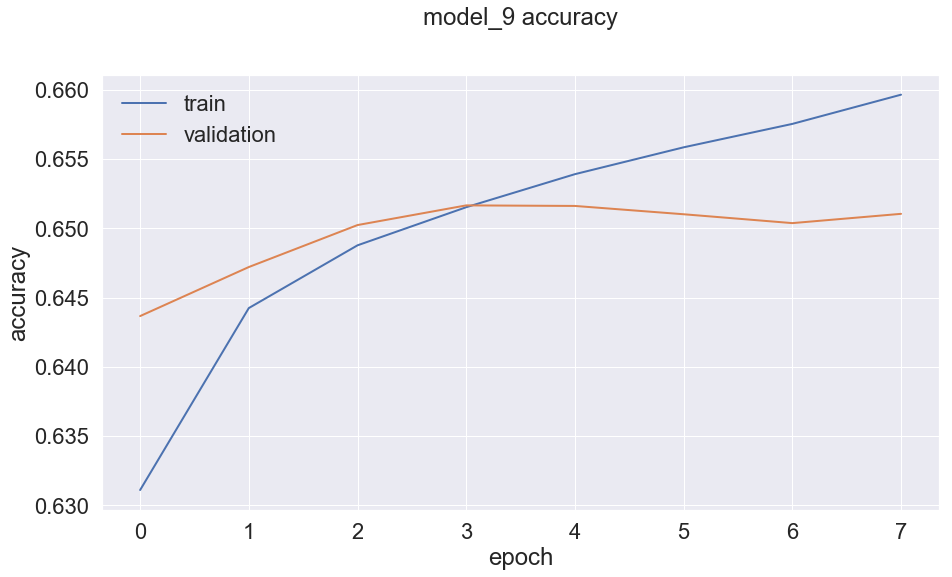

In [297]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_9.history['acc'])
plt.plot(model_hist_9.history['val_acc'])
plt.title('model_9 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

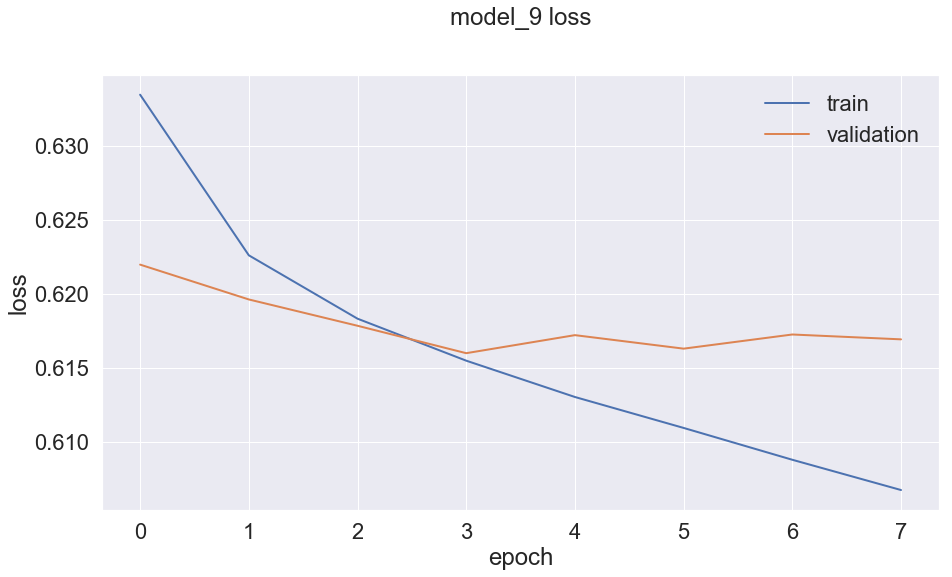

In [298]:
plt.plot(model_hist_9.history['loss'])
plt.plot(model_hist_9.history['val_loss'])
plt.title('model_9 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [299]:
Y_preds_model_9 = model_9.predict(X_test_cpy)
Y_preds_val_model_9 = model_9.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_9))

AUC Score: 0.7133933416732889


In [300]:
eval_loss_9, eval_acc_9 = model_9.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_9, train_eval_acc_9 = model_9.evaluate(X_train_cpy, Y_train, verbose=0)

## Model 10. 512 + Dropout

In [301]:
def NN_model_10():
    models = []
    num_numeric = len(other_cols)
    inputs = Input(shape=(len(embed_cols)+len(other_cols),), name="input_node")
    for i, categoical_var in enumerate(embed_cols):
        len_emb = len_embed_cols[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    #full_model = Dense(1024, name="dense_1024")(full_model)
    #full_model = Activation('relu', name='relu_1024')(full_model)
    #full_model = BatchNormalization(name="batch_norm_1024a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_1024')(full_model)
    full_model = Dense(512, name="dense_512")(full_model)
    #full_model = Activation('relu', name='relu_512')(full_model)
    #full_model = BatchNormalization(name="batch_norm_512a")(full_model)
    ful_model = Dropout(0.2, name='dropout_act_512')(full_model)
    full_model = Dense(256, name="dense_256")(full_model)
    full_model = Activation('relu', name='relu_256')(full_model)
    #full_model = BatchNormalization(name="batch_norm_256a")(full_model)
    ful_model = Dropout(0.2, name='dropout_act_256')(full_model)
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_128")(full_model)
    #full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    full_model = Dropout(0.2, name="dropout_act_128")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_64")(full_model)
    #full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    full_model = Dropout(0.2, name="dropout_act_64")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_32")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #optimizer = keras.optimizers.Nadam(lr=0.002, schedule_decay=0.004)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [302]:
model_10 = NN_model_10()
model_10.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 76)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
embed_38 (Embedding)            (None, 1, 3)         21          lambda_index_38[0][0]            
__________________________________________________________________________________________________
embed_39 (Embedding)            (None, 1, 3)         24          lambda_index_39[0][0]            
__________________________________________________________________________________________________
embed_40 (Embedding)            (None, 1, 206)       85284       lambda_index_40[0][0]            
__________________________________________________________________________________________________
embed_41 (Embedding)            (None, 1, 8)         136         lambda_index_41[0][0]            
__________________________________________________________________________________________________
reshape_0 (Reshape)             (None, 3)            0           embed_0[0][0]                    
__________

__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 3)            0           reshape_36[0][0]                 
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 2)            0           reshape_37[0][0]                 
__________________________________________________________________________________________________
dropout_38 (Dropout)            (None, 3)            0           reshape_38[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 3)            0           reshape_39[0][0]                 
__________________________________________________________________________________________________
dropout_40 (Dropout)            (None, 206)          0           reshape_40[0][0]                 
__________

In [303]:
model_hist_10 = model_10.fit(x=X_tr.values, y=Y_tr.values, validation_data=(X_val.values, Y_val.values), epochs=8, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/8
 - 111s - loss: 0.6343 - acc: 0.6304 - val_loss: 0.6257 - val_acc: 0.6422
Epoch 2/8
 - 104s - loss: 0.6255 - acc: 0.6413 - val_loss: 0.6232 - val_acc: 0.6456
Epoch 3/8
 - 102s - loss: 0.6227 - acc: 0.6443 - val_loss: 0.6267 - val_acc: 0.6459
Epoch 4/8
 - 103s - loss: 0.6208 - acc: 0.6460 - val_loss: 0.6213 - val_acc: 0.6481
Epoch 5/8
 - 104s - loss: 0.6190 - acc: 0.6481 - val_loss: 0.6188 - val_acc: 0.6494
Epoch 6/8
 - 107s - loss: 0.6177 - acc: 0.6496 - val_loss: 0.6203 - val_acc: 0.6510
Epoch 7/8
 - 103s - loss: 0.6163 - acc: 0.6506 - val_loss: 0.6174 - val_acc: 0.6499
Epoch 8/8
 - 104s - loss: 0.6153 - acc: 0.6520 - val_loss: 0.6176 - val_acc: 0.6511


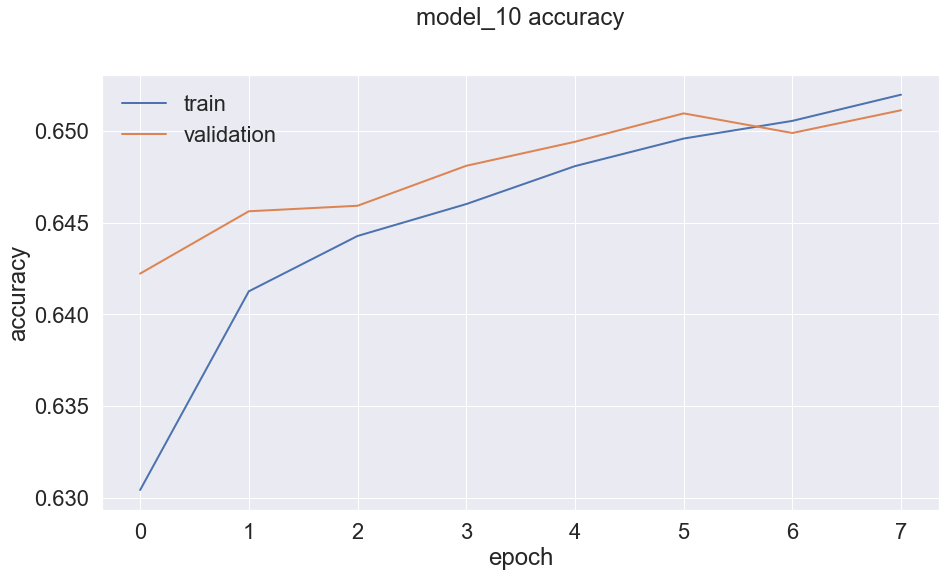

In [304]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_10.history['acc'])
plt.plot(model_hist_10.history['val_acc'])
plt.title('model_10 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

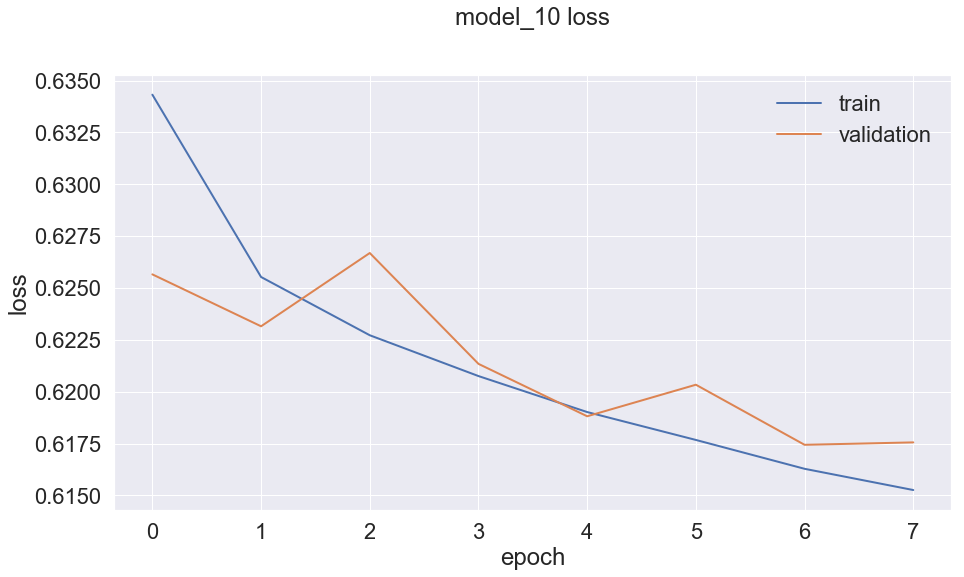

In [305]:
plt.plot(model_hist_10.history['loss'])
plt.plot(model_hist_10.history['val_loss'])
plt.title('model_10 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [306]:
Y_preds_model_10 = model_10.predict(X_test_cpy)
Y_preds_val_model_10 = model_10.predict(X_val)
print("AUC Score:",roc_auc_score(Y_val, Y_preds_val_model_10))

AUC Score: 0.7131410402413401


In [307]:
eval_loss_10, eval_acc_10 = model_10.evaluate(X_test_cpy, Y_test, verbose=0)
train_eval_loss_10, train_eval_acc_10 = model_10.evaluate(X_train_cpy, Y_train, verbose=0)

- For both models 9 and 10 Dropout did not help much. BatchNorm performed as well if not better. 
- So instead of trying for more tuning with the dropout rate, we decide to go ahead and choose a model that has BatchNorm.

#### Let us compare the performance of the models on the validation data.

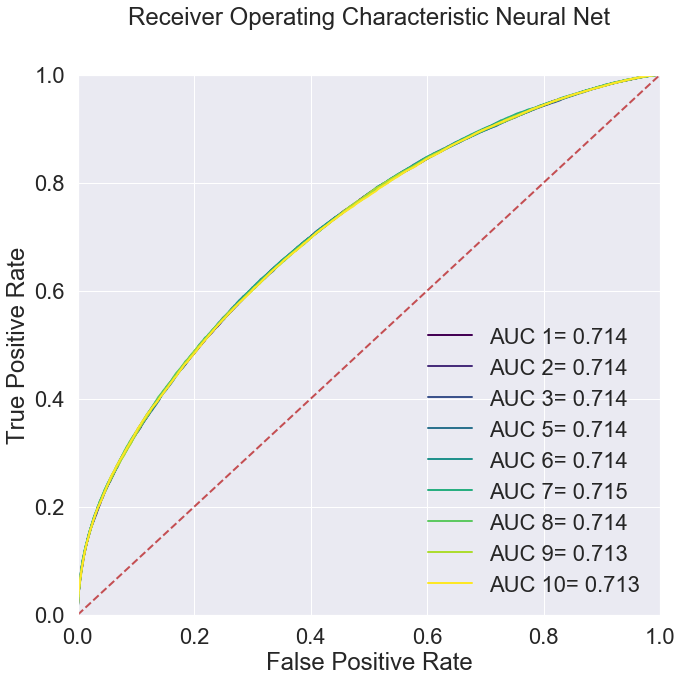

In [351]:
plot_roc_curve(Y_val, [Y_preds_val_model_1, Y_preds_val_model_2, Y_preds_val_model_3, Y_preds_val_model_5, Y_preds_val_model_6, Y_preds_val_model_7, Y_preds_val_model_8, Y_preds_val_model_9, Y_preds_val_model_10],
               title_text="Neural Net", label_txts=['1','2','3','5','6','7','8','9','10'])

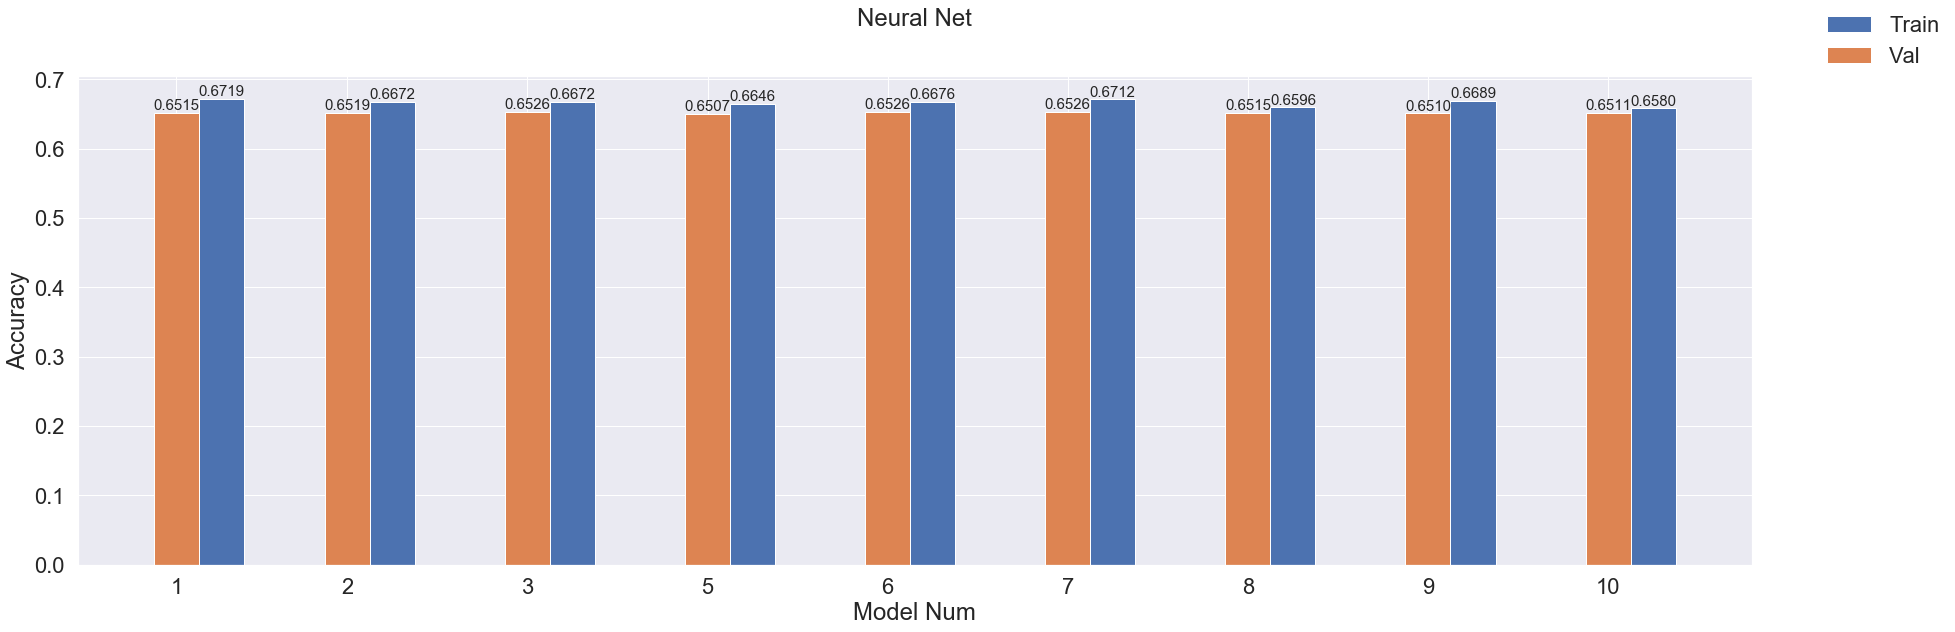

In [357]:
# scores vs n_leaves or score vs min leafs or both
fig, ax = plt.subplots(1, 1, figsize=(30, 9))
width=5
bars1 = ax.bar(x=[1+width,20+width,40+width, 60+width, 80+width,100+width, 120+width, 140+width, 160+width],
               height=[train_eval_acc_1,
                    train_eval_acc_2,
                    train_eval_acc_3,
                    train_eval_acc_5,
                    train_eval_acc_6, 
                    train_eval_acc_7,
                      train_eval_acc_8,
                      train_eval_acc_9,
                      train_eval_acc_10], width=width)
bars2 = ax.bar(x=[1,20,40,60, 80, 100, 120, 140, 160],
               height=[model_hist_1.history['val_acc'][-1],
                    model_hist_2.history['val_acc'][-1],
                    model_hist_3.history['val_acc'][-1],
                    model_hist_5.history['val_acc'][-1],
                    model_hist_6.history['val_acc'][-1],
                    model_hist_7.history['val_acc'][-1],
                      model_hist_8.history['val_acc'][-1],
                      model_hist_9.history['val_acc'][-1],
                      model_hist_10.history['val_acc'][-1]], width=width)
ax.set_xticks([1,20,40, 60, 80, 100, 120, 140, 160])
ax.set_xticklabels([1,2,3,5,6,7,8,9,10])
ax.legend((bars1[0], bars2[0]), ('Train', 'Val'), loc=(1.04,1))
plt.xlabel('Model Num')
plt.ylabel('Accuracy')
plt.title('Neural Net')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
#plt.legend(loc=(1.04,0))
plt.show()

- We choose model 6 as it gave a good validation accuracy, less overfitting and high validation AUC. Also it is a simpler model than model 7 which is the closest competitor.
- Hence our chosen model structure is **Embedding-256-ReLU-BatchNorm-128-ReLU-BatchNorm-64-ReLU-BatchNorm-32-ReLU-Sigmoid.**
- This model is quite balanced, not too many parameters and also using BatchNorm.

### Performance of the Model 6 on Test data.

In [344]:
#Y_pred_class_model_7 = Y_preds_model_7.argmax(axis=-1)
Y_pred_class_model_6 = np.rint(Y_preds_model_6)
Y_pred_class_train_model_6 = np.rint(Y_preds_train_model_6)

In [345]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train:")
print(classification_report(Y_tr, Y_pred_class_train_model_6, target_names=target_names))
print('Test:')
print(classification_report(Y_test, Y_pred_class_model_6, target_names=target_names))

Train:
                   precision    recall  f1-score   support

HasDetections = 0       0.67      0.67      0.67    450345
HasDetections = 1       0.67      0.67      0.67    449655

        micro avg       0.67      0.67      0.67    900000
        macro avg       0.67      0.67      0.67    900000
     weighted avg       0.67      0.67      0.67    900000

Test:
                   precision    recall  f1-score   support

HasDetections = 0       0.65      0.66      0.66    125038
HasDetections = 1       0.66      0.65      0.65    124962

        micro avg       0.65      0.65      0.65    250000
        macro avg       0.65      0.65      0.65    250000
     weighted avg       0.65      0.65      0.65    250000



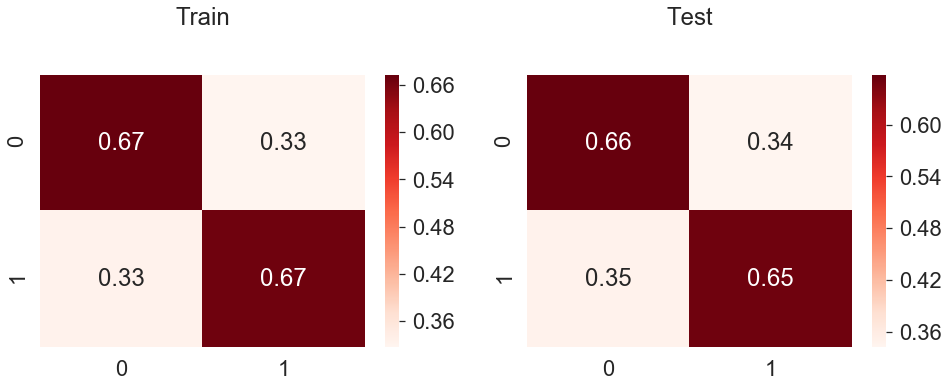

In [346]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_tr, Y_pred_class_train_model_6)
test_cnf_matrix = confusion_matrix(Y_test, Y_pred_class_model_6)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

- More or less balanced prediction. Slightly higher NPV, so we have slightly higher False Omission Rate.

### We also see how each model had performed on the unseen test data. 

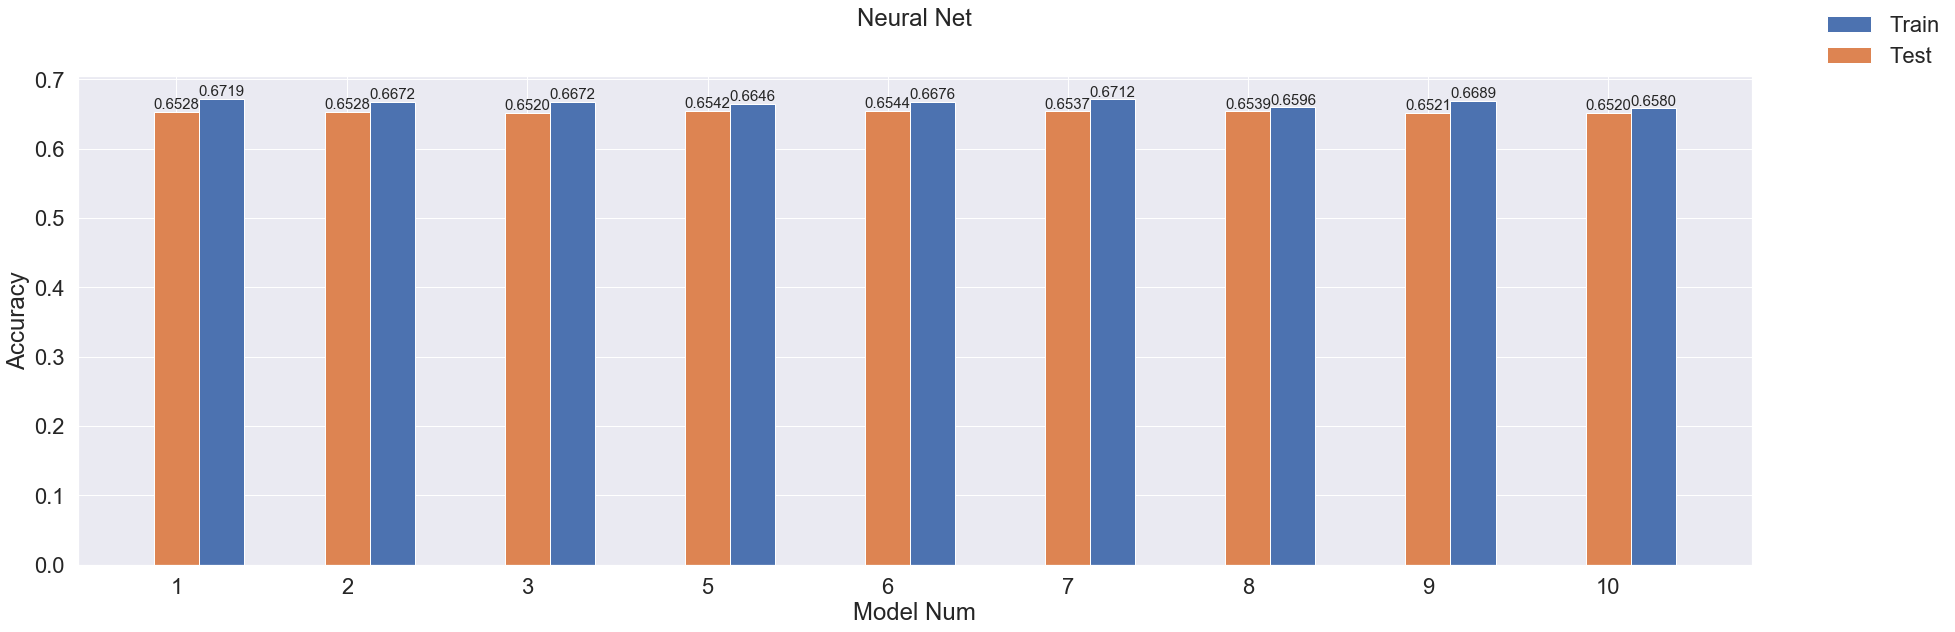

In [354]:
# scores vs n_leaves or score vs min leafs or both
fig, ax = plt.subplots(1, 1, figsize=(30, 9))
width=5
bars1 = ax.bar(x=[1+width,20+width,40+width, 60+width, 80+width,100+width, 120+width, 140+width, 160+width],
               height=[train_eval_acc_1,
                    train_eval_acc_2,
                    train_eval_acc_3,
                    train_eval_acc_5,
                    train_eval_acc_6, 
                    train_eval_acc_7,
                      train_eval_acc_8,
                      train_eval_acc_9,
                      train_eval_acc_10], width=width)
bars2 = ax.bar(x=[1,20,40,60, 80, 100, 120, 140, 160],
               height=[eval_acc_1,
                    eval_acc_2,
                    eval_acc_3,
                    eval_acc_5,
                    eval_acc_6,
                    eval_acc_7,
                      eval_acc_8,
                      eval_acc_9,
                      eval_acc_10], width=width)
ax.set_xticks([1,20,40, 60, 80, 100, 120, 140, 160])
ax.set_xticklabels([1,2,3,5,6,7,8,9,10])
ax.legend((bars1[0], bars2[0]), ('Train', 'Test'), loc=(1.04,1))
plt.xlabel('Model Num')
plt.ylabel('Accuracy')
plt.title('Neural Net')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
#plt.legend(loc=(1.04,0))
plt.show()

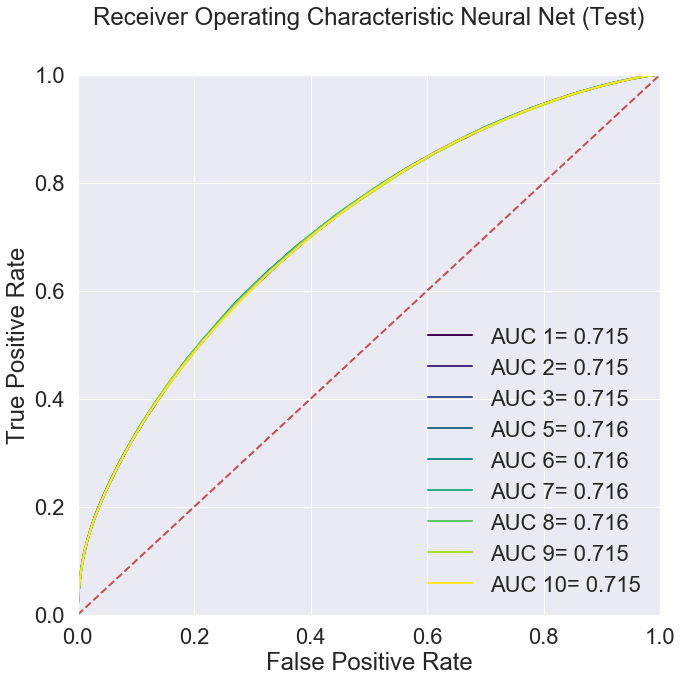

In [368]:
plot_roc_curve(Y_test, [Y_preds_model_1, Y_preds_model_2, Y_preds_model_3, Y_preds_model_5, Y_preds_model_6, Y_preds_model_7, Y_preds_model_8, Y_preds_model_9, Y_preds_model_10],
               title_text="Neural Net (Test)", label_txts=['1','2','3','5','6','7','8','9','10'])

- As we see Model 6 is a good choice in the family of neural models we checked.
- We also see that almost all the models performed similar.

## Compare the different families of models!

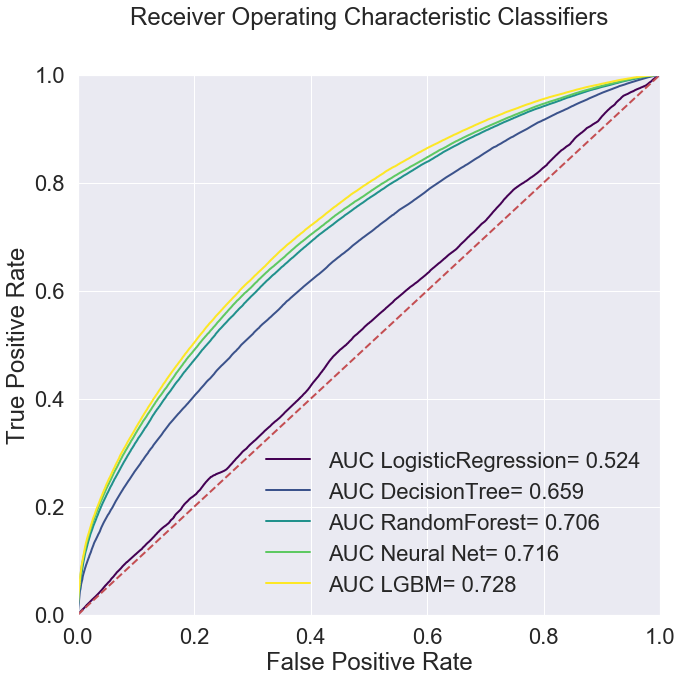

In [359]:
list_preds = [test_preds_log_reg, test_preds_tree_40, test_preds_for_50, Y_preds_model_6, test_predictions_leafs_100]
plot_roc_curve(Y_test, list_preds, title_text="Classifiers", label_txts=['LogisticRegression', 'DecisionTree', 'RandomForest', 'Neural Net', 'LGBM'])

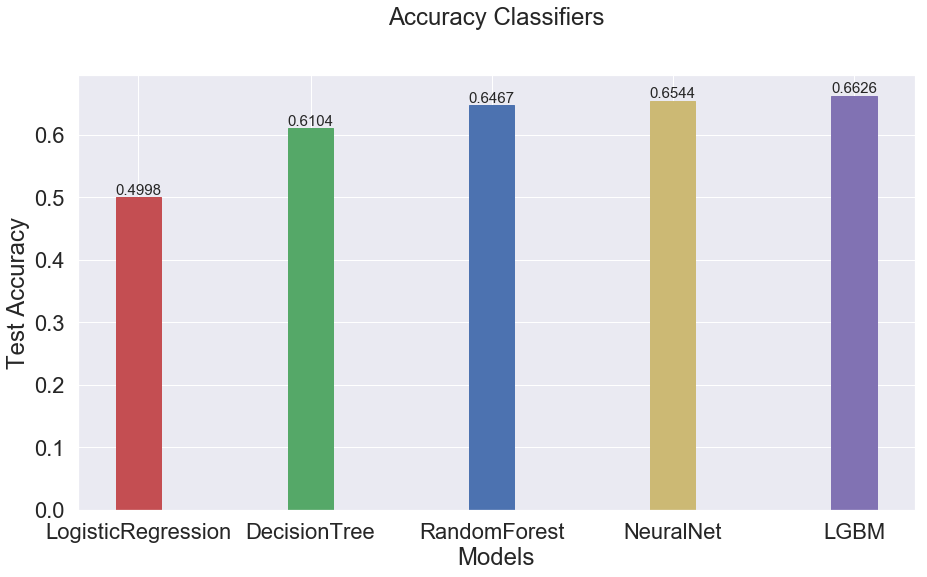

In [369]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

#sns.barplot(ax=ax, y=col, x='HasDetections', data=df_1, order=df_1[col])
width=5
#bars1 = ax.bar(x=[1+width,20+width,40+width], height=[train_accuracy_forest_10, train_accuracy_forest_25, train_accuracy_forest_50], width=width)
bars2 = ax.bar(x=[1,20,40,60,80], height=[accuracy_log_reg, accuracy_tree_40, accuracy_forest_50, eval_acc_6, test_accu_leafs_100], width=width)
ax.set_xticks([1,20,40, 60, 80])
ax.set_xticklabels(['LogisticRegression', 'DecisionTree', 'RandomForest', 'NeuralNet', 'LGBM'])
#ax.annotate('{}'.format(p.get_height()),(p.get_x(), p.get_height()))
#ax.legend((bars1[0], bars2[0]), ('Train', 'Test'), loc=(1.04,1))
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Accuracy Classifiers')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
#autolabel(bars1)
autolabel(bars2)
bars2[0].set_color('r')
bars2[1].set_color('g')
bars2[2].set_color('b')
bars2[3].set_color('y')
bars2[4].set_color('m')
#plt.legend(loc=(1.04,0))
plt.show()

### Thoughts so far...

- As we see, the Light GBM was the superior performer, as it gave a much higher AUC score than the other models, the highest accuracy.
- The Neural Network came in second but it was unable to outperform the LGBM model. 
- Another popular ensemble method, the Random Forest was a worse performer than the former two, but clearly shows how the ensemble technique can strengthen the outcome as it was significantly better than the decision tree.
- The Logistic Regression classifier (baseline) was as good as random guessing.

<hr>



# Test with feature subsets!
### We see if dropping some features affect our models.
- These features are chosen based on the feature importance of the RandomForestClassifier and LGBM and the correlation of the features.

In [360]:
feats_to_drop = ['IsBeta', 'AutoSampleOptIn', 'Census_IsPortableOperatingSystem', 'Processor', 'Census_OSSkuName', 'OsVer']

In [361]:
X_train_sub = X_train.drop(feats_to_drop, axis=1)
X_test_sub = X_test.drop(feats_to_drop, axis=1)

In [362]:
print(X_train_sub.shape)

(1000000, 70)


# We try the same models we selected above of each type.

## Model 1. Logistic Regression

In [363]:
num_splits = 5
cv = StratifiedKFold(n_splits=num_splits, random_state=1234, shuffle=True)
log_reg_clf_sub = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1)

In [364]:
for (train, test) in (list(cv.split(X_train_sub, Y_train))):
    log_reg_clf_sub.fit(X_train_sub.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', log_reg_clf_sub.score(X_train_sub.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', log_reg_clf_sub.score(X_train_sub.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   43.3s finished


Fold Train Score: 0.49988687485859357
Fold validation Score: 0.4998875005624972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.0s finished


Fold Train Score: 0.49988687485859357
Fold validation Score: 0.4998875005624972


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.1s finished


Fold Train Score: 0.4998875
Fold validation Score: 0.499885


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.6s finished


Fold Train Score: 0.49988687514140606
Fold validation Score: 0.49988749943749716


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.0s finished


Fold Train Score: 0.49988687514140606
Fold validation Score: 0.49988749943749716


In [373]:
test_preds_log_reg_sub = log_reg_clf_sub.predict_proba(X_test_sub)[:,1]
roc_auc_log_reg_sub = roc_auc_score(Y_test, test_preds_log_reg_sub)
accuracy_log_reg_sub = log_reg_clf_sub.score(X_test_sub, Y_test)
accuracy_train_log_reg_sub = log_reg_clf_sub.score(X_train_sub, Y_train)
preds_train_log_reg_sub = log_reg_clf_sub.predict(X_train_sub)
preds_test_log_reg_sub = log_reg_clf_sub.predict(X_test_sub)

In [374]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train:")
print(classification_report(Y_train, preds_train_log_reg_sub, target_names=target_names))
print('Test:')
print(classification_report(Y_test, preds_test_log_reg_sub, target_names=target_names))

Train:
                   precision    recall  f1-score   support

HasDetections = 0       0.00      0.00      0.00    500113
HasDetections = 1       0.50      1.00      0.67    499887

        micro avg       0.50      0.50      0.50   1000000
        macro avg       0.25      0.50      0.33   1000000
     weighted avg       0.25      0.50      0.33   1000000

Test:
                   precision    recall  f1-score   support

HasDetections = 0       0.00      0.00      0.00    125038
HasDetections = 1       0.50      1.00      0.67    124962

        micro avg       0.50      0.50      0.50    250000
        macro avg       0.25      0.50      0.33    250000
     weighted avg       0.25      0.50      0.33    250000



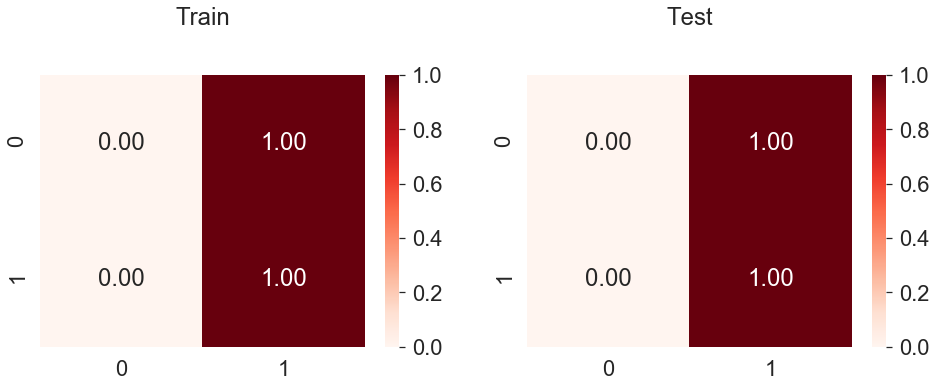

In [375]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, preds_train_log_reg_sub)
test_cnf_matrix = confusion_matrix(Y_test, preds_test_log_reg_sub)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

## Model 2. Decision Tree

In [376]:
dec_tree_clf_40_sub = DecisionTreeClassifier(min_samples_leaf=40)

In [377]:
for (train, test) in (list(cv.split(X_train_sub, Y_train))):
    dec_tree_clf_40_sub.fit(X_train_sub.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', dec_tree_clf_40_sub.score(X_train_sub.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', dec_tree_clf_40_sub.score(X_train_sub.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.7002958753698442
Fold validation Score: 0.6081619591902041
Fold Train Score: 0.7002971253714068
Fold validation Score: 0.6082369588152059
Fold Train Score: 0.7011075
Fold validation Score: 0.608735
Fold Train Score: 0.7006753741557823
Fold validation Score: 0.6094980474902375
Fold Train Score: 0.7006216242229697
Fold validation Score: 0.6063780318901595


In [378]:
test_preds_tree_40_sub = dec_tree_clf_40_sub.predict_proba(X_test_sub)[:,1]
#plot_roc_curve(Y_test, test_preds, "DecisionTreeClassifier_40")
roc_auc_tree_40_sub = roc_auc_score(Y_test, test_preds_tree_40_sub)
accuracy_tree_40_sub = dec_tree_clf_40_sub.score(X_test_sub, Y_test)
accuracy_train_tree_40_sub = dec_tree_clf_40_sub.score(X_train_sub, Y_train)
preds_train_tree_40_sub = dec_tree_clf_40_sub.predict(X_train_sub)
preds_test_tree_40_sub = dec_tree_clf_40_sub.predict(X_test_sub)

In [379]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train:")
print(classification_report(Y_train, preds_train_tree_40_sub, target_names=target_names))
print('Test:')
print(classification_report(Y_test, preds_test_tree_40_sub, target_names=target_names))

Train:
                   precision    recall  f1-score   support

HasDetections = 0       0.67      0.70      0.69    500113
HasDetections = 1       0.69      0.66      0.67    499887

        micro avg       0.68      0.68      0.68   1000000
        macro avg       0.68      0.68      0.68   1000000
     weighted avg       0.68      0.68      0.68   1000000

Test:
                   precision    recall  f1-score   support

HasDetections = 0       0.61      0.63      0.62    125038
HasDetections = 1       0.61      0.59      0.60    124962

        micro avg       0.61      0.61      0.61    250000
        macro avg       0.61      0.61      0.61    250000
     weighted avg       0.61      0.61      0.61    250000



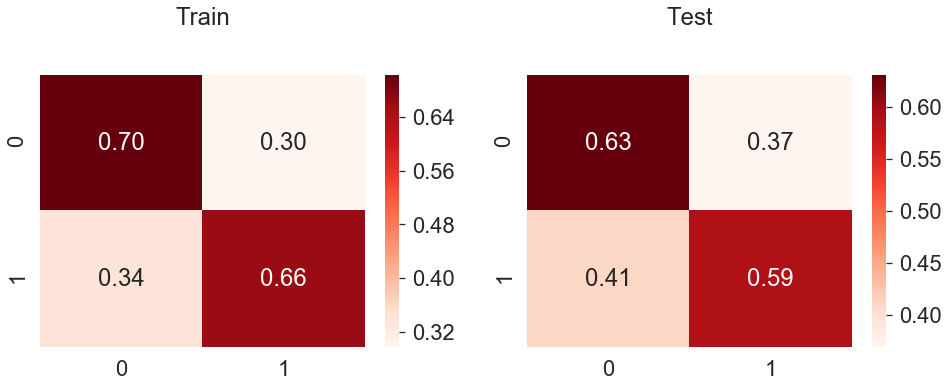

In [380]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, preds_train_tree_40_sub)
test_cnf_matrix = confusion_matrix(Y_test, preds_test_tree_40_sub)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

## Model 3. Random Forest

In [381]:
rand_for_clf_50_sub = RandomForestClassifier(n_estimators=50, min_samples_leaf=40, max_features='auto', n_jobs=-1, oob_score=False, verbose=0)

In [382]:
for (train, test) in (list(cv.split(X_train_sub, Y_train))):
    rand_for_clf_50_sub.fit(X_train_sub.iloc[train], Y_train.iloc[train])
    #print(Y_train.iloc[train])
    print('Fold Train Score:', rand_for_clf_50_sub.score(X_train_sub.iloc[train], Y_train.iloc[train]))
    print('Fold validation Score:', rand_for_clf_50_sub.score(X_train_sub.iloc[test], Y_train.iloc[test]))
    #print_score(log_reg_clf, train, test)

Fold Train Score: 0.7010271262839078
Fold validation Score: 0.6450867745661272
Fold Train Score: 0.7002408753010941
Fold validation Score: 0.6446217768911155
Fold Train Score: 0.70087125
Fold validation Score: 0.644445
Fold Train Score: 0.7013228733464083
Fold validation Score: 0.6448282241411207
Fold Train Score: 0.7017278728401589
Fold validation Score: 0.6451282256411282


In [383]:
test_preds_for_50_sub = rand_for_clf_50_sub.predict_proba(X_test_sub)[:,1]
#plot_roc_curve(Y_test, test_preds, "RandomForestClassifier")
roc_auc_forest_50_sub = roc_auc_score(Y_test, test_preds_for_50_sub)
accuracy_forest_50_sub = rand_for_clf_50_sub.score(X_test_sub, Y_test)
accuracy_train_forest_50_sub = rand_for_clf_50_sub.score(X_train_sub, Y_train)
preds_train_forest_50_sub = rand_for_clf_50_sub.predict(X_train_sub)
preds_test_forest_50_sub = rand_for_clf_50_sub.predict(X_test_sub)

In [384]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train:")
print(classification_report(Y_train, preds_train_forest_50_sub, target_names=target_names))
print('Test:')
print(classification_report(Y_test, preds_test_forest_50_sub, target_names=target_names))

Train:
                   precision    recall  f1-score   support

HasDetections = 0       0.69      0.70      0.69    500113
HasDetections = 1       0.69      0.68      0.69    499887

        micro avg       0.69      0.69      0.69   1000000
        macro avg       0.69      0.69      0.69   1000000
     weighted avg       0.69      0.69      0.69   1000000

Test:
                   precision    recall  f1-score   support

HasDetections = 0       0.64      0.65      0.65    125038
HasDetections = 1       0.65      0.64      0.64    124962

        micro avg       0.65      0.65      0.65    250000
        macro avg       0.65      0.65      0.65    250000
     weighted avg       0.65      0.65      0.65    250000



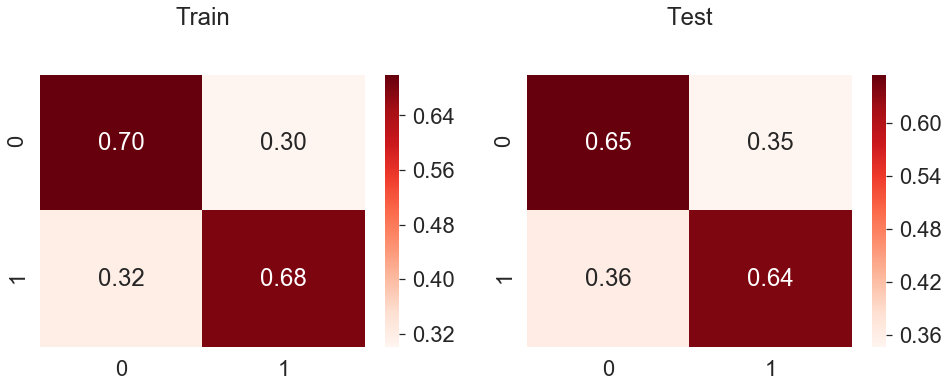

In [385]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_train, preds_train_forest_50_sub)
test_cnf_matrix = confusion_matrix(Y_test, preds_test_forest_50_sub)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

## Model 4. LGBM

#### Create train-val split from Train data.

In [386]:
X_tr_2, X_val_2, Y_tr_2, Y_val_2 = train_test_split(X_train_sub, Y_train, test_size=0.1)
X_tr_2_lgbm = lgb.Dataset(X_tr_2, label=Y_tr_2)
X_val_2_lgbm = lgb.Dataset(X_val_2, label=Y_val_2)

In [387]:
params1 = {
    'num_leaves': 100,   #150, 200, 255
     'min_data_in_leaf': 100, # can increase to 500 and 1000 
     'objective':'binary',
     'max_depth': 8,
     'learning_rate': 0.05,
     "boosting": "gbdt",
     "feature_fraction": 0.8,
     "bagging_freq": 5,
     "bagging_fraction": 0.8 ,
     "bagging_seed": 3,
     "metric": 'auc',
     "lambda_l1": 1e-06,
     "random_state": 133,
     "verbosity": 100 }
lgbm_model_subset_feature = lgb.train(params1, X_tr_2_lgbm, 10000, valid_sets=[X_tr_2_lgbm, X_val_2_lgbm], early_stopping_rounds=200, verbose_eval=100)

Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.71334	valid_1's auc: 0.708959
[200]	training's auc: 0.725349	valid_1's auc: 0.716679
[300]	training's auc: 0.733019	valid_1's auc: 0.720285
[400]	training's auc: 0.739002	valid_1's auc: 0.722332
[500]	training's auc: 0.744083	valid_1's auc: 0.724111
[600]	training's auc: 0.748986	valid_1's auc: 0.725096
[700]	training's auc: 0.75309	valid_1's auc: 0.725667
[800]	training's auc: 0.756995	valid_1's auc: 0.726138
[900]	training's auc: 0.760778	valid_1's auc: 0.726678
[1000]	training's auc: 0.764481	valid_1's auc: 0.727101
[1100]	training's auc: 0.768026	valid_1's auc: 0.727364
[1200]	training's auc: 0.771525	valid_1's auc: 0.727652
[1300]	training's auc: 0.774949	valid_1's auc: 0.727777
[1400]	training's auc: 0.778153	valid_1's auc: 0.727846
[1500]	training's auc: 0.781443	valid_1's auc: 0.727934
[1600]	training's auc: 0.784527	valid_1's auc: 0.727923
[1700]	training's auc: 0.7875	valid_1's auc: 0.72791

In [388]:
train_predictions_leafs_100_feat_subset = lgbm_model_subset_feature.predict(X_tr_2, num_iteration=lgbm_model_subset_feature.best_iteration)
test_predictions_leafs_100_feat_subset = lgbm_model_subset_feature.predict(X_test_sub, num_iteration=lgbm_model_subset_feature.best_iteration)

train_preds_leafs_100_feat_subset = np.rint(train_predictions_leafs_100_feat_subset)
test_preds_leafs_100_feat_subset = np.rint(test_predictions_leafs_100_feat_subset)


In [389]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train:")
print(classification_report(Y_tr_2, train_preds_leafs_100_feat_subset, target_names=target_names))
print('Test:')
print(classification_report(Y_test, test_preds_leafs_100_feat_subset, target_names=target_names))

Train:
                   precision    recall  f1-score   support

HasDetections = 0       0.70      0.71      0.71    450278
HasDetections = 1       0.71      0.70      0.70    449722

        micro avg       0.70      0.70      0.70    900000
        macro avg       0.70      0.70      0.70    900000
     weighted avg       0.70      0.70      0.70    900000

Test:
                   precision    recall  f1-score   support

HasDetections = 0       0.66      0.67      0.66    125038
HasDetections = 1       0.66      0.66      0.66    124962

        micro avg       0.66      0.66      0.66    250000
        macro avg       0.66      0.66      0.66    250000
     weighted avg       0.66      0.66      0.66    250000



In [391]:
train_roc_leafs_100_feat_subset = roc_auc_score(Y_tr_2, train_predictions_leafs_100_feat_subset)
test_roc_leafs_100_feat_subset = roc_auc_score(Y_test, test_predictions_leafs_100_feat_subset)
train_accu_leafs_100_feat_subset = accuracy_score(Y_tr_2, train_preds_leafs_100_feat_subset)
test_accu_leafs_100_feat_subset = accuracy_score(Y_test, test_preds_leafs_100_feat_subset)
print("Train AUC Score: %0.4f" %train_roc_leafs_100_feat_subset)
print("Test AUC Score: %0.4f" %test_roc_leafs_100_feat_subset)
print("Train Accuracy Score: %0.4f" %train_accu_leafs_100_feat_subset)
print("Test Accuracy Score: %0.4f" %test_accu_leafs_100_feat_subset)

Train AUC Score: 0.7817
Test AUC Score: 0.7278
Train Accuracy Score: 0.7048
Test Accuracy Score: 0.6619


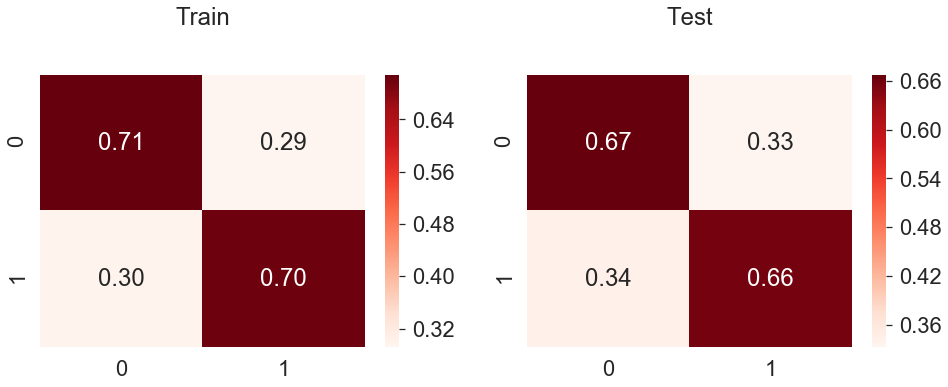

In [390]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_tr_2, train_preds_leafs_100_feat_subset)
test_cnf_matrix = confusion_matrix(Y_test, test_preds_leafs_100_feat_subset)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

## Model 5. Neural Net

### Data Prep (Same as before)

#### These columns are going to be used through embedding layers.

In [393]:
embed_cols_sub = []
len_embed_cols_sub = []
for c in categorical_columns[1:]:
    if c in train_copy.columns and c not in feats_to_drop:
        if train_copy[c].nunique()>2:
            embed_cols_sub.append(c)
            len_embed_cols_sub.append(train_copy[c].nunique())
            print(c + ': %d values' % train_copy[c].nunique()) #look at value counts to know the embedding dimensions
print('\n Number of embed features :', len(embed_cols))

ProductName: 6 values
EngineVersion: 62 values
AppVersion: 98 values
RtpStateBitfield: 7 values
AVProductsInstalled: 7 values
AVProductsEnabled: 7 values
CountryIdentifier: 222 values
OrganizationIdentifier: 47 values
GeoNameIdentifier: 274 values
LocaleEnglishNameIdentifier: 234 values
Platform: 4 values
OsBuild: 53 values
OsSuite: 10 values
OsPlatformSubRelease: 9 values
SkuEdition: 8 values
IeVerIdentifier: 217 values
SmartScreen: 15 values
UacLuaenable: 9 values
Census_MDC2FormFactor: 12 values
Census_DeviceFamily: 3 values
Census_ProcessorManufacturerIdentifier: 5 values
Census_PrimaryDiskTypeName: 5 values
Census_ChassisTypeName: 40 values
Census_PowerPlatformRoleName: 11 values
Census_OSVersion: 342 values
Census_OSArchitecture: 3 values
Census_OSBranch: 20 values
Census_OSBuildNumber: 88 values
Census_OSBuildRevision: 246 values
Census_OSEdition: 26 values
Census_OSInstallTypeName: 9 values
Census_OSInstallLanguageIdentifier: 40 values
Census_OSUILocaleIdentifier: 109 values
Ce

#### Now we use a Min-max scaler

In [394]:
from sklearn.preprocessing import MinMaxScaler
# Select the numeric features
other_cols_sub = [x for x in X_train_sub.columns if x not in embed_cols_sub]

# Impute missing values in order to scale
#X_train[other_cols] = X_train[other_cols].fillna(X_train[other_cols].median())


# Fit the scaler only on df_all data
scaler_sub = MinMaxScaler().fit(X_train_sub[other_cols_sub])
X_train_sub.loc[:, other_cols_sub] = scaler_sub.transform(X_train_sub[other_cols_sub])

In [395]:
X_test_sub.loc[:, other_cols_sub] = scaler_sub.transform(X_test_sub[other_cols_sub])

In [396]:
cols_sub = embed_cols_sub + other_cols_sub
X_train_sub = X_train_sub[cols_sub]
X_test_sub = X_test_sub[cols_sub]
#X_train.head()

In [397]:
print(X_train_sub.shape)

(1000000, 70)


#### But first, lets create train-val split from Train data.

In [398]:
X_tr_2, X_val_2, Y_tr_2, Y_val_2 = train_test_split(X_train_sub, Y_train, test_size=0.1)

#### Define and train

In [399]:
def NN_model_6_sub():
    models = []
    num_numeric = len(other_cols_sub)
    inputs = Input(shape=(len(embed_cols_sub)+len(other_cols_sub),), name="input_node")
    for i, categoical_var in enumerate(embed_cols_sub):
        len_emb = len_embed_cols_sub[i]
        embed_size = len_emb//2
        emb_x = Lambda(lambda x: x[:, i:i+1], name="lambda_index_"+str(i))(inputs)
        emb_x = Embedding(len_emb+1, embed_size, name="embed_"+str(i))(emb_x)
        emb_x = Reshape(target_shape=(embed_size,), name="reshape_"+str(i))(emb_x)
        emb_x = Dropout(0.3, name="dropout_"+str(i))(emb_x)
        models.append(emb_x)
    rest = Lambda(lambda x: x[:, len(embed_cols_sub):], name="numeric")(inputs)
    models.append(rest)
    full_model = concatenate(models, axis=-1, name="concat")
    #full_model = Dense(1024, name="dense_1024")(full_model)
    #full_model = Activation('relu', name='relu_1024')(full_model)
    #full_model = BatchNormalization(name="batch_norm_1024a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_1024')(full_model)
    #full_model = Dense(512, name="dense_512")(full_model)
    #full_model = Activation('relu', name='relu_512')(full_model)
    #full_model = BatchNormalization(name="batch_norm_512a")(full_model)
    #ful_model = Dropout(0.25, name='dropout_act_512')(full_model)
    full_model = Dense(256, name="dense_256")(full_model)
    full_model = Activation('relu', name='relu_256')(full_model)
    full_model = BatchNormalization(name="batch_norm_256a")(full_model)
    #ful_model = Dropout(0.2, name='dropout_act_256')(full_model)
    full_model = Dense(128, name="dense_128")(full_model)
    full_model = Activation('relu', name="relu_128")(full_model)
    full_model = BatchNormalization(name="batch_norm_128a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_128")(full_model)
    full_model = Dense(64, name="dense_64")(full_model)
    full_model = Activation('relu', name="relu_64")(full_model)
    full_model = BatchNormalization(name="batch_norm_64a")(full_model)
    #full_model = Dropout(0.2, name="dropout_act_64")(full_model)
    full_model = Dense(32, name="dense_32")(full_model)
    full_model = Activation('relu', name="relu_32")(full_model)
    #full_model = Dropout(0.25, name="dropout_act_3")(full_model)
    #full_model = BatchNormalization(name="batch_norm_32a")(full_model)
    preds = Dense(1, name="dense_1", activation='sigmoid')(full_model)
    nn_model = Model(inputs=inputs, outputs=preds)
    #optimizer = keras.optimizers.Nadam(lr=0.002, schedule_decay=0.004)
    nn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return nn_model

In [400]:
model_6_sub = NN_model_6_sub()
model_6_sub.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_node (InputLayer)         (None, 70)           0                                            
__________________________________________________________________________________________________
lambda_index_0 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_1 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_index_2 (Lambda)         (None, 1)            0           input_node[0][0]                 
__________________________________________________________________________________________________
lambda_ind

__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 49)           0           embed_2[0][0]                    
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 3)            0           embed_3[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 3)            0           embed_4[0][0]                    
__________________________________________________________________________________________________
reshape_5 (Reshape)             (None, 3)            0           embed_5[0][0]                    
__________________________________________________________________________________________________
reshape_6 (Reshape)             (None, 111)          0           embed_6[0][0]                    
__________

                                                                 dropout_9[0][0]                  
                                                                 dropout_10[0][0]                 
                                                                 dropout_11[0][0]                 
                                                                 dropout_12[0][0]                 
                                                                 dropout_13[0][0]                 
                                                                 dropout_14[0][0]                 
                                                                 dropout_15[0][0]                 
                                                                 dropout_16[0][0]                 
                                                                 dropout_17[0][0]                 
                                                                 dropout_18[0][0]                 
          

In [401]:
model_hist_6_sub = model_6_sub.fit(x=X_tr_2.values, y=Y_tr_2.values, validation_data=(X_val_2.values, Y_val_2.values), epochs=6, batch_size=512, verbose=2)

Train on 900000 samples, validate on 100000 samples
Epoch 1/6
 - 65s - loss: 0.6347 - acc: 0.6295 - val_loss: 0.6257 - val_acc: 0.6390
Epoch 2/6
 - 54s - loss: 0.6220 - acc: 0.6447 - val_loss: 0.6213 - val_acc: 0.6451
Epoch 3/6
 - 54s - loss: 0.6182 - acc: 0.6485 - val_loss: 0.6201 - val_acc: 0.6455
Epoch 4/6
 - 54s - loss: 0.6154 - acc: 0.6519 - val_loss: 0.6184 - val_acc: 0.6484
Epoch 5/6
 - 54s - loss: 0.6130 - acc: 0.6540 - val_loss: 0.6182 - val_acc: 0.6489
Epoch 6/6
 - 55s - loss: 0.6108 - acc: 0.6565 - val_loss: 0.6170 - val_acc: 0.6497


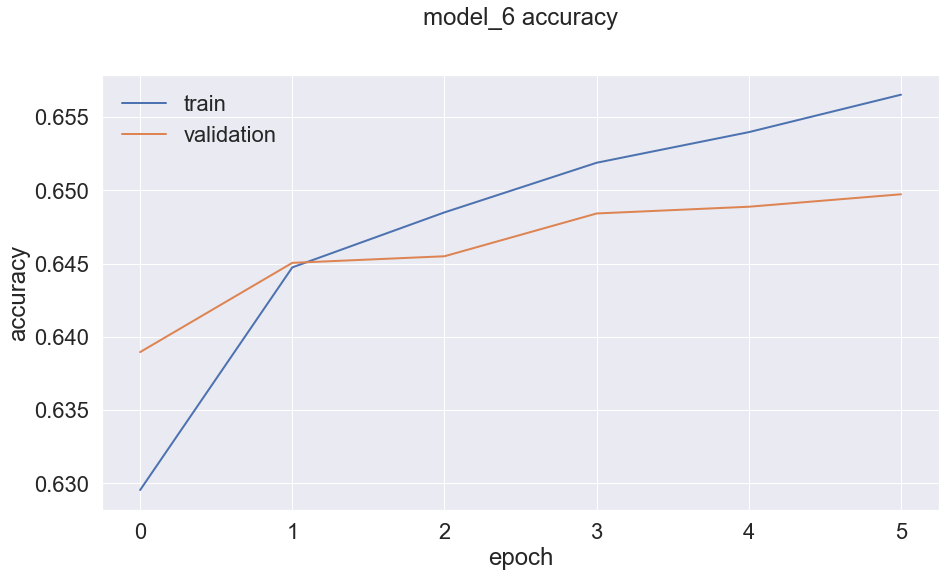

In [402]:
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(model_hist_6_sub.history['acc'])
plt.plot(model_hist_6_sub.history['val_acc'])
plt.title('model_6 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

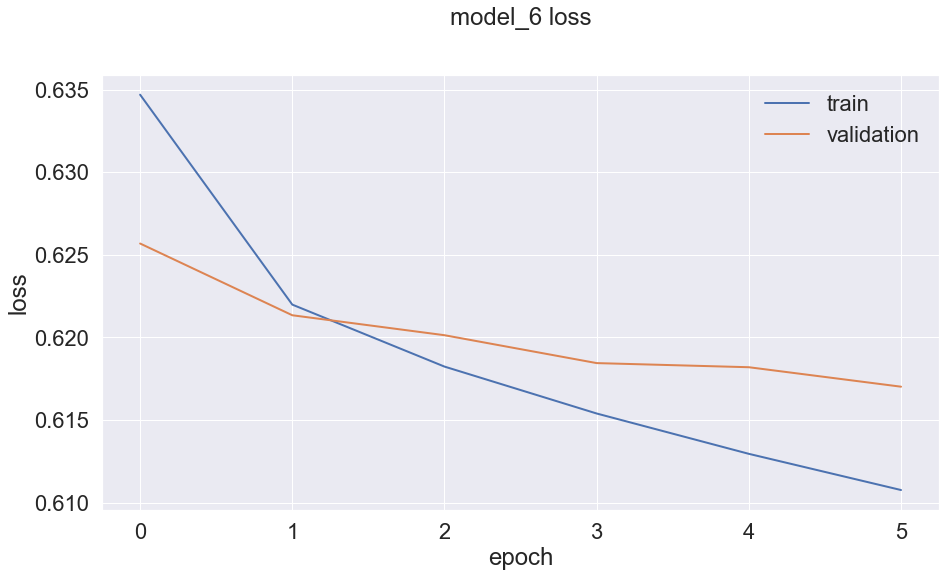

In [403]:
plt.plot(model_hist_6_sub.history['loss'])
plt.plot(model_hist_6_sub.history['val_loss'])
plt.title('model_6 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [404]:
Y_preds_model_6_sub = model_6_sub.predict(X_test_sub)
Y_preds_val_model_6_sub = model_6_sub.predict(X_val_2)
Y_preds_train_model_6_sub = model_6_sub.predict(X_tr_2)

Y_pred_class_model_6_sub = np.rint(Y_preds_model_6_sub)
Y_pred_class_train_model_6_sub = np.rint(Y_preds_train_model_6_sub)

#roc_auc_model_6 = roc_auc_score(Y_test, Y_preds_model_8)
roc_auc_model_6_sub = roc_auc_score(Y_test, Y_preds_model_6_sub)
print("AUC Score:",roc_auc_score(Y_val_2, Y_preds_val_model_6_sub))

AUC Score: 0.7108881499659032


In [405]:
eval_loss_6_sub, eval_acc_6_sub = model_6_sub.evaluate(X_test_sub, Y_test, verbose=0)

In [406]:
target_names=['HasDetections = 0', 'HasDetections = 1']
print("Train:")
print(classification_report(Y_tr_2, Y_pred_class_train_model_6_sub, target_names=target_names))
print('Test:')
print(classification_report(Y_test, Y_pred_class_model_6_sub, target_names=target_names))

Train:
                   precision    recall  f1-score   support

HasDetections = 0       0.66      0.69      0.67    450014
HasDetections = 1       0.67      0.64      0.66    449986

        micro avg       0.67      0.67      0.67    900000
        macro avg       0.67      0.67      0.67    900000
     weighted avg       0.67      0.67      0.67    900000

Test:
                   precision    recall  f1-score   support

HasDetections = 0       0.65      0.68      0.66    125038
HasDetections = 1       0.66      0.63      0.65    124962

        micro avg       0.65      0.65      0.65    250000
        macro avg       0.65      0.65      0.65    250000
     weighted avg       0.65      0.65      0.65    250000



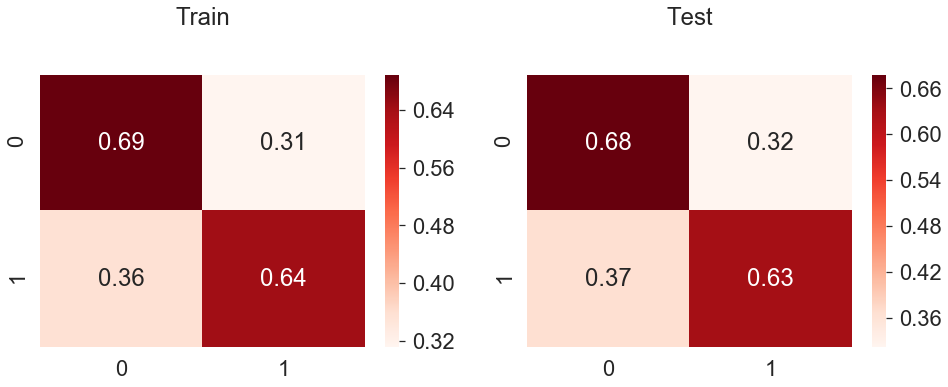

In [407]:
f, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(Y_tr_2, Y_pred_class_train_model_6_sub)
test_cnf_matrix = confusion_matrix(Y_test, Y_pred_class_model_6_sub)

train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
test_cnf_matrix_norm = test_cnf_matrix / test_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
test_df_cm = pd.DataFrame(test_cnf_matrix_norm, index=[0, 1], columns=[0, 1])

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[0]).set_title("Train")
sns.heatmap(test_df_cm, annot=True, fmt='.2f', cmap="Reds", ax=axes[1]).set_title("Test")
plt.show()

### x-axis: Prediction; y-axis: Ground Truth

- The False Omission Rate seems higher than the model trained with all features. But overall the performance does not seem quite different. 
- Let us compare finally and see!

## Compare Models

### ROC AUC

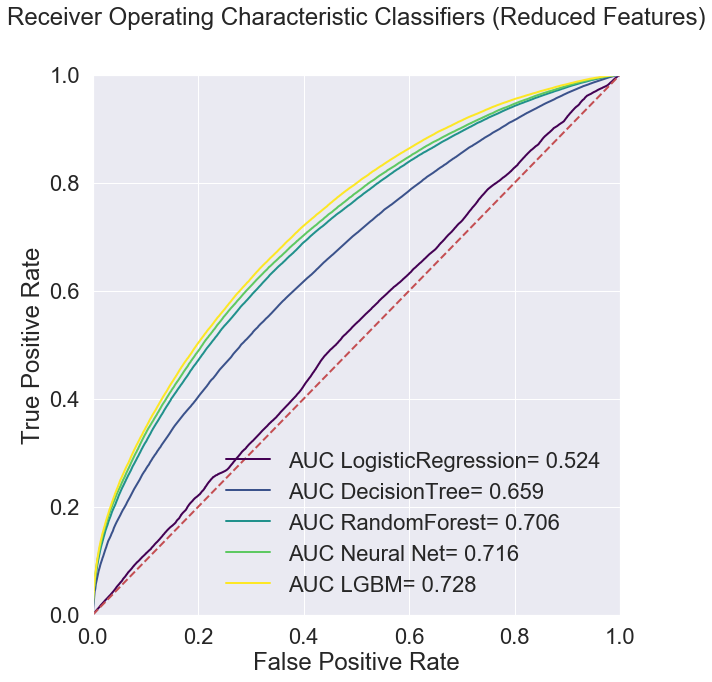

In [408]:
list_preds = [test_preds_log_reg_sub, test_preds_tree_40_sub, test_preds_for_50_sub, Y_preds_model_6_sub, test_predictions_leafs_100_feat_subset]
plot_roc_curve(Y_test, list_preds, title_text="Classifiers (Reduced Features)", label_txts=['LogisticRegression', 'DecisionTree', 'RandomForest', 'Neural Net', 'LGBM'])

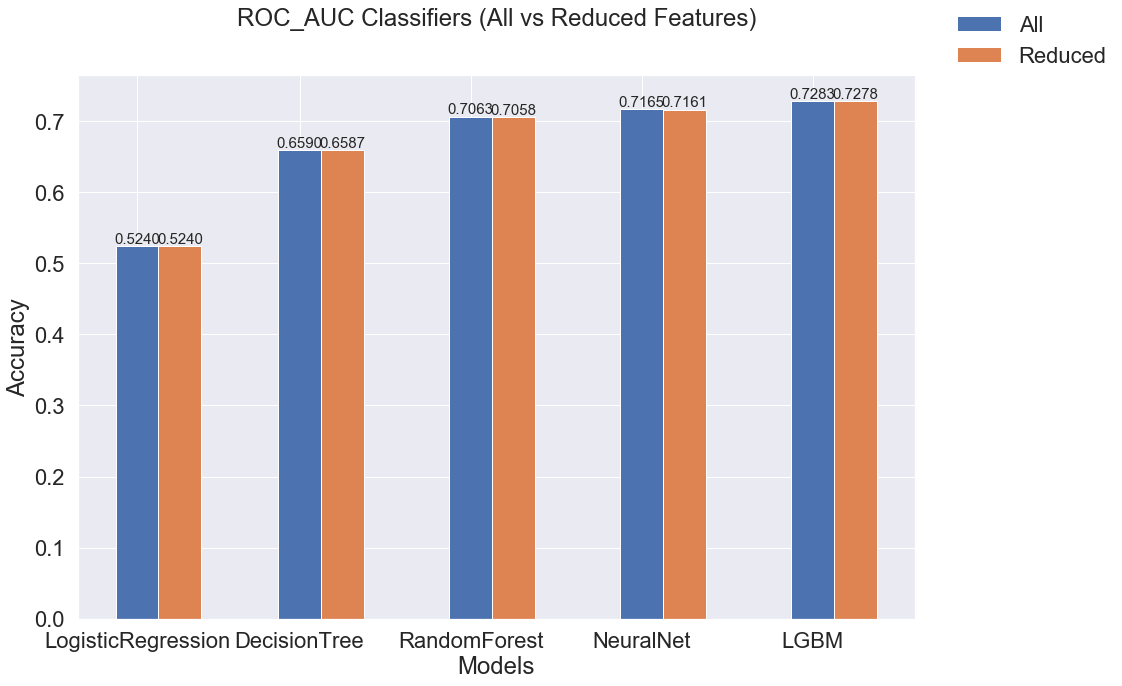

In [409]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.barplot(ax=ax, y=col, x='HasDetections', data=df_1, order=df_1[col])
width=5
bars1 = ax.bar(x=[1,20,40,60, 80], height=[roc_auc_log_reg, roc_auc_tree_40, roc_auc_forest_50, roc_auc_model_6, test_roc_leafs_100], width=width)
bars2 = ax.bar(x=[1+width,20+width,40+width,60+width, 80+width], height=[roc_auc_log_reg_sub, roc_auc_tree_40_sub, roc_auc_forest_50_sub, roc_auc_model_6_sub, test_roc_leafs_100_feat_subset], width=width)
ax.set_xticks([1,20,40,60, 80])
ax.set_xticklabels(['LogisticRegression', 'DecisionTree', 'RandomForest', 'NeuralNet', 'LGBM'])
#ax.annotate('{}'.format(p.get_height()),(p.get_x(), p.get_height()))
ax.legend((bars1[0], bars2[0]), ('All', 'Reduced'), loc=(1.04,1))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('ROC_AUC Classifiers (All vs Reduced Features)')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
# bars2[0].set_color('r')
# bars2[1].set_color('g')
# bars2[2].set_color('b')
# bars2[3].set_color('y')
#plt.legend(loc=(1.04,0))
plt.show()

## Accuracy

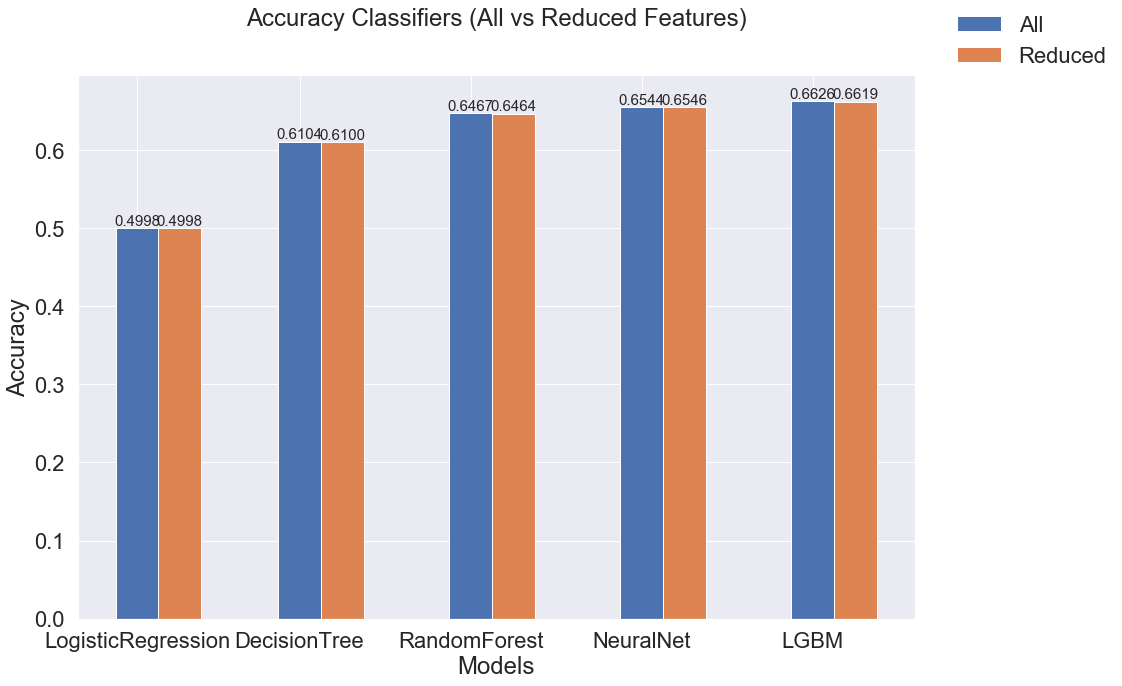

In [410]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
#sns.barplot(ax=ax, y=col, x='HasDetections', data=df_1, order=df_1[col])
width=5
bars1 = ax.bar(x=[1,20,40, 60, 80], height=[accuracy_log_reg, accuracy_tree_40, accuracy_forest_50, eval_acc_6, test_accu_leafs_100], width=width)
bars2 = ax.bar(x=[1+width,20+width,40+width, 60+width, 80+width], height=[accuracy_log_reg_sub, accuracy_tree_40_sub, accuracy_forest_50_sub, eval_acc_6_sub, test_accu_leafs_100_feat_subset], width=width)
ax.set_xticks([1,20,40, 60, 80])
ax.set_xticklabels(['LogisticRegression', 'DecisionTree', 'RandomForest', 'NeuralNet', 'LGBM'])
#ax.annotate('{}'.format(p.get_height()),(p.get_x(), p.get_height()))
ax.legend((bars1[0], bars2[0]), ('All', 'Reduced'), loc=(1.04,1))
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Classifiers (All vs Reduced Features)')
def autolabel(bars):
    for rect in bars:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.0*h, '%.4f'%(h),
                ha='center', va='bottom', fontsize=15)
autolabel(bars1)
autolabel(bars2)
# bars2[0].set_color('r')
# bars2[1].set_color('g')
# bars2[2].set_color('b')
# bars2[3].set_color('y')
#plt.legend(loc=(1.04,0))
plt.show()

- Less features does not affect performance much. Although for the neural model we definitely see some more overfitting on the training data. 
- So, we indeed can work on fewer features.



***



# Conclusion

So as part of this project, we have explored the possibility to predict the malware infection of a Windows machine based on its several properties. We performed initial data analysis, categorical feature encoding for downstream application and reduced memory usage. Further, we explored different models, the LogisticRegression, DecisionTree, RandomForest, Light GBM and Neural Network. We tried hyperparameter optimization and compared the models.
<br><br> Eventually, we managed to get 0.728 AUC score for ROC, and at 50% threshold, we get accuracy score of ~ 66% (both are by Light GBM). So, given a set of features and assuming the threshold being 50%, our best model has a 66% probability of making a correct prediction.
<br><br>We conclude that the LGBM was the best model suited for this task as per our analysis. It gave the higher accuracy, far superior ROC AUC score (0.728 compared to Neural Net 0.716) than the others. It needed some hyperparameter optimization but it was fast to train as well. Moreover we can get an interpretable output as we can see which features were more important. The Neural network models we created failed to match the performance of the LGBM and were slower to train generally. We also cannot readily get an intuitive explanation of the model.
<br><br>Our results perhaps show why ensemble tree based methods have been quite popular for Kaggle competitions. Not only are they fast to train, so easier hyperparameter tuning, but they can give competitive score even without too much tuning. It also seems that such models are better suited for such tabular heterogenous data, whereas a Neural net can work well with homogenous data like image or text more.
<br><br>We also performed some feature selection and see that we can indeed work with fewer features than what is provided as many of them are just not that important, and some are even correlated to some extent.

# Future Work

For further work, we can definitely try the following:
- Perform smarter feature engineering which could improve the models further.
- Perform more intensive hyperparameter tuning.
- Maybe come up with a smarter Neural Network model and/or feature encoding that can work with the heterogenous format of the data.
- Finally, Malware analysis can also be treated as a time series analysis. Some of the provided features could give us some time information (perhaps the Engine versions). Maybe if we can account for that, we can build better models suited for the task.

# -------------------------------------------------------------------------------------------------------